In [1]:
from typing import List
import numpy as np
import ground_texture_slam
import os
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import time

## Helper functions

In [2]:
def create_vocabulary() -> None:
    """
    Build a vocabulary tree out of random noise descriptors and save it locally for later use by the
    SLAM system.
    """
    # print('Building the vocabulary from random descriptors...')
    all_descriptors = []
    # for _ in range(100):
    #     all_descriptors.append(np.random.randint(
    #         low=0, high=256, size=(500, 32), dtype=np.uint8))
    vocab_options = ground_texture_slam.BagOfWords.VocabOptions()
    vocab_options.descriptors = all_descriptors
    bag_of_words = ground_texture_slam.BagOfWords(vocab_options)
    bag_of_words.save_vocabulary('example_vocab_python.bow')
    # print('\tDone!')

In [3]:
def load_images(path=""):
    """
    Load images from the path given
    """
    images = []
    img_path = [path + i for i in os.listdir(path)]
    img_path.sort()
    for i in img_path:
        img = cv2.imread(i)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        images.append(img)
    print("Warning: Sampling 1/10th of the images")
    return images

In [4]:
def run_algo(path,window_size=0):
    # Build a vocabulary to use later.
    create_vocabulary()
    
    # Set all the parameters of this fake SLAM system. The important ones are the camera intrinsic
    # matrix and pose, and the vocabulary for bag of words.
    # print('Loading system...')

    options = ground_texture_slam.GroundTextureSLAM.Options()
    options.bag_of_words_options.vocab_file = 'example_vocab_python.bow'
    options.keypoint_matcher_options.match_threshold = 0.6
    
    # Normally, you want a sliding window so that successive images don't get compared for loop
    # closure. However, I am specifically allowing that here since there are only a few images.
    options.sliding_window = window_size

    # Define camera matrix*
    # print('Adding camera matrix...')
    # Default params for author's dataset
    fx = 2195.70853
    fy = 2195.56073
    ppx = 820.7289683
    ppy = 606.242723

    
    camera_matrix = np.array([
        [fx, 0, ppx],
        [0, fy, ppy],
        [0, 0, 1]
    ])

    camera_matrix = np.array([[1.67335571e+03, 0.00000000e+00, 5.31489763e+02],
        [0.00000000e+00, 1.67795361e+03, 9.47476693e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
    options.image_parser_options.camera_intrinsic_matrix = camera_matrix
    
    # print('Adding camera pose...')
    # camera_pose = np.array([
    #     [0.0, 0.0, 1.0, 0.0],
    #     [0.0, 1.0, 0.0, 0.0],
    #     [-1.0, 0.0, 0.0, 0.25],
    #     [0.0, 0.0, 0.0, 1.0]
    # ])

    camera_pose = np.array([
        [0.0, -1.0, 0.0, 0.0],
        [0.0, 0.0, -1.0, 0.0],
        [1.0, 0.0, 0.0, 0.44],
        [0.0, 0.0, 0.0, 1.0]
    ])
    options.image_parser_options.camera_pose = camera_pose
    
    # Get the images "captured" by the robot.
    # Also, create some fake start pose info. This doesn't matter so set it to the origin. You could
    # also set it to a known start pose to align with any data you are comparing against.
    # Unlike C++, there is only one input type here - np arrays.
    
    # print('Loading images...')
    # images = create_images()
    images = load_images(path)
    # print(f"Found {len(images)} Images with shape {images[0].shape}")
    
    start_pose = np.zeros((3,), dtype=np.float64)
    start_covariance = np.identity(3, dtype=np.float64)
    
    # print("Defining system...")
    system = ground_texture_slam.GroundTextureSLAM(
        options, images[0], start_pose, start_covariance)
    # Now add each image. This would be done as images are received.
    # print('Adding images...')
    for i in range(1, len(images)):
        system.insert_measurement(images[i])
    pose_estimates = system.get_pose_estimates_matrix()

    # Once done, get the optimized poses. This can be done incrementally after each image as well.
    # The results probably won't be any good, since this is a bunch of random images. But it
    # illustrates the point.
    return pose_estimates

## Runing the algorithm

In [5]:
paths = [
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path2/210806/seq0080/',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path4/210806/seq0082/',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path5/210806/seq0083/',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path6/210806/seq0084/',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path1/210806/seq0079/',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path3/210806/seq0081/',
'/media/ajax/AJ/ground-slam/garage_concrete/test_path5/210809/seq0119/',
'/media/ajax/AJ/ground-slam/garage_concrete/test_path3/210809/seq0111/',
'/media/ajax/AJ/ground-slam/checker_plate_steel/test_path2/210814/seq0020/',
'/media/ajax/AJ/ground-slam/checker_plate_steel/test_path1/210814/seq0019/',
'/media/ajax/AJ/ground-slam/office_test_sq/test_path1/seq0029/',
'/media/ajax/AJ/ground-slam/bathroom_tiles/test_path4/210814/seq0043/',
'/media/ajax/AJ/ground-slam/bathroom_tiles/test_path1/210814/seq0039/',
'/media/ajax/AJ/ground-slam/parking_place_test_sq/test_path2/seq0029/',
'/media/ajax/AJ/ground-slam/parking_place_test_sq/test_path1/seq0028/',
'/media/ajax/AJ/ground-slam/footpath_test_sq/test_path2/seq0028/',
'/media/ajax/AJ/ground-slam/footpath_test_sq/test_path1/seq0027/',
'/media/ajax/AJ/ground-slam/doormat/test_path1/seq0029/',
'/media/ajax/AJ/ground-slam/kitchen_test_sq/test_path2/seq0032/',
'/media/ajax/AJ/ground-slam/kitchen_test_sq/test_path1/seq0031/']
# '/media/ajax/AJ/ground-slam/terrace_pavement/database/',
# '/media/ajax/AJ/ground-slam/workroom_linoleum/database/',
# '/media/ajax/AJ/ground-slam/garage_concrete/database/',
# '/media/ajax/AJ/ground-slam/checker_plate_steel/database/',
# '/media/ajax/AJ/ground-slam/office_test_sq/database/',
# '/media/ajax/AJ/ground-slam/bathroom_tiles/database/',
# '/media/ajax/AJ/ground-slam/kitchen_laminate/database/',
# '/media/ajax/AJ/ground-slam/kitchen_laminate/teach_and_repeat_210313_4_a_f/',
# '/media/ajax/AJ/ground-slam/kitchen_laminate/teach_and_repeat_210313_5_b_r/',
# '/media/ajax/AJ/ground-slam/parking_place_test_sq/database/',
# '/media/ajax/AJ/ground-slam/footpath_test_sq/database/',
# '/media/ajax/AJ/ground-slam/ramp_rubber/database/',
# '/media/ajax/AJ/ground-slam/doormat/database/',
# '/media/ajax/AJ/ground-slam/kitchen_test_sq/database/',

dataset = {'workroom_linoleum_test_path2' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path2/210806/seq0080/',
'workroom_linoleum_test_path4' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path4/210806/seq0082/',
'workroom_linoleum_test_path5' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path5/210806/seq0083/',
'workroom_linoleum_test_path6' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path6/210806/seq0084/',
'workroom_linoleum_test_path1' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path1/210806/seq0079/',
'workroom_linoleum_test_path3' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path3/210806/seq0081/',
'garage_concrete_test_path5' : '/media/ajax/AJ/ground-slam/garage_concrete/test_path5/210809/seq0119/',
'garage_concrete_test_path3' : '/media/ajax/AJ/ground-slam/garage_concrete/test_path3/210809/seq0111/',
'checker_plate_steel_test_path2' : '/media/ajax/AJ/ground-slam/checker_plate_steel/test_path2/210814/seq0020/',
'checker_plate_steel_test_path1' : '/media/ajax/AJ/ground-slam/checker_plate_steel/test_path1/210814/seq0019/',
'office_test_sq_test_path1' : '/media/ajax/AJ/ground-slam/office_test_sq/test_path1/seq0029/',
'bathroom_tiles_test_path4' : '/media/ajax/AJ/ground-slam/bathroom_tiles/test_path4/210814/seq0043/',
'bathroom_tiles_test_path1' : '/media/ajax/AJ/ground-slam/bathroom_tiles/test_path1/210814/seq0039/',
'parking_place_test_sq_test_path2' : '/media/ajax/AJ/ground-slam/parking_place_test_sq/test_path2/seq0029/',
'parking_place_test_sq_test_path1' : '/media/ajax/AJ/ground-slam/parking_place_test_sq/test_path1/seq0028/',
'footpath_test_sq_test_path2' : '/media/ajax/AJ/ground-slam/footpath_test_sq/test_path2/seq0028/',
'footpath_test_sq_test_path1' : '/media/ajax/AJ/ground-slam/footpath_test_sq/test_path1/seq0027/',
'doormat_test_path1' : '/media/ajax/AJ/ground-slam/doormat/test_path1/seq0029/',
'kitchen_test_sq_test_path2' : '/media/ajax/AJ/ground-slam/kitchen_test_sq/test_path2/seq0032/',
'kitchen_test_sq_test_path1' : '/media/ajax/AJ/ground-slam/kitchen_test_sq/test_path1/seq0031/',}

### Running the algorithms for specific dataset

In [7]:
dataName = 'checker_plate_steel_test_path1'
dataPath = dataset[dataName]
windowSize = 5
npFile = f'results/{dataName}_window{windowSize}.npy'
print(f"image Directory = {dataPath} \nnumpy file name = {npFile}")

image Directory = /media/ajax/AJ/ground-slam/checker_plate_steel/test_path1/210814/seq0019/ 
numpy file name = results/checker_plate_steel_test_path1_window5.npy


Running the algo for data /media/ajax/AJ/ground-slam/checker_plate_steel/test_path1/210814/seq0019/ with window size 5
here


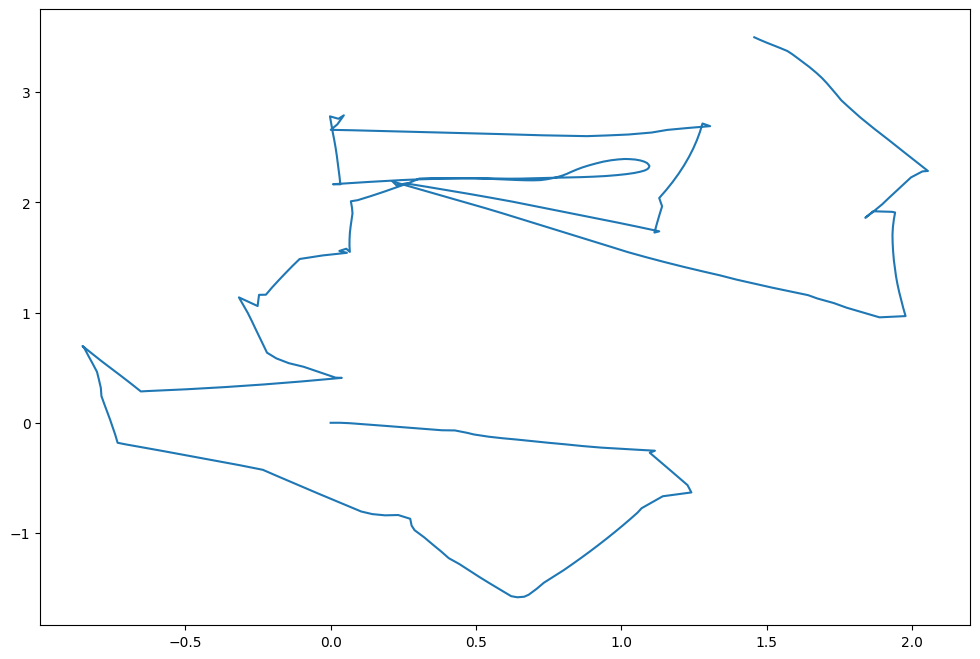

In [7]:
for i in range(10):
    windowSize = (i+1) * 5
    print(f"Running the algo for data {dataPath} with window size {windowSize}")
    results = run_algo(dataPath,windowSize)
    npFile = f'results/{dataName}_window{windowSize}.npy'
    # np.save(npFile,results)
    
    plt.plot(results[:,0],results[:,1])
    plt.show()
    break

### Run for all files

In [28]:
windowSize=30
for name in dataset:
    print("-"*100)
    path = dataset[name]
    npFile = f'results/{name}_window{windowSize}.npy'
    print(f"Data source = {name} \nResults file = {npFile}")

    results = run_algo(path)
    np.save(npFile,results)

----------------------------------------------------------------------------------------------------
Data source = /media/ajax/AJ/ground-slam/workroom_linoleum/test_path2/210806/seq0080/ 
Results file = results/workroom_linoleum_test_path2_window30.npy
Loading system...
Loading images...
Found 293 Images with shape (1200, 1600)
here
----------------------------------------------------------------------------------------------------
Data source = /media/ajax/AJ/ground-slam/workroom_linoleum/test_path4/210806/seq0082/ 
Results file = results/workroom_linoleum_test_path4_window30.npy
Loading system...
Loading images...
Found 457 Images with shape (1200, 1600)
here
----------------------------------------------------------------------------------------------------
Data source = /media/ajax/AJ/ground-slam/workroom_linoleum/test_path5/210806/seq0083/ 
Results file = results/workroom_linoleum_test_path5_window30.npy
Loading system...
Loading images...
Found 504 Images with shape (1200, 1600)


----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path2, window size = 10
here
Elapsed time: 11.81 seconds


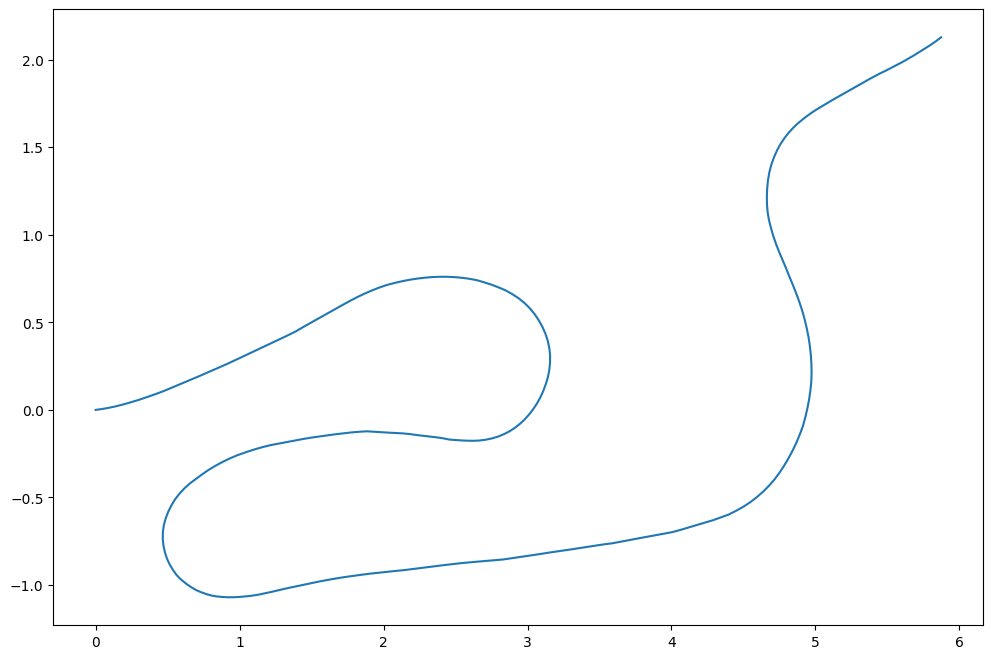

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path2, window size = 20
here
Elapsed time: 11.77 seconds


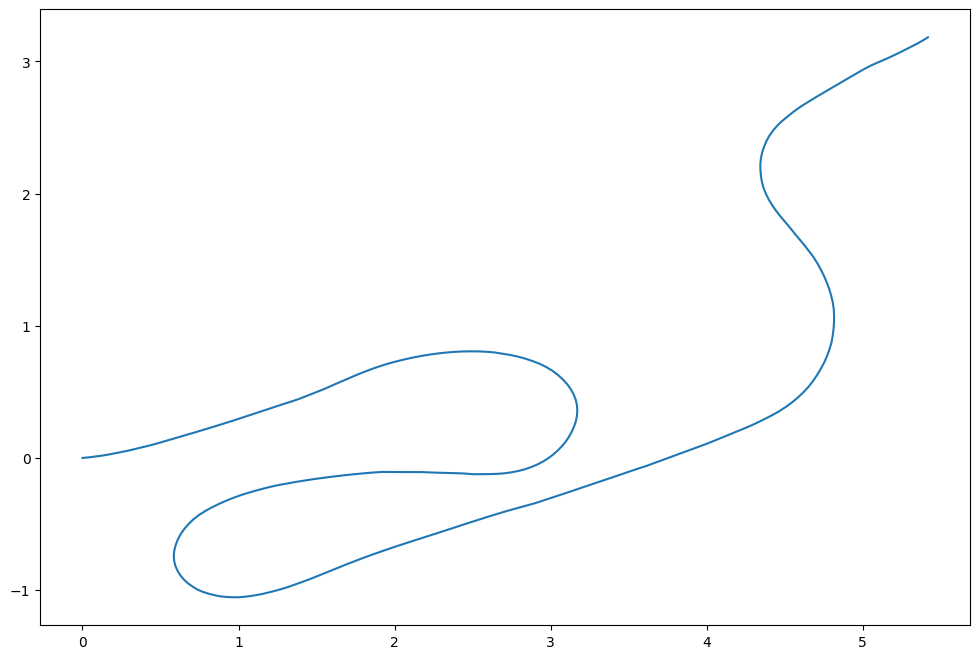

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path2, window size = 30
here
Elapsed time: 9.98 seconds


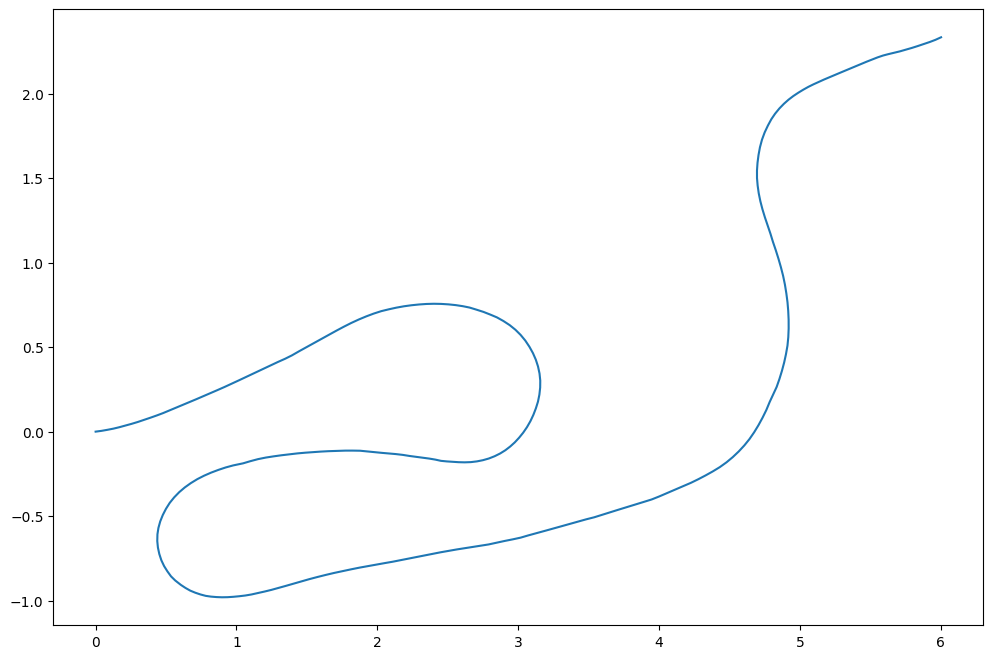

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path2, window size = 40
here
Elapsed time: 10.02 seconds


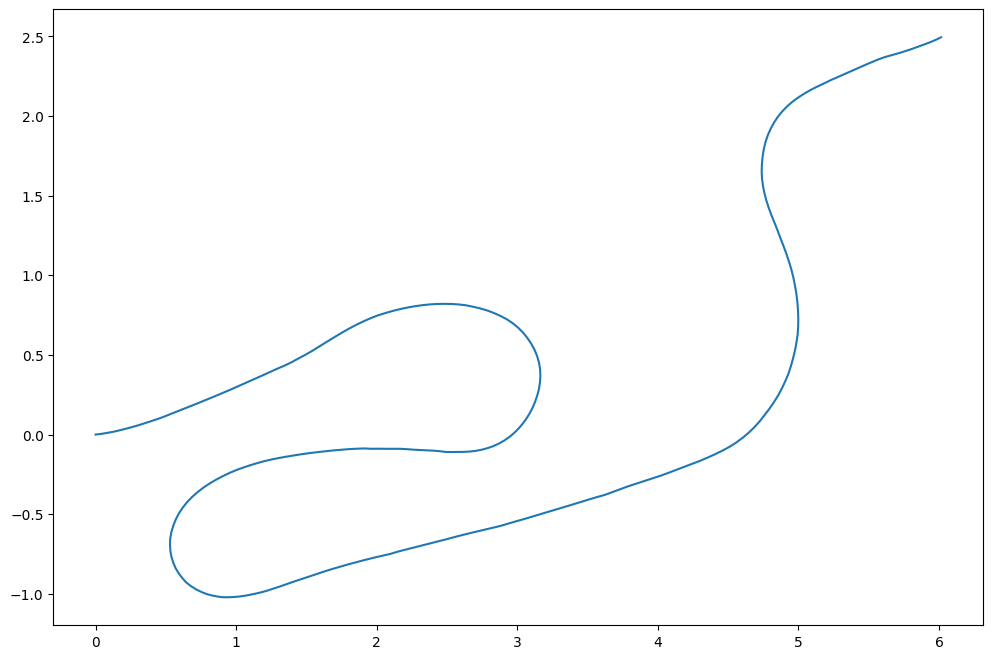

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path2, window size = 50
here
Elapsed time: 9.99 seconds


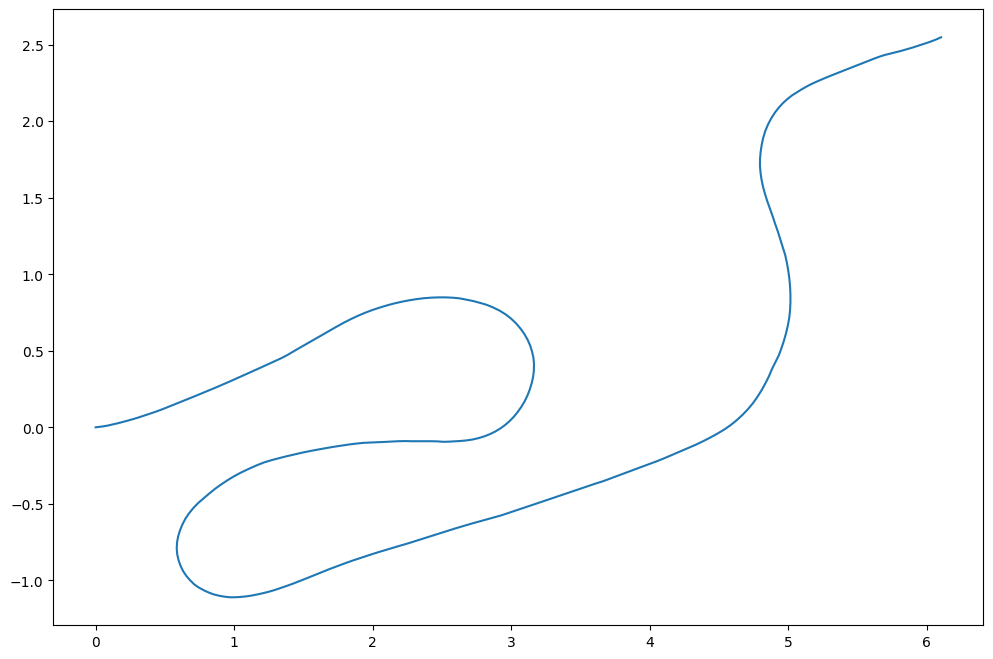

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path4, window size = 10
here
Elapsed time: 110.58 seconds


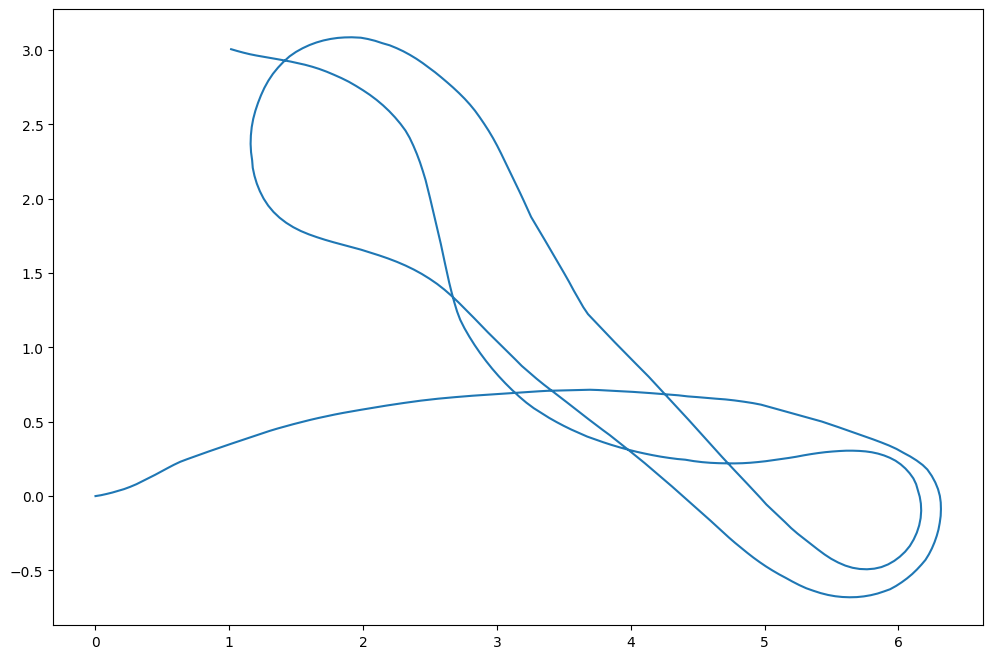

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path4, window size = 20
here
Elapsed time: 14.77 seconds


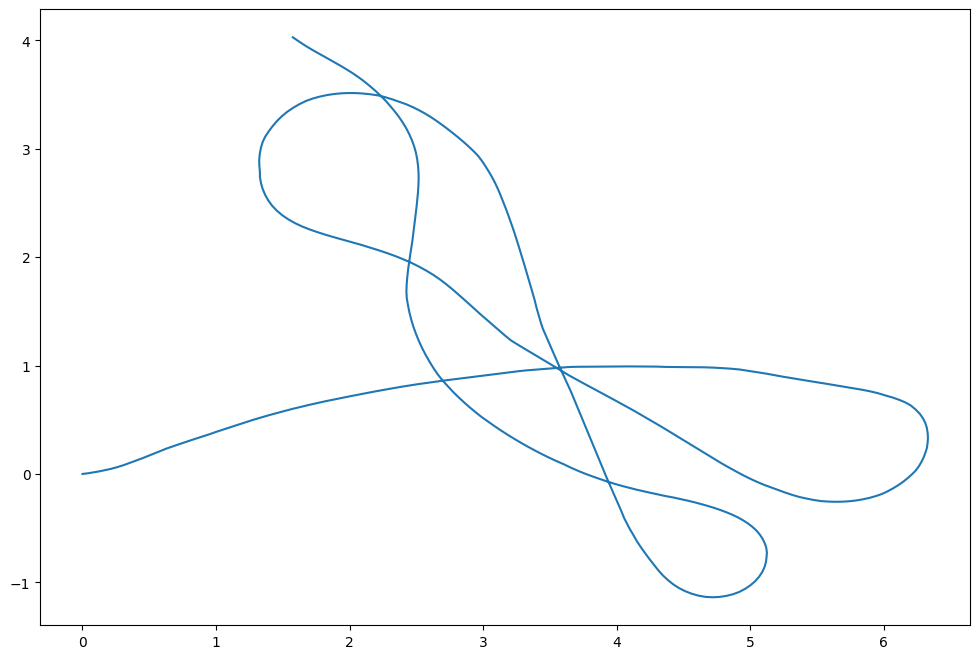

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path4, window size = 30
here
Elapsed time: 15.12 seconds


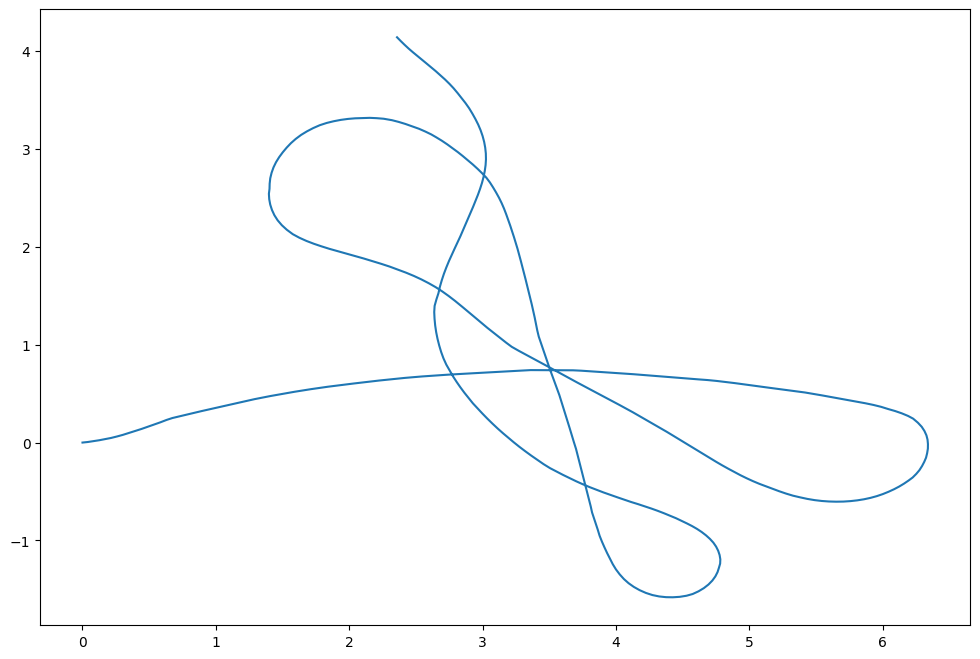

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path4, window size = 40
here
Elapsed time: 15.41 seconds


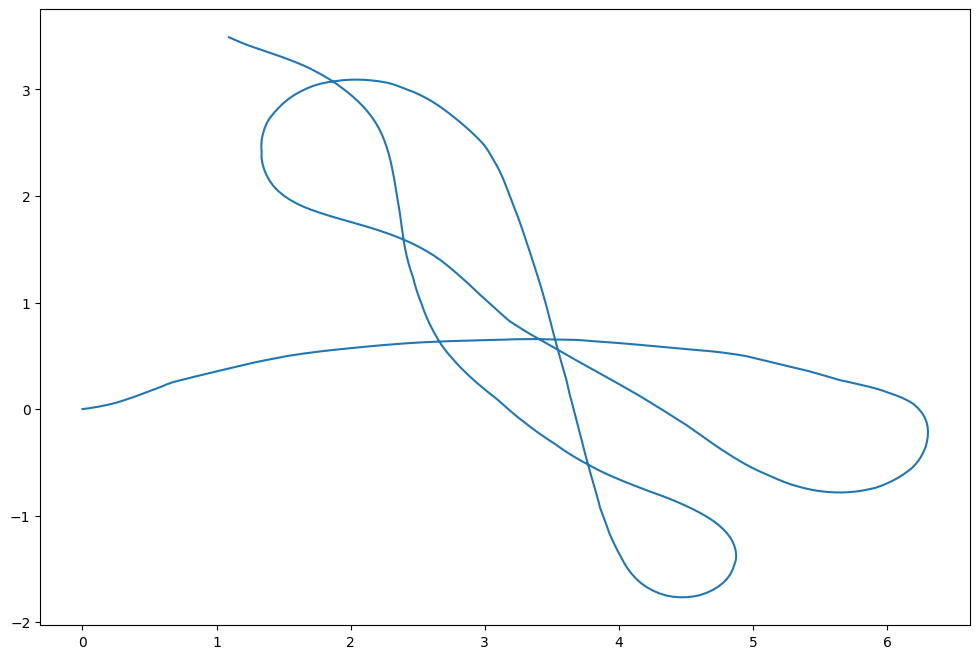

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path4, window size = 50
here
Elapsed time: 15.68 seconds


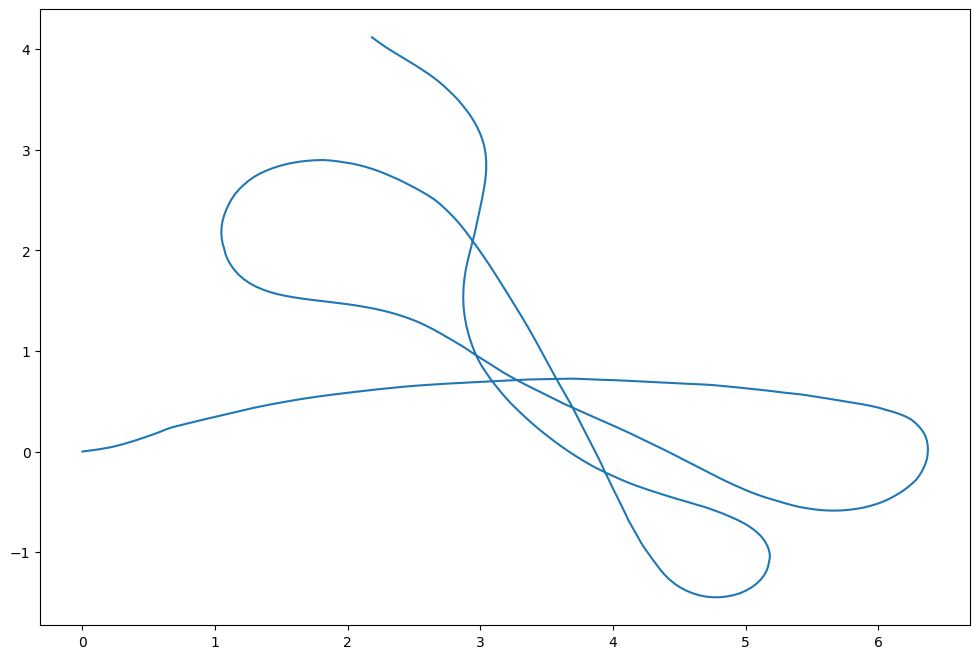

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path5, window size = 10
here
Elapsed time: 120.62 seconds


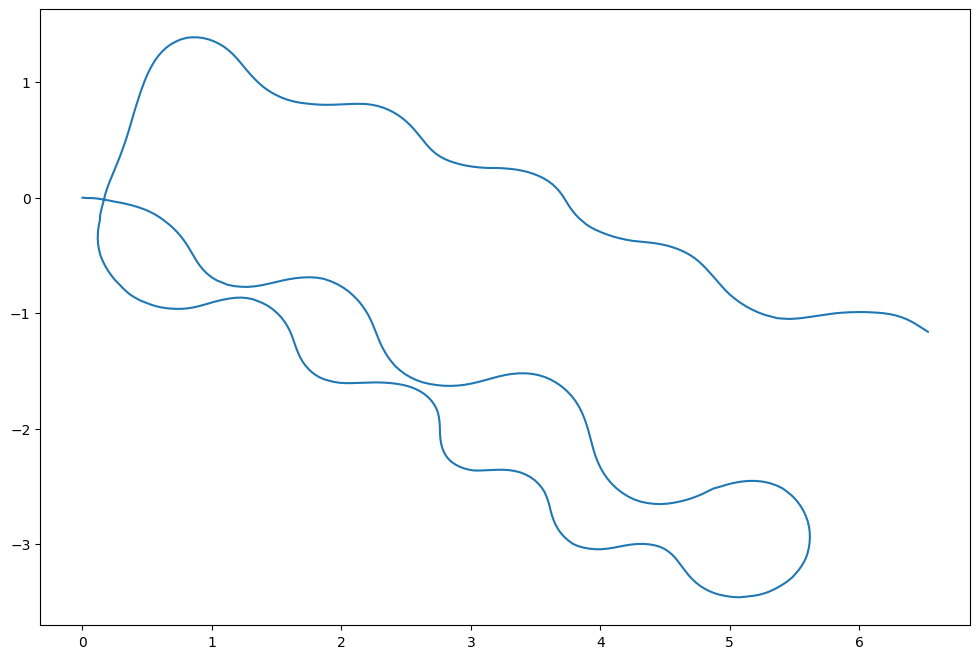

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path5, window size = 20
here
Elapsed time: 19.30 seconds


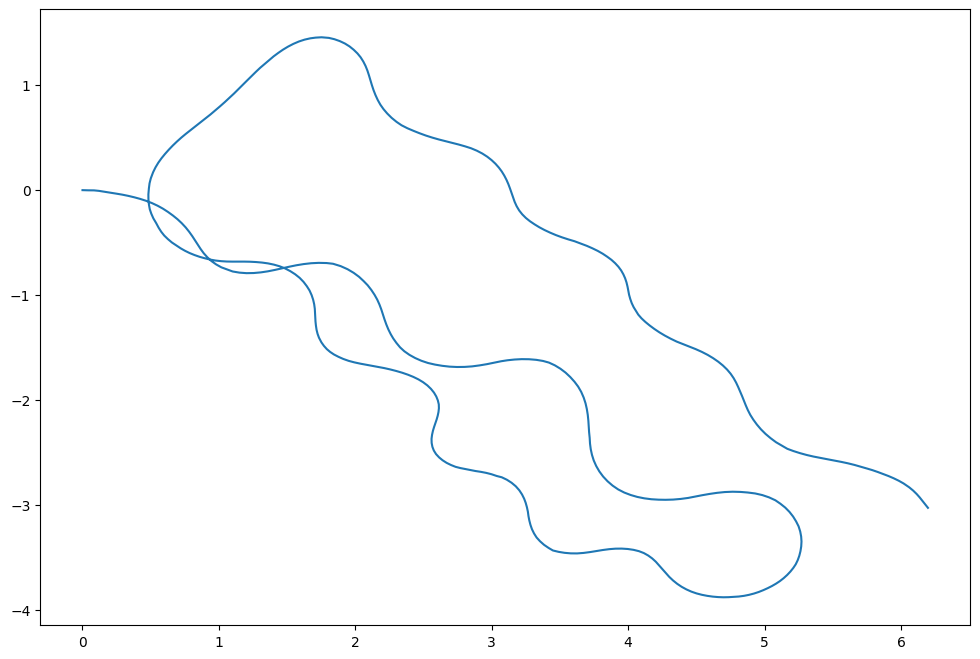

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path5, window size = 30
here
Elapsed time: 20.26 seconds


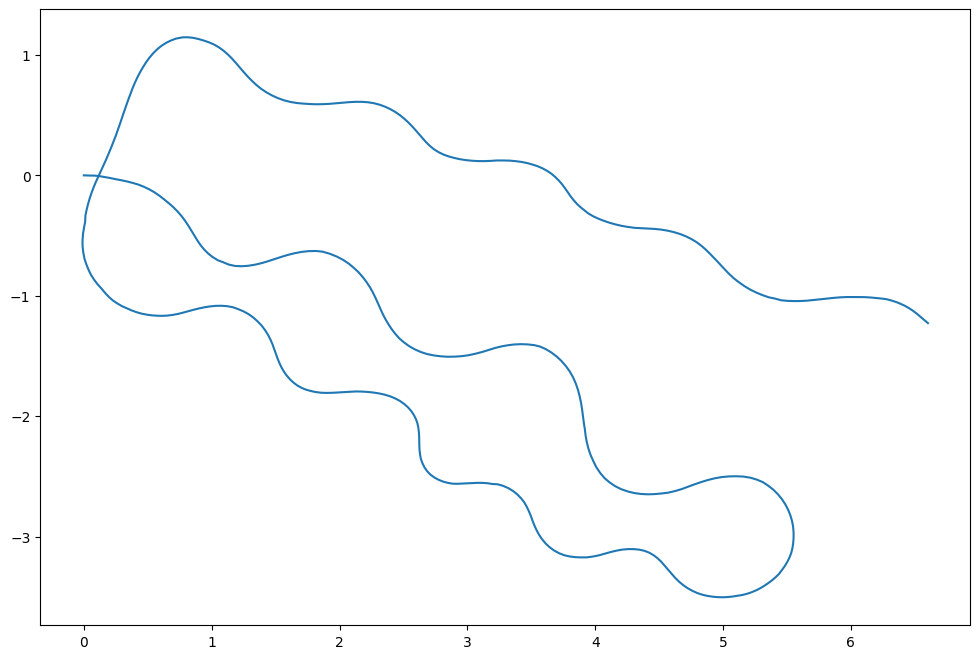

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path5, window size = 40
here
Elapsed time: 20.13 seconds


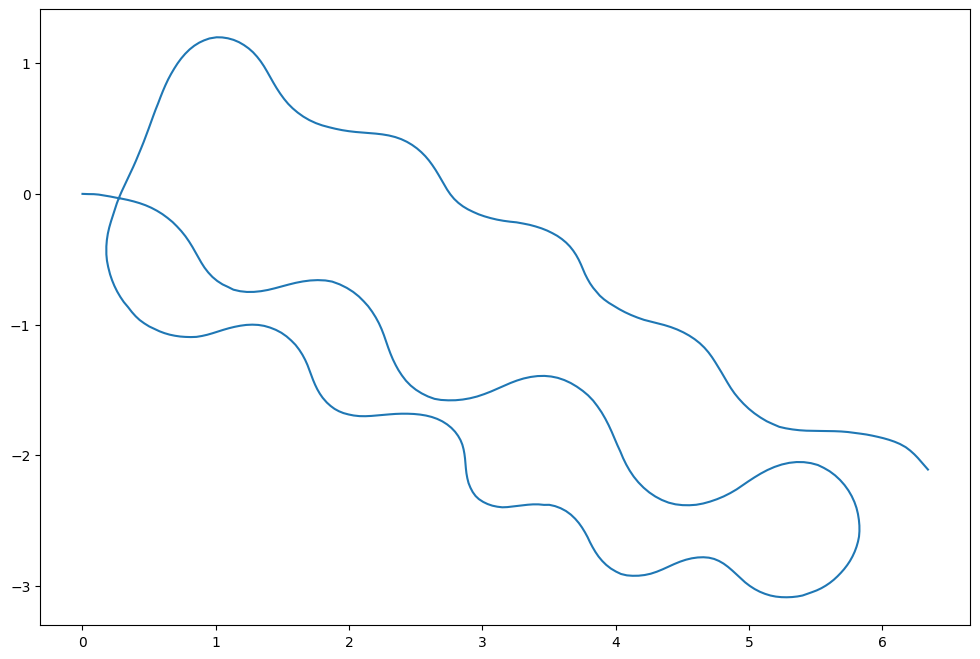

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path5, window size = 50
here
Elapsed time: 20.49 seconds


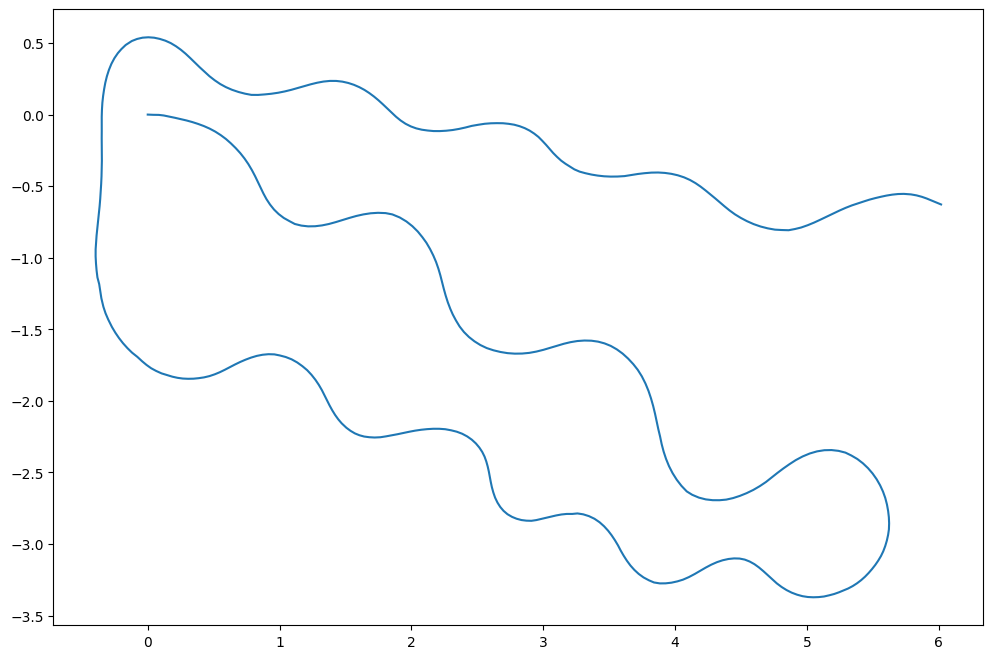

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path6, window size = 10
here
Elapsed time: 132.82 seconds


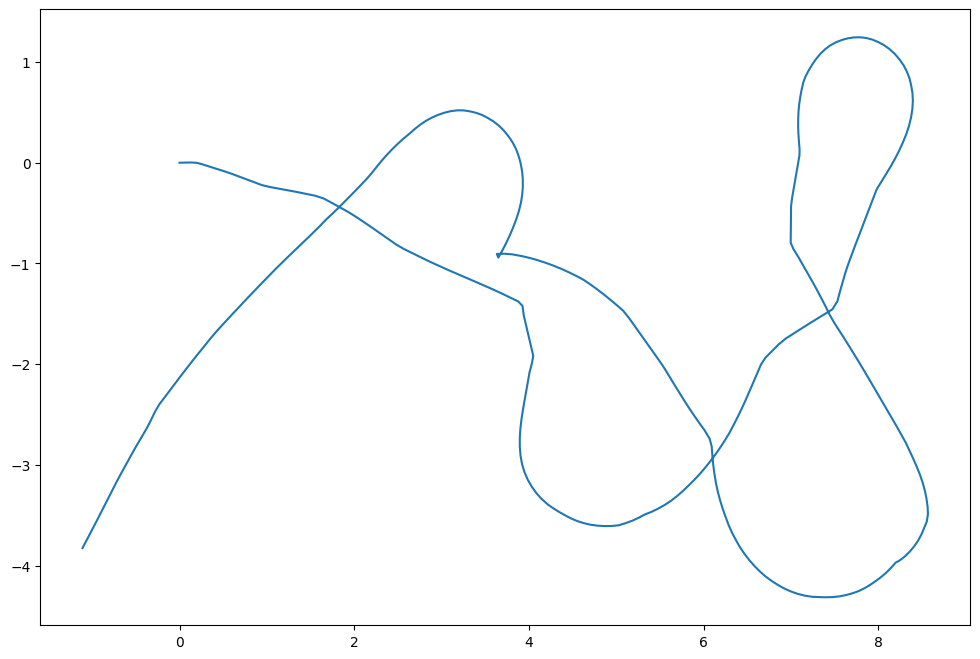

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path6, window size = 20
here
Elapsed time: 12.92 seconds


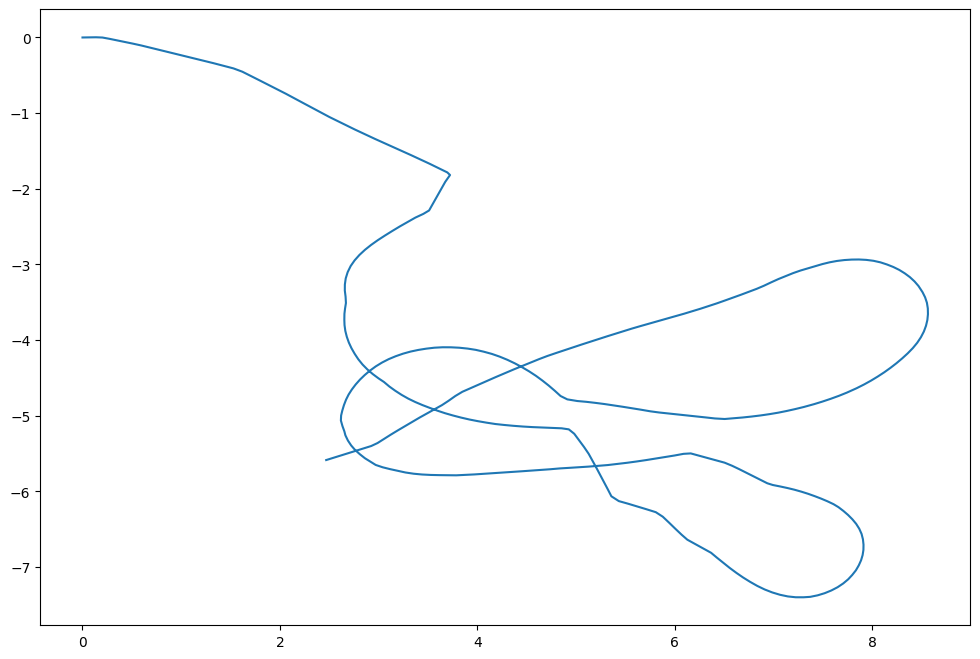

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path6, window size = 30
here
Elapsed time: 13.97 seconds


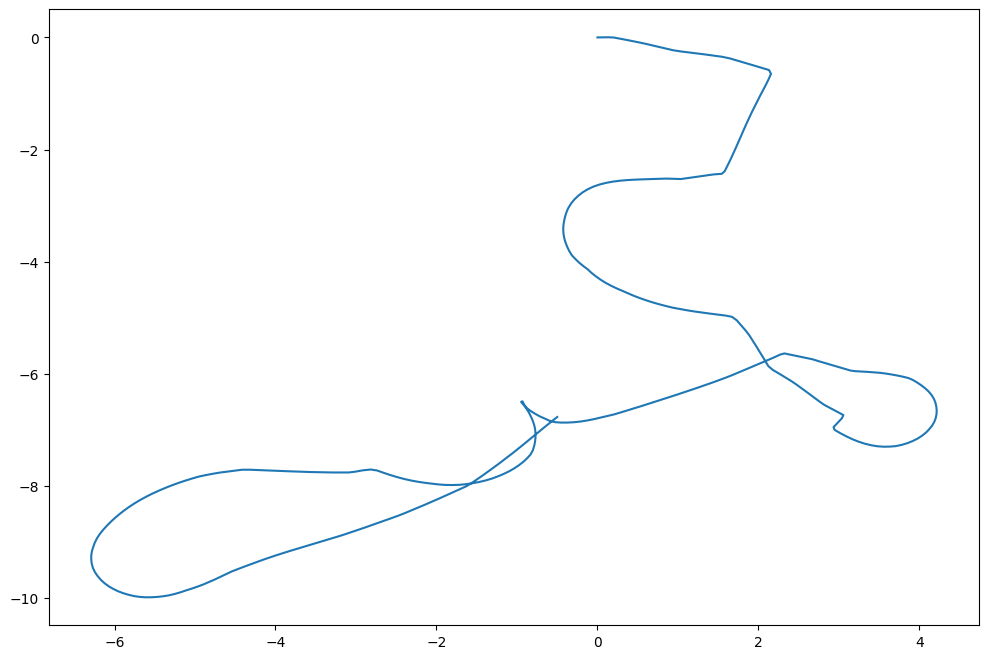

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path6, window size = 40
here
Elapsed time: 13.96 seconds


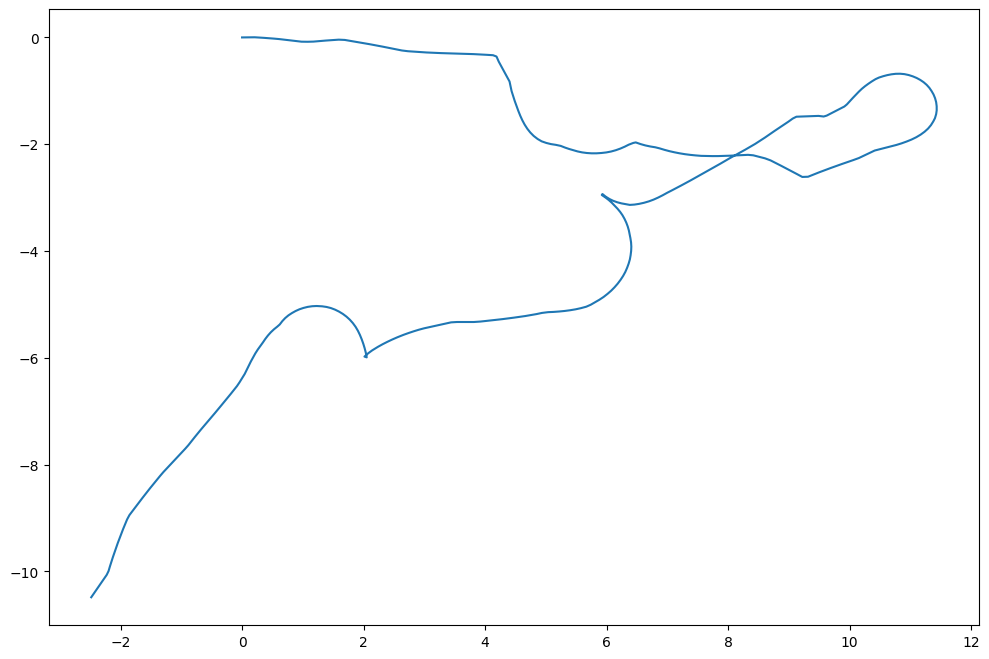

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path6, window size = 50
here
Elapsed time: 13.96 seconds


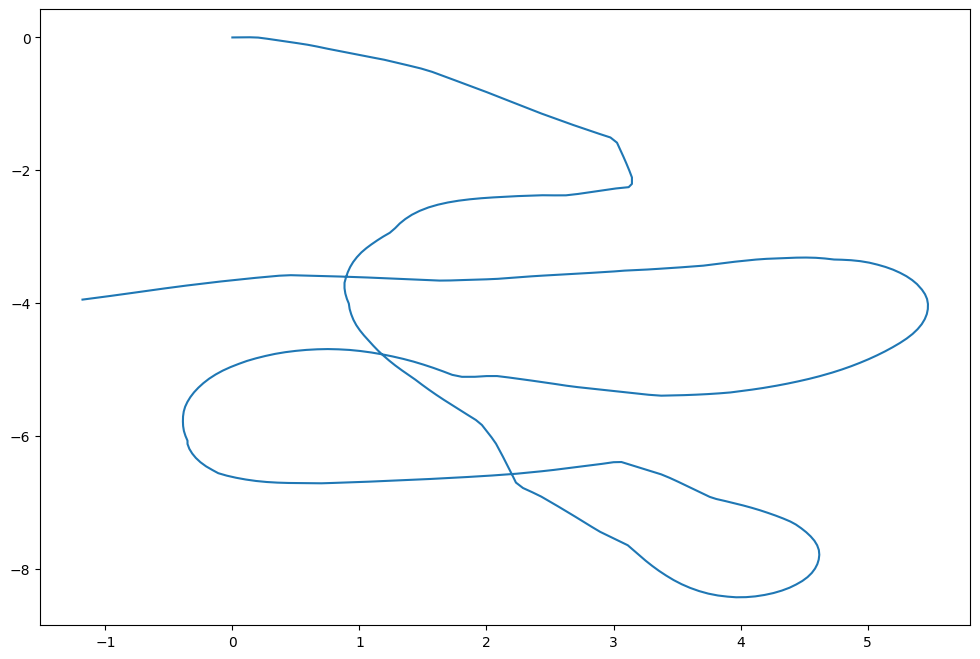

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path1, window size = 10
here
Elapsed time: 43.39 seconds


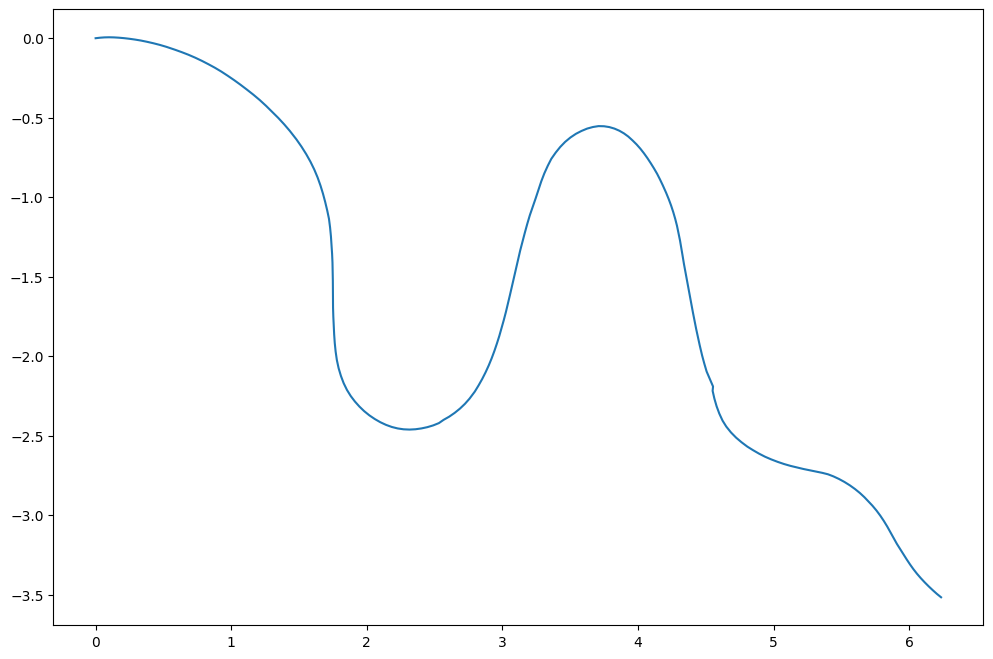

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path1, window size = 20
here
Elapsed time: 7.10 seconds


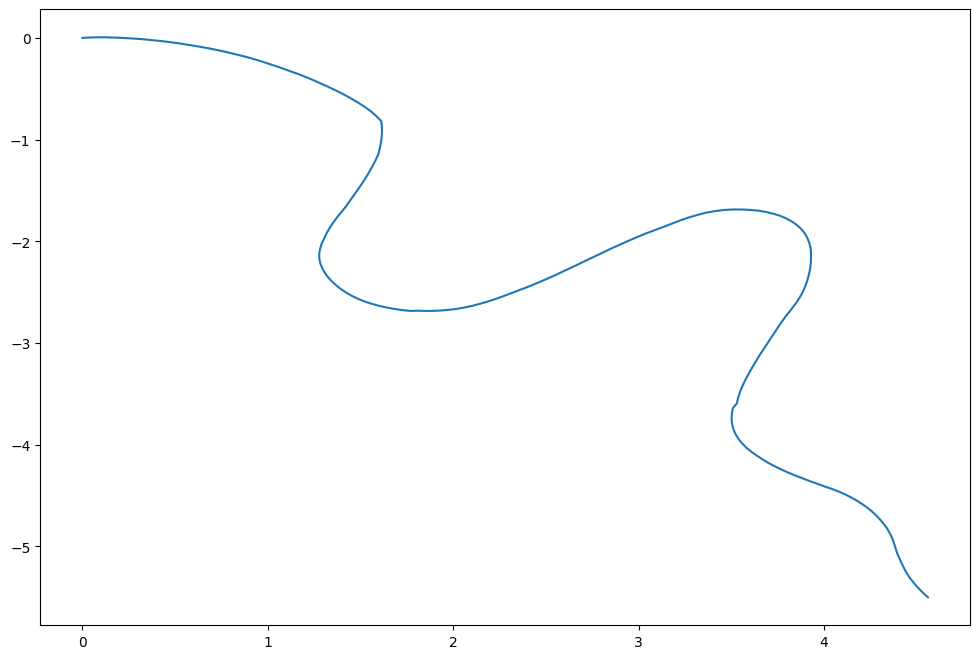

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path1, window size = 30
here
Elapsed time: 7.40 seconds


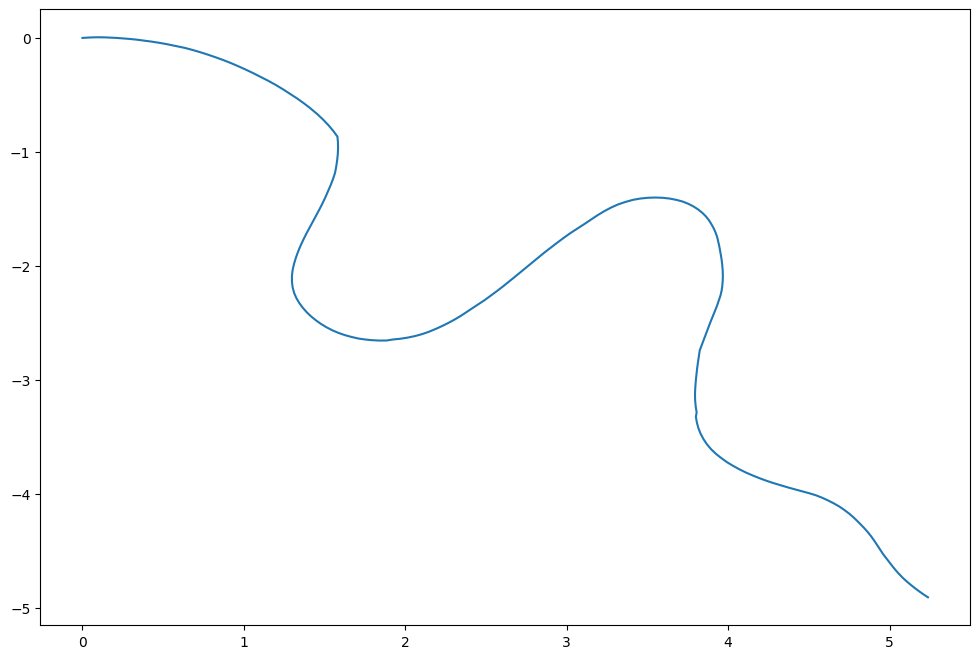

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path1, window size = 40
here
Elapsed time: 8.49 seconds


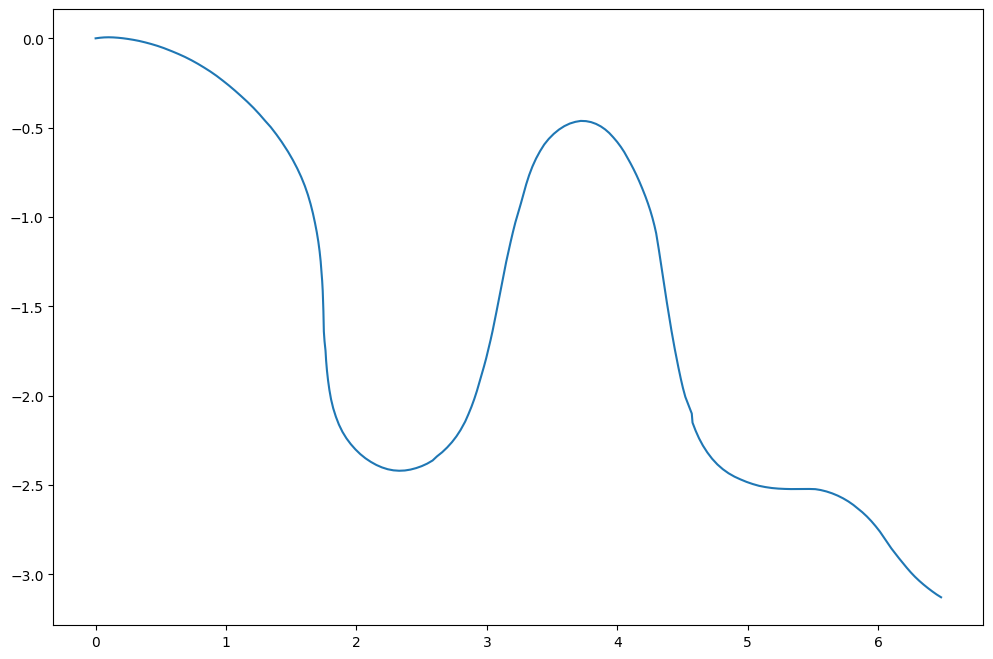

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path1, window size = 50
here
Elapsed time: 8.56 seconds


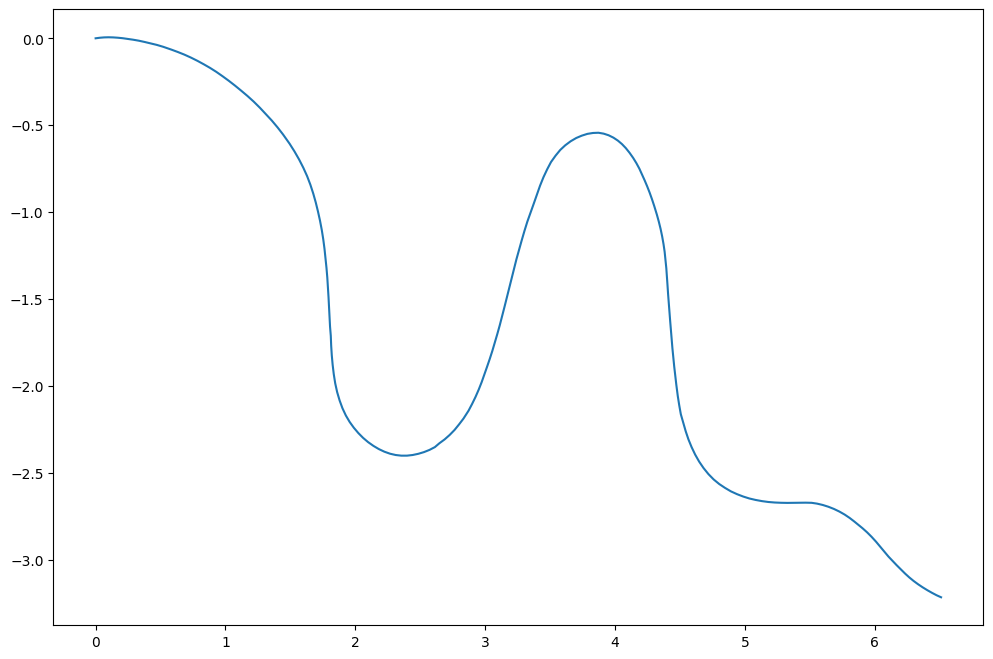

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path3, window size = 10
here
Elapsed time: 98.83 seconds


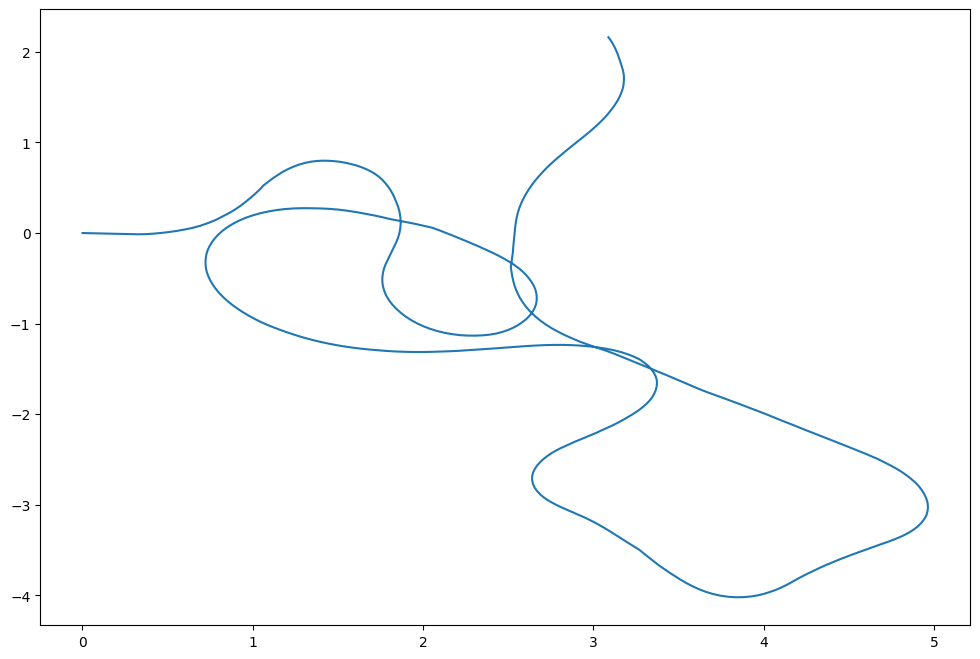

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path3, window size = 20
here
Elapsed time: 18.49 seconds


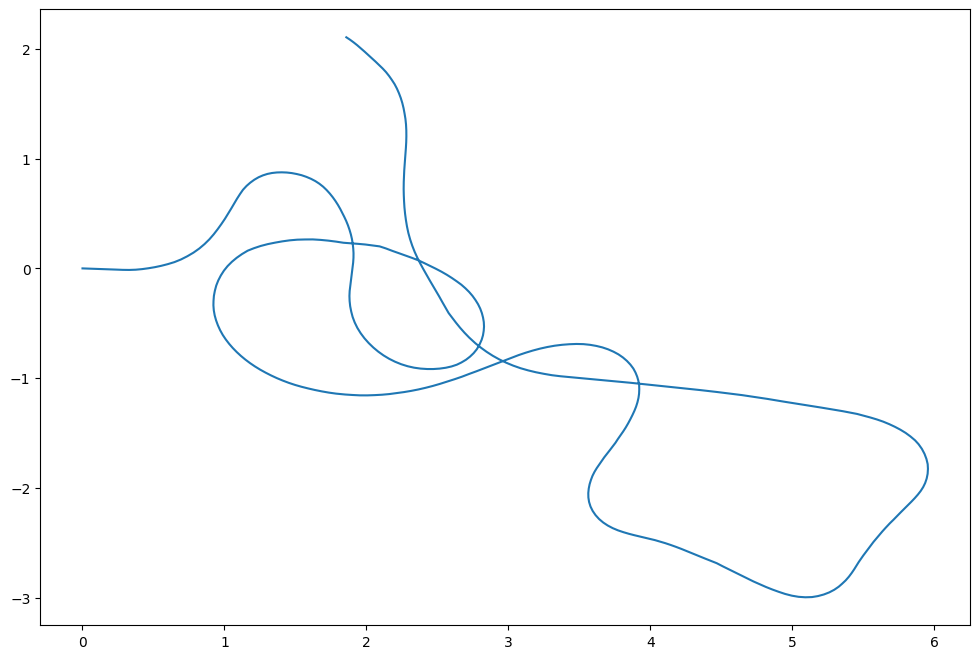

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path3, window size = 30
here
Elapsed time: 18.49 seconds


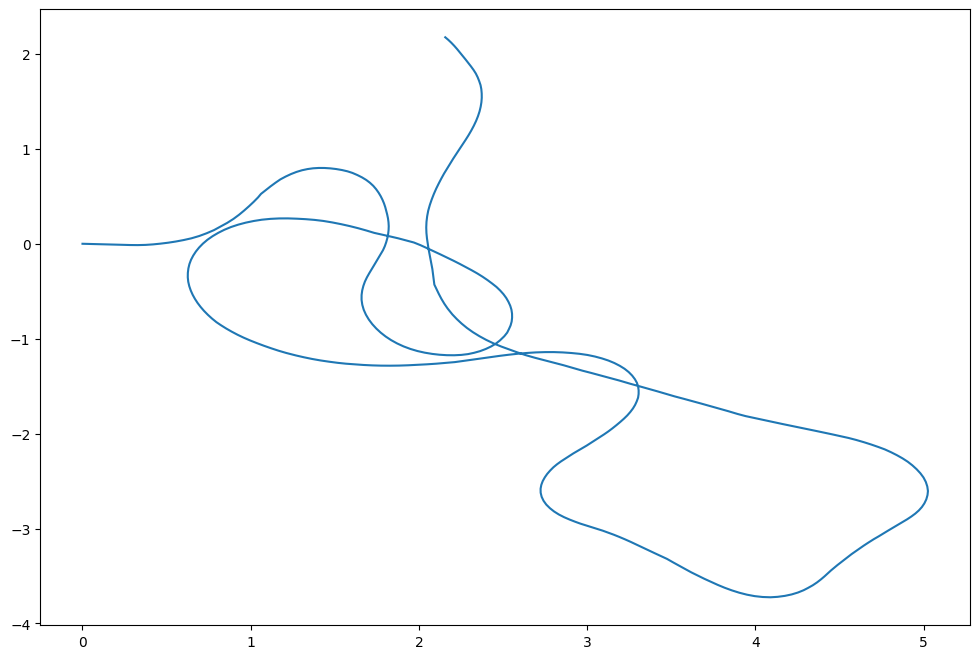

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path3, window size = 40
here
Elapsed time: 18.52 seconds


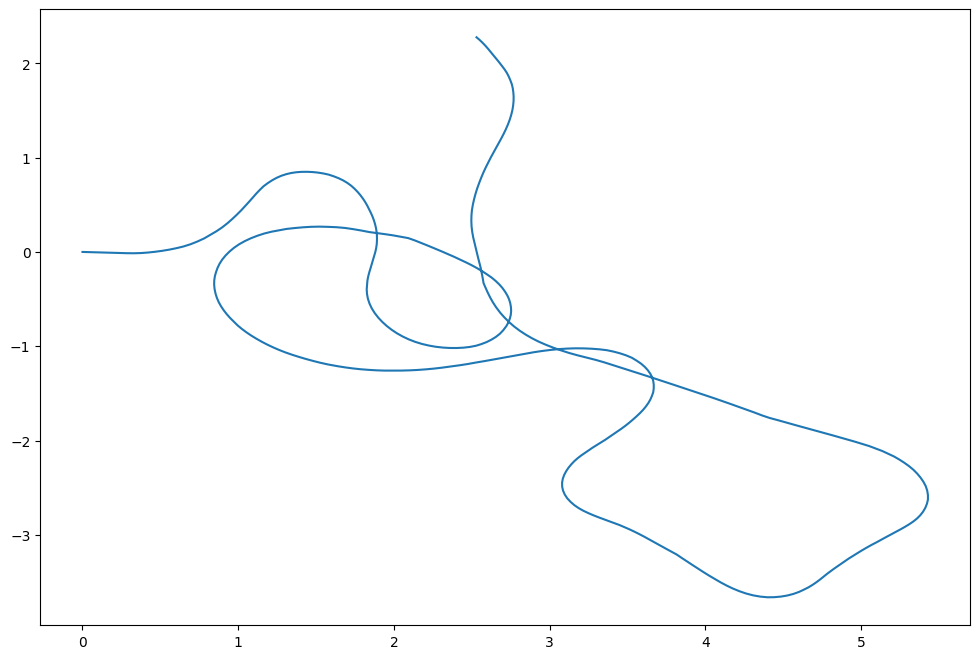

----------------------------------------------------------------------------------------------------
Working on = workroom_linoleum_test_path3, window size = 50
here
Elapsed time: 18.63 seconds


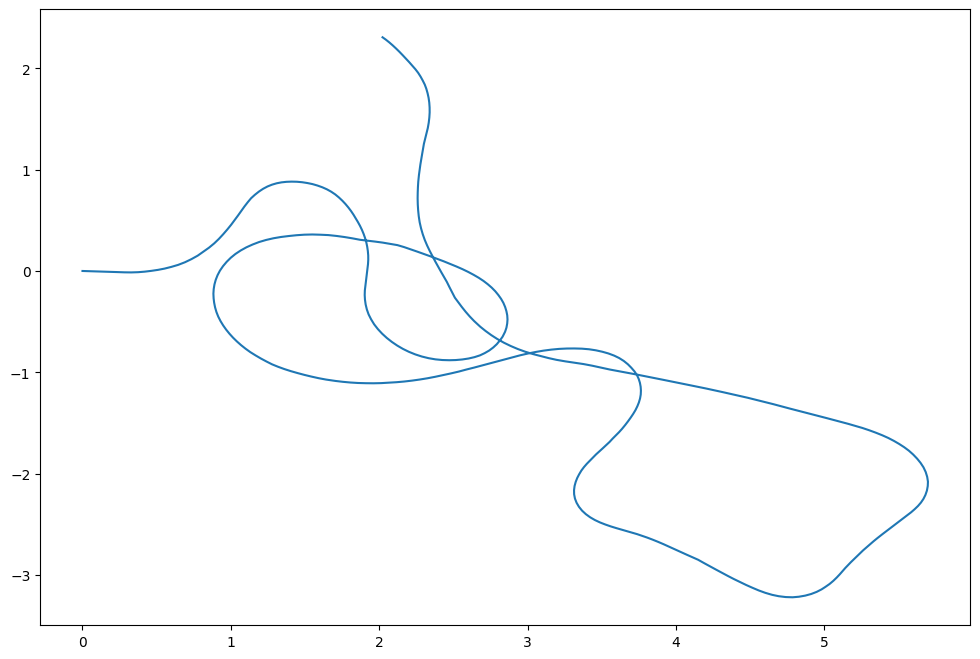

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path5, window size = 10
here
Elapsed time: 163.30 seconds


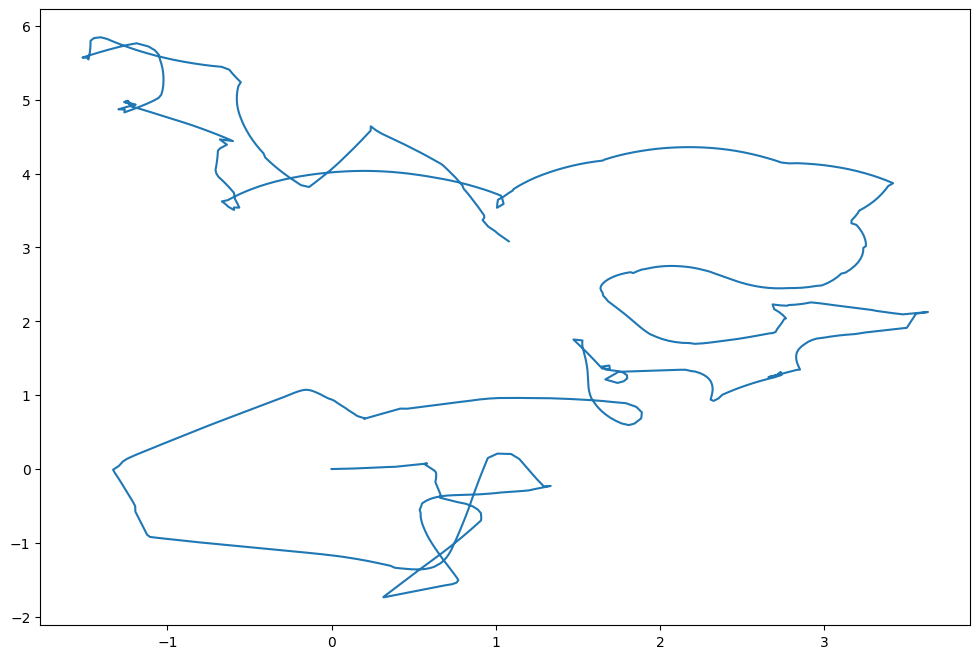

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path5, window size = 20
here
Elapsed time: 24.97 seconds


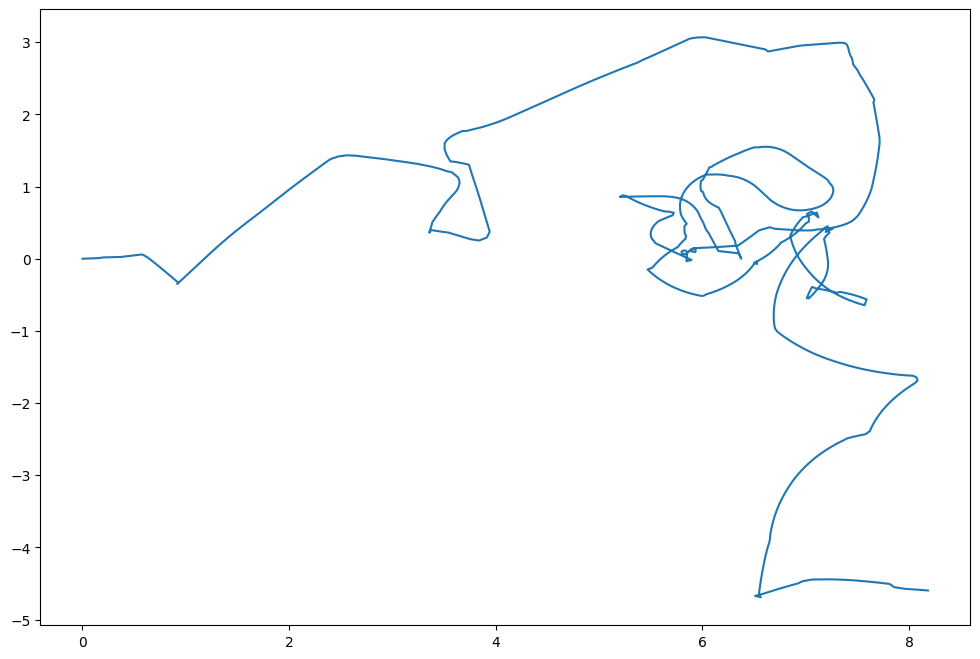

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path5, window size = 30
here
Elapsed time: 25.91 seconds


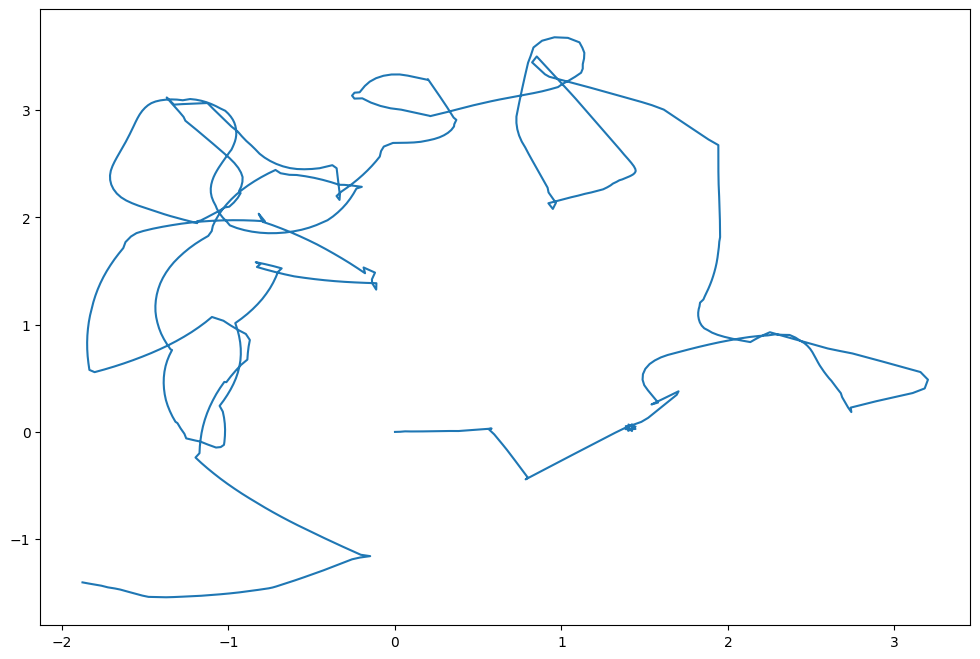

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path5, window size = 40
here
Elapsed time: 26.27 seconds


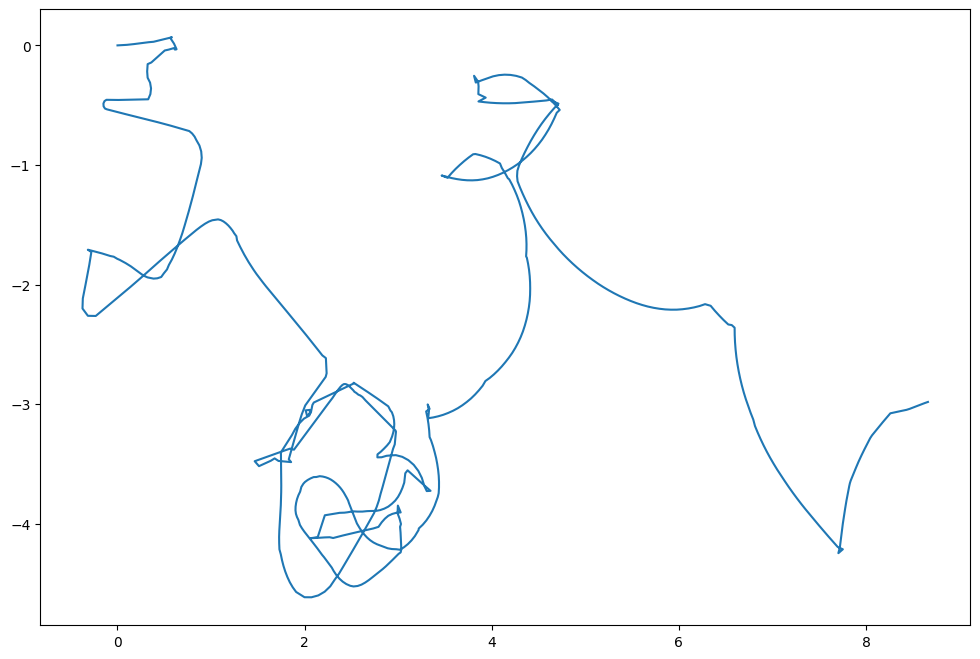

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path5, window size = 50
here
Elapsed time: 26.22 seconds


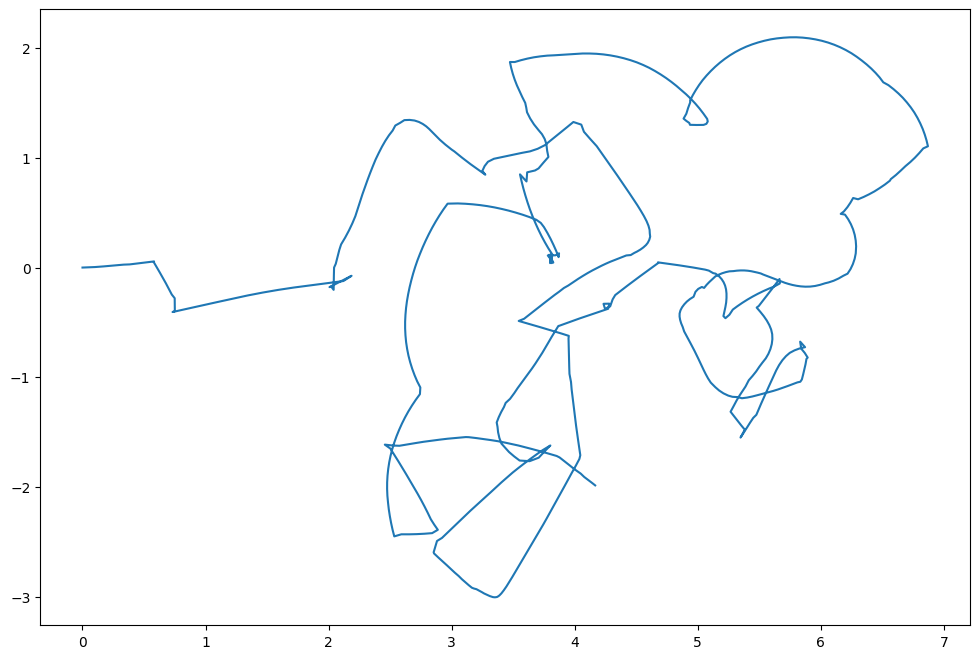

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path3, window size = 10
here
Elapsed time: 156.67 seconds


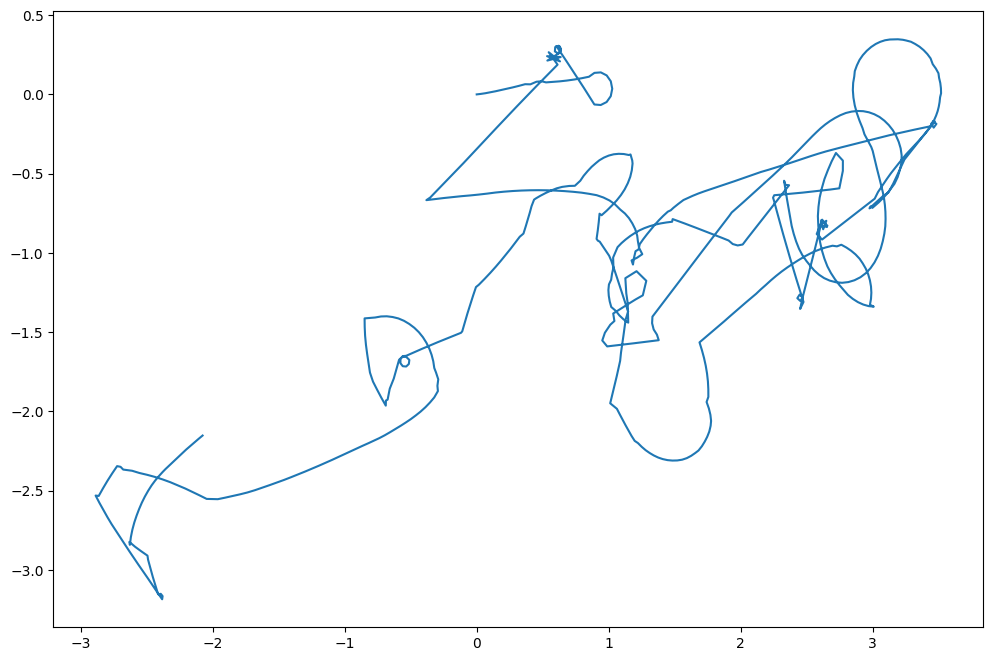

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path3, window size = 20
here
Elapsed time: 24.53 seconds


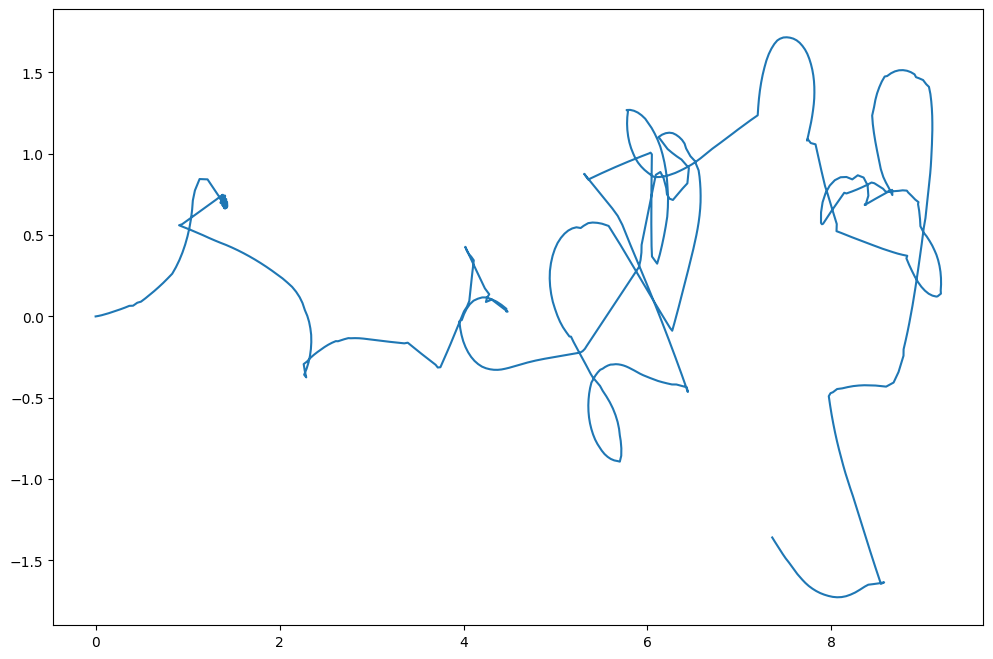

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path3, window size = 30
here
Elapsed time: 25.46 seconds


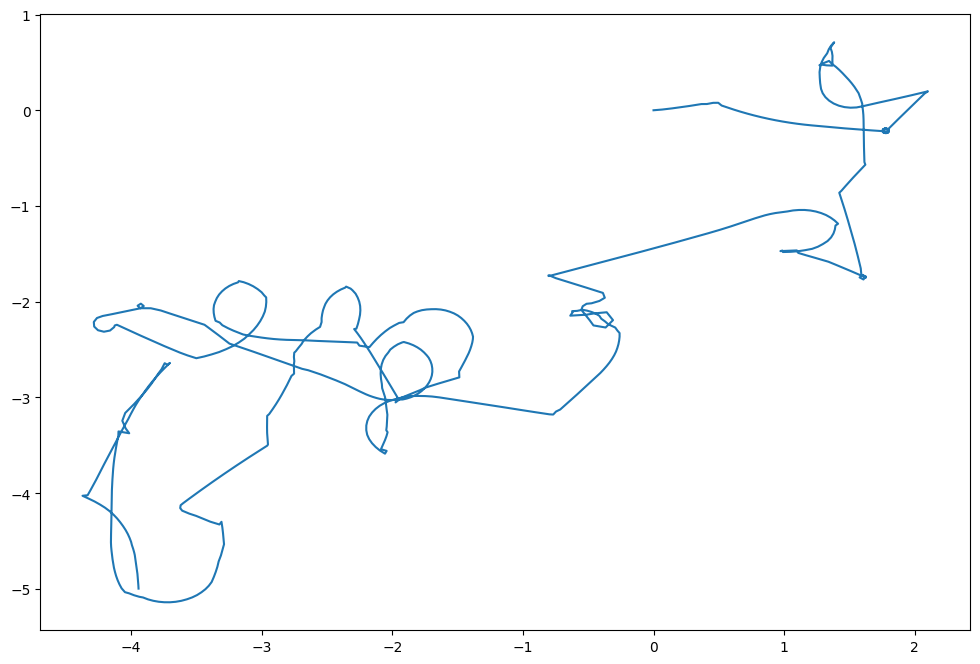

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path3, window size = 40
here
Elapsed time: 25.90 seconds


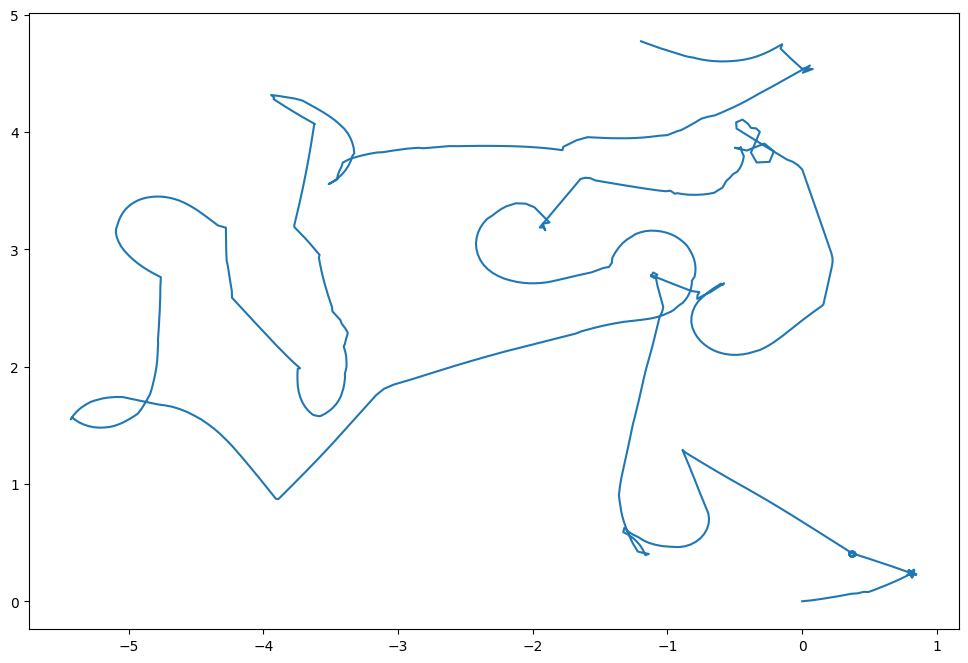

----------------------------------------------------------------------------------------------------
Working on = garage_concrete_test_path3, window size = 50
here
Elapsed time: 25.74 seconds


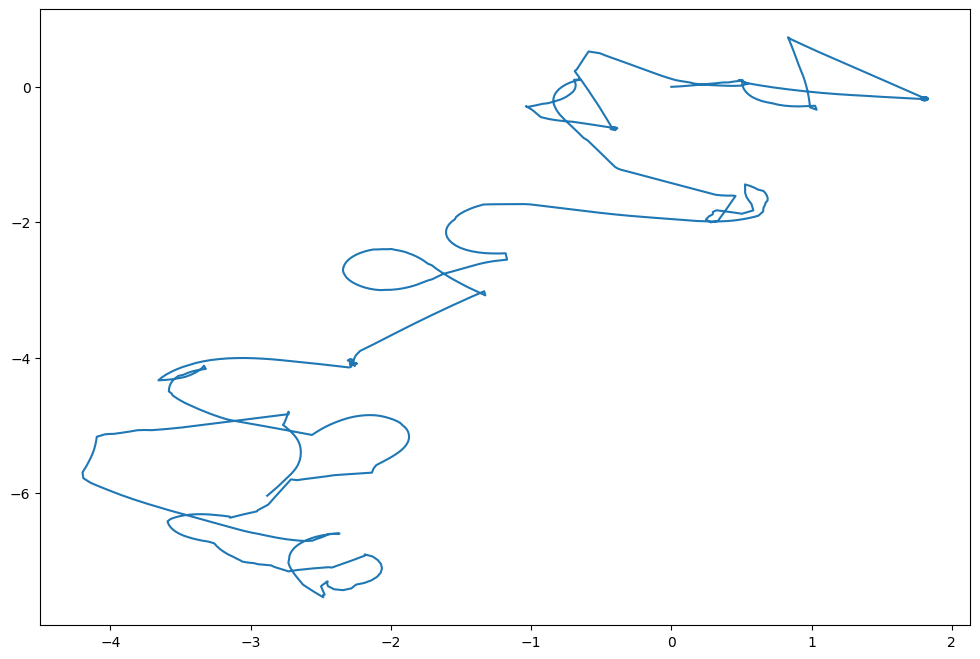

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path2, window size = 10
here
Elapsed time: 72.74 seconds


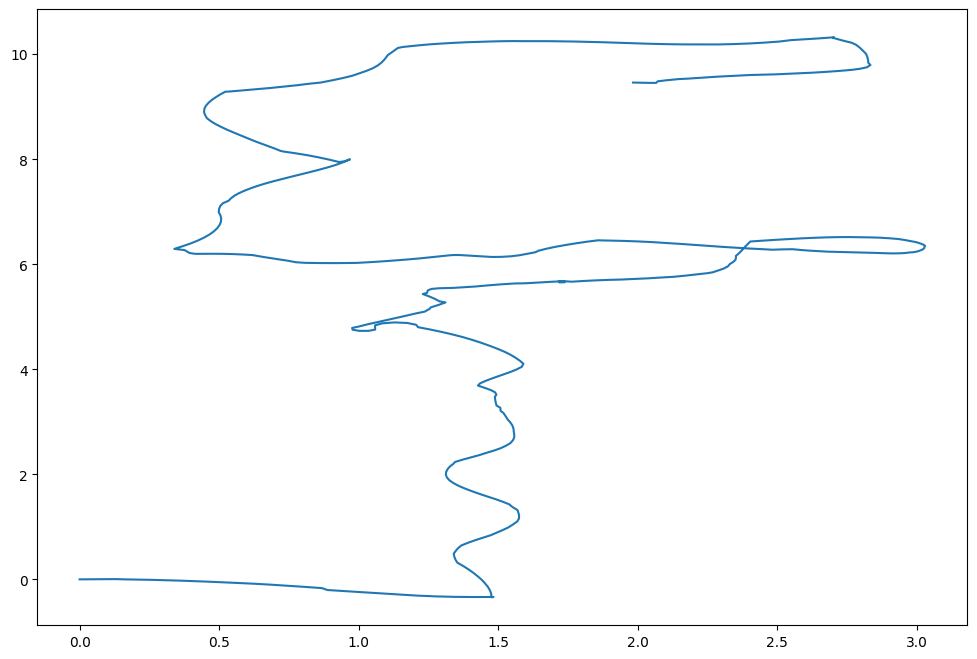

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path2, window size = 20
here
Elapsed time: 13.64 seconds


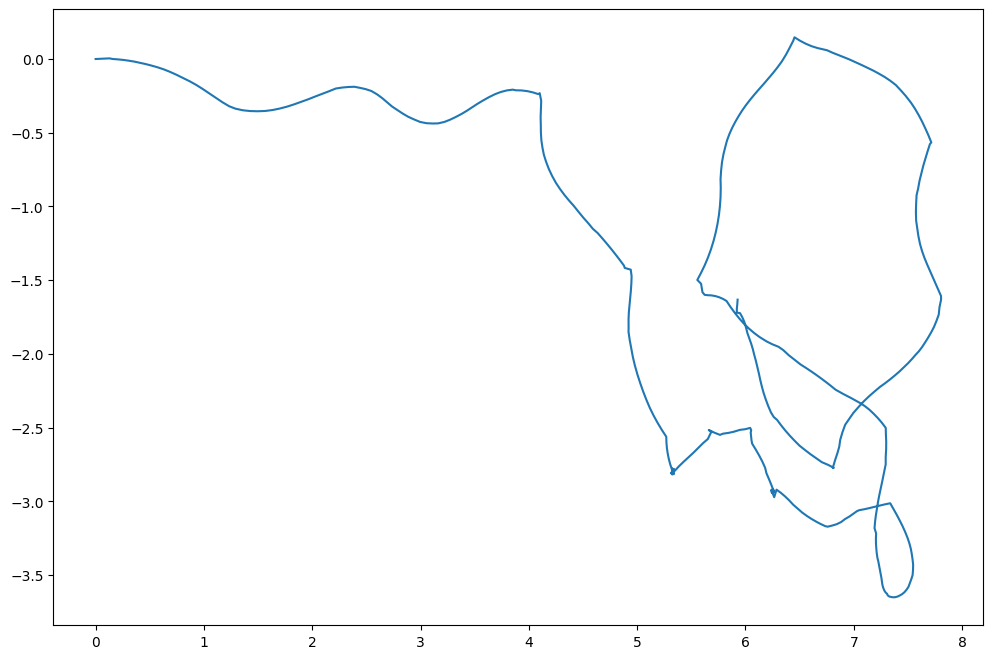

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path2, window size = 30
here
Elapsed time: 13.75 seconds


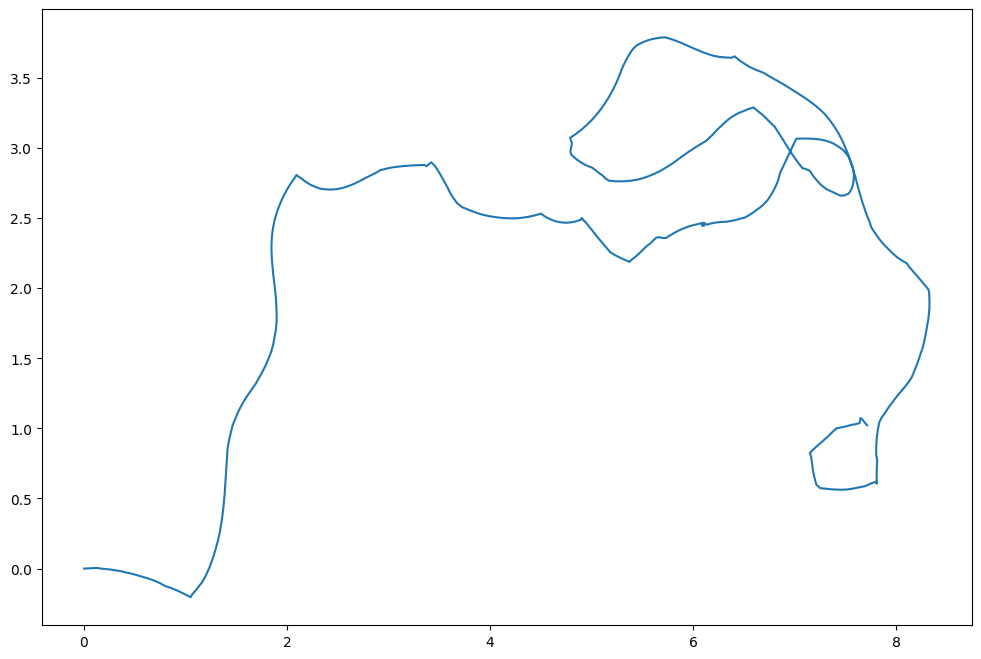

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path2, window size = 40
here
Elapsed time: 14.11 seconds


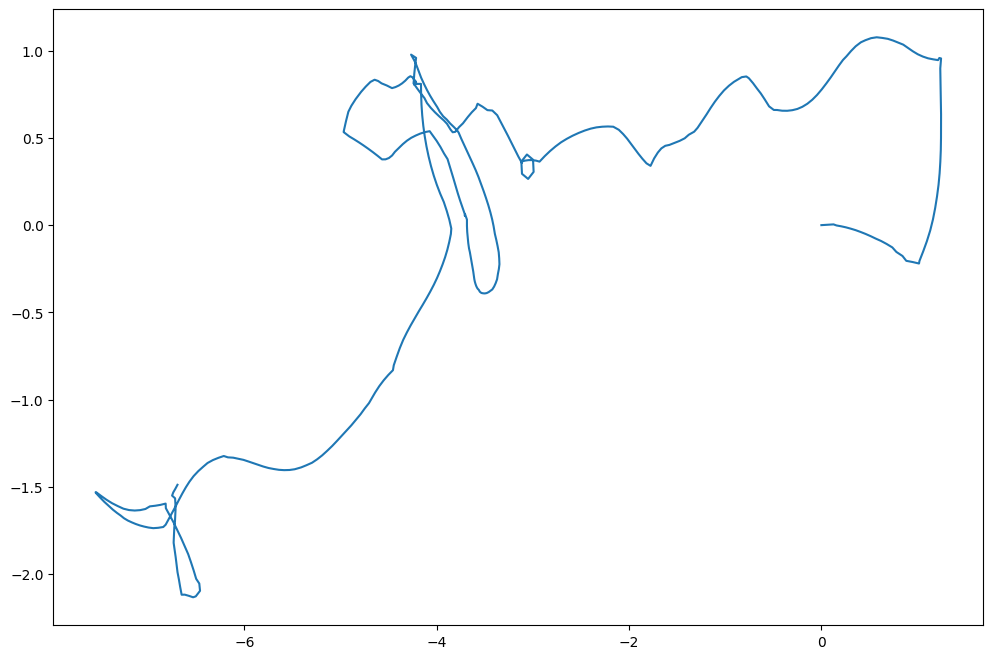

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path2, window size = 50
here
Elapsed time: 14.48 seconds


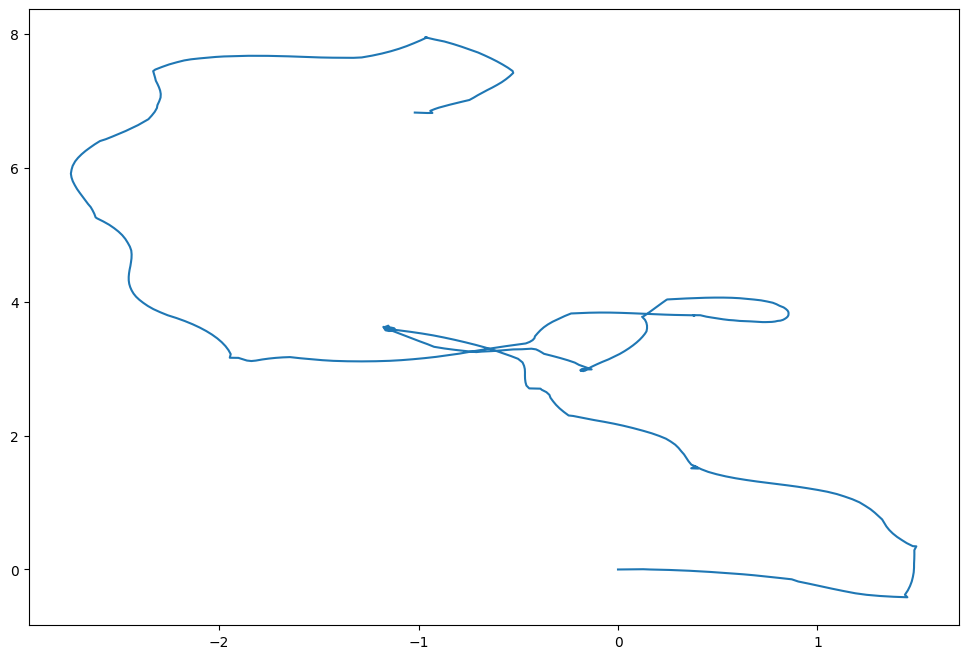

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path1, window size = 10
here
Elapsed time: 11.29 seconds


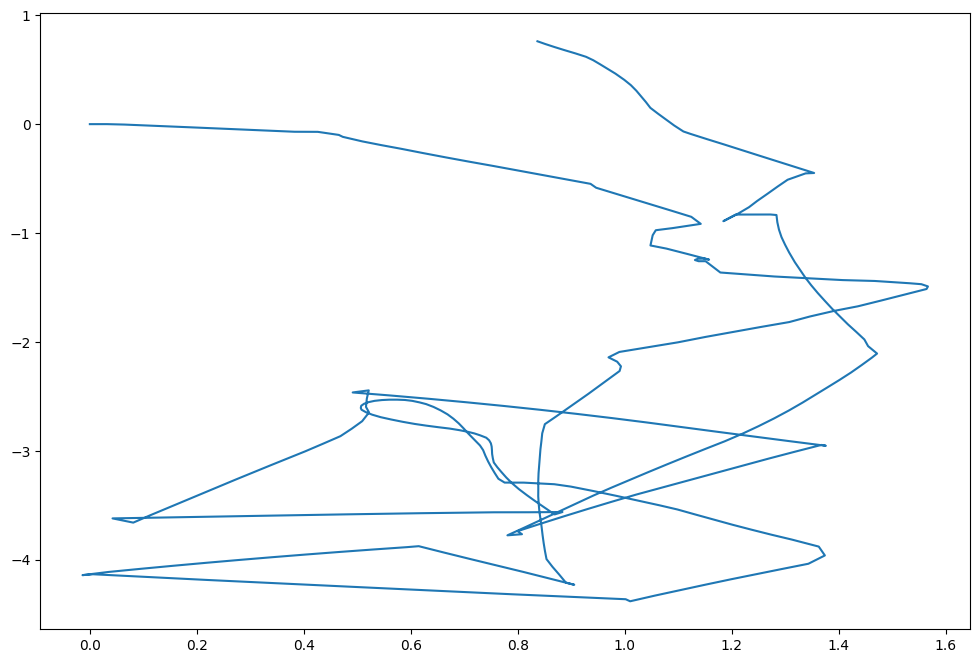

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path1, window size = 20
here
Elapsed time: 10.99 seconds


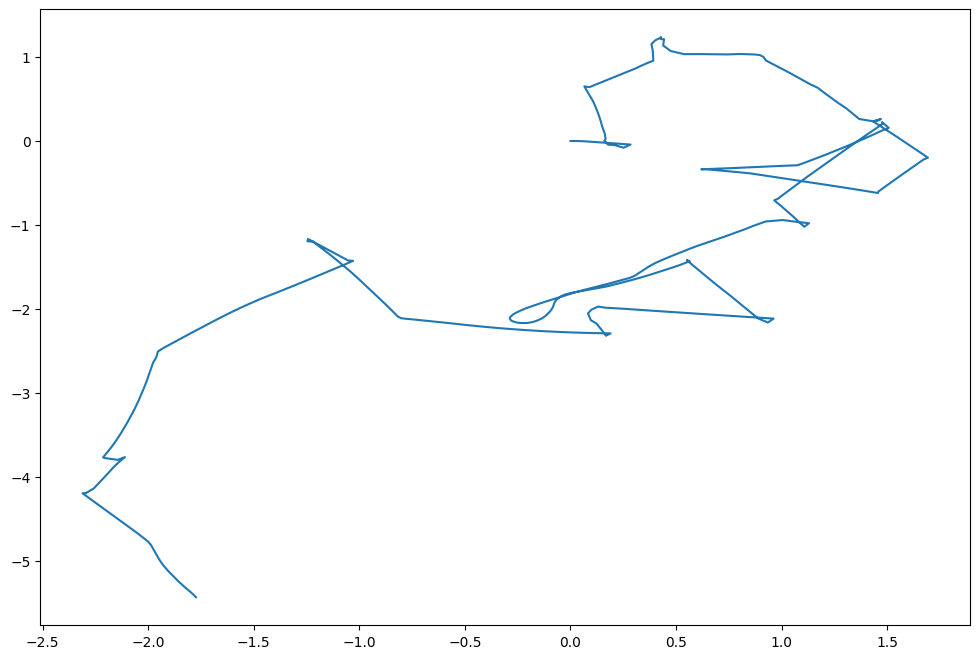

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path1, window size = 30
here
Elapsed time: 10.98 seconds


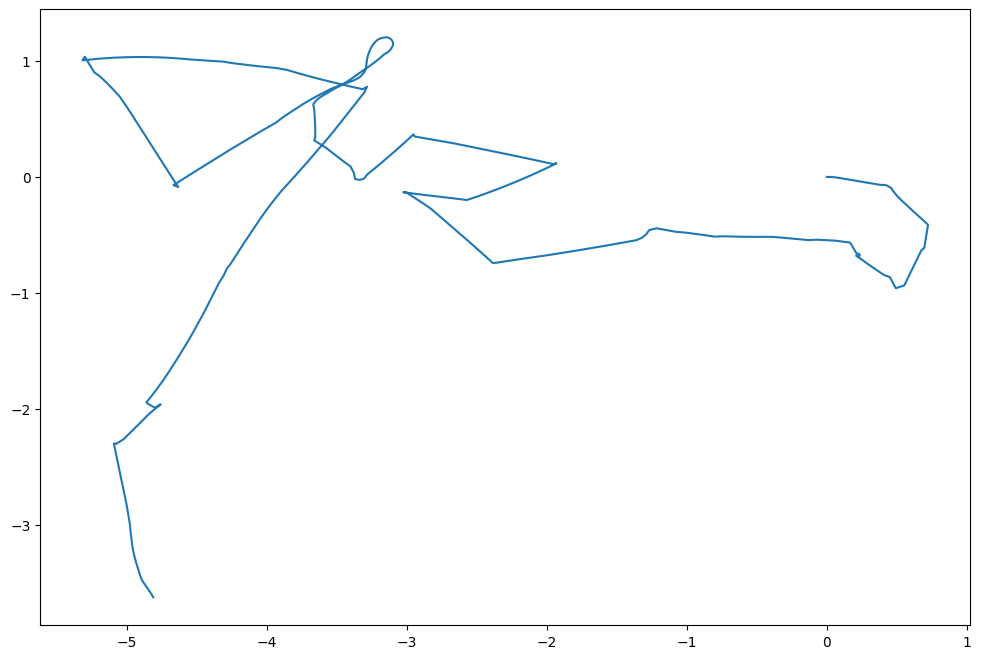

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path1, window size = 40
here
Elapsed time: 10.95 seconds


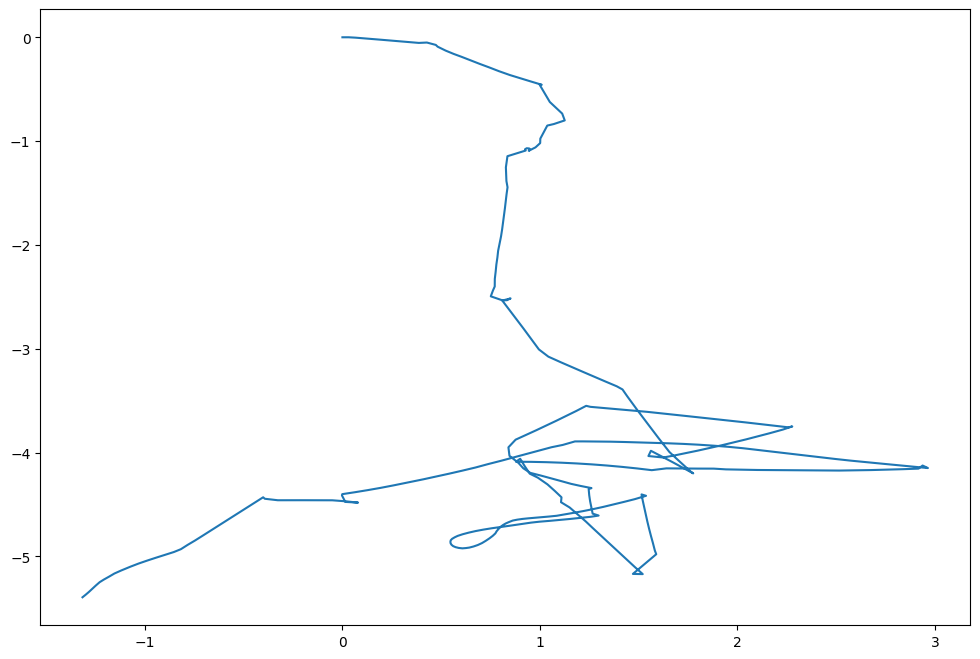

----------------------------------------------------------------------------------------------------
Working on = checker_plate_steel_test_path1, window size = 50
here
Elapsed time: 10.99 seconds


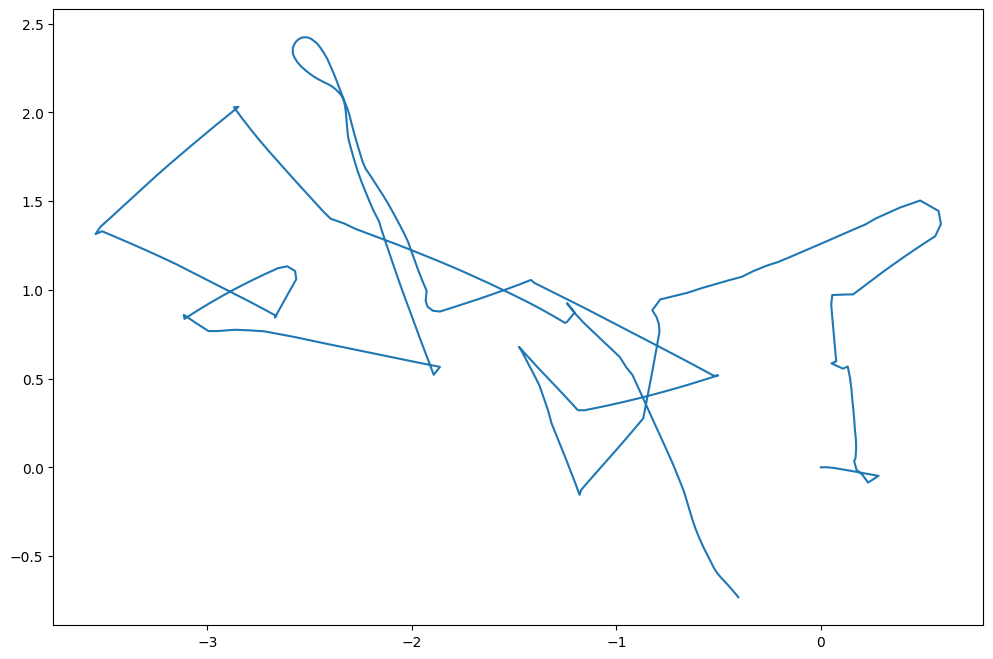

----------------------------------------------------------------------------------------------------
Working on = office_test_sq_test_path1, window size = 10
here
Elapsed time: 9.82 seconds


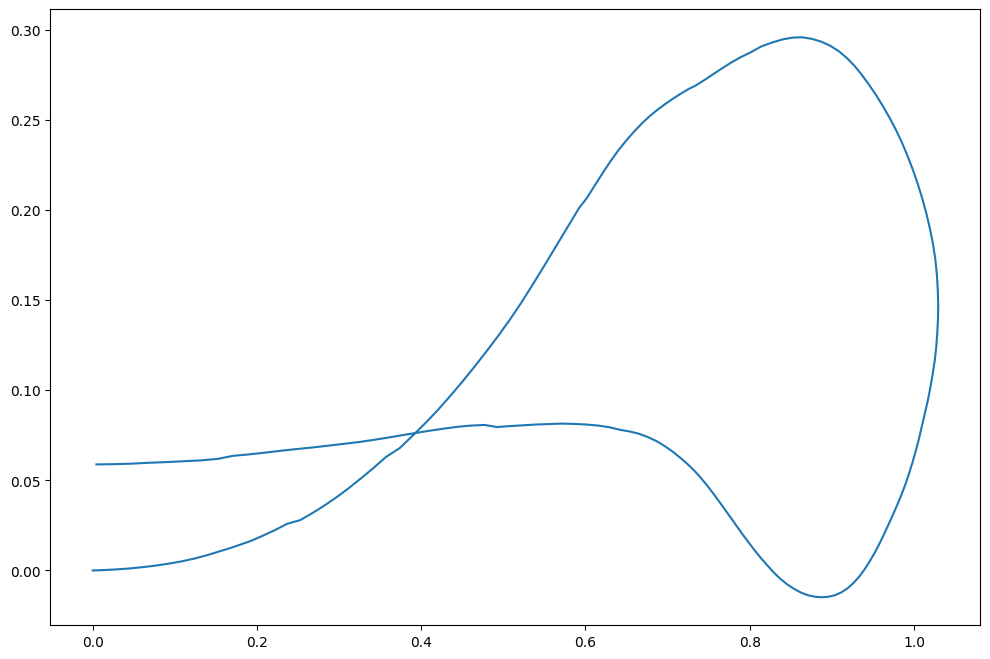

----------------------------------------------------------------------------------------------------
Working on = office_test_sq_test_path1, window size = 20
here
Elapsed time: 8.24 seconds


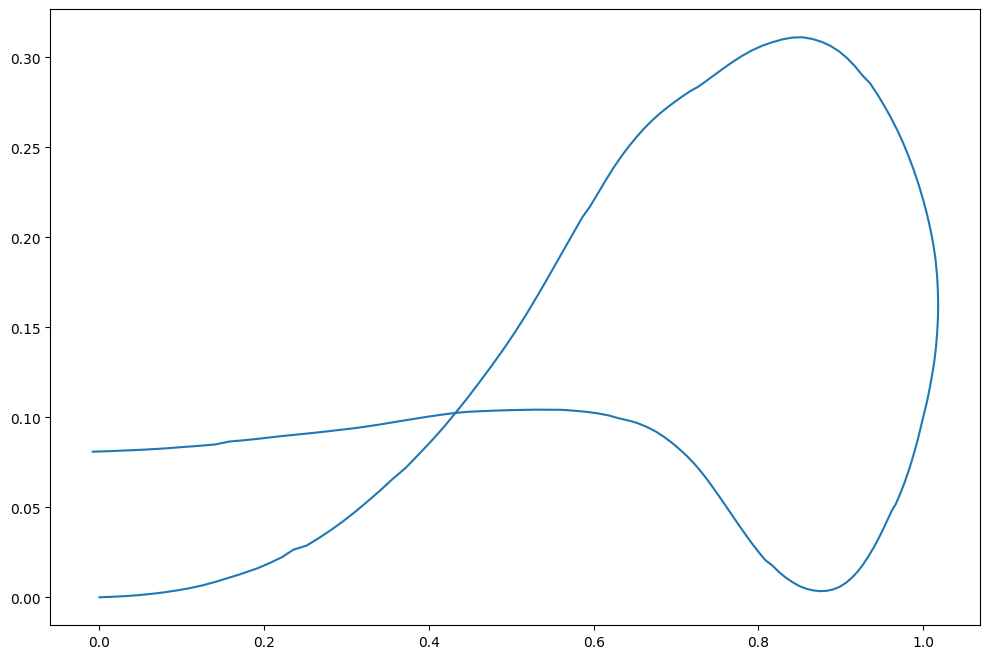

----------------------------------------------------------------------------------------------------
Working on = office_test_sq_test_path1, window size = 30
here
Elapsed time: 8.25 seconds


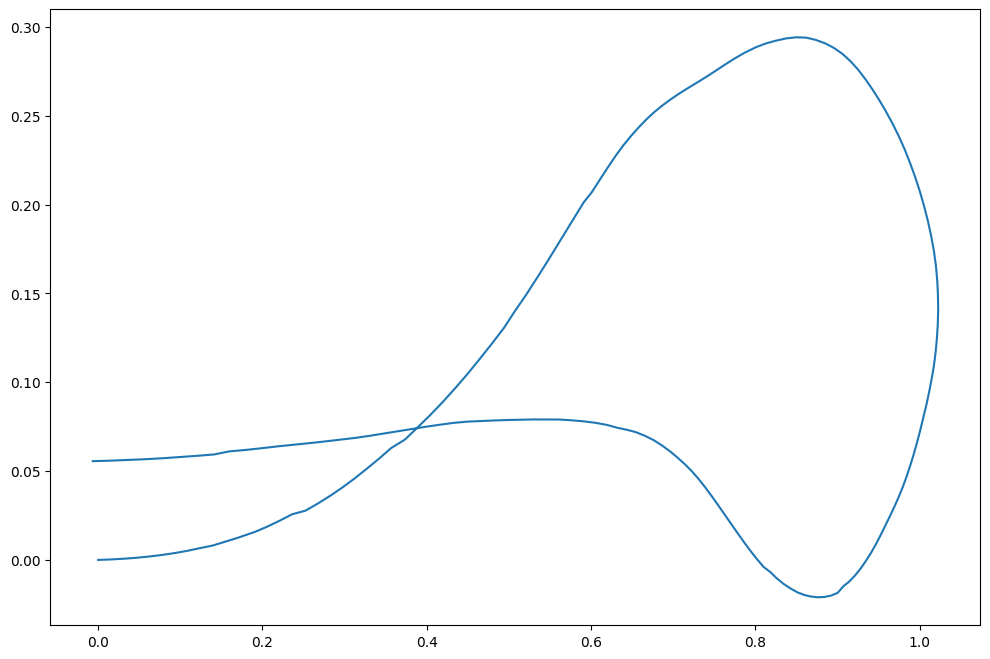

----------------------------------------------------------------------------------------------------
Working on = office_test_sq_test_path1, window size = 40
here
Elapsed time: 8.27 seconds


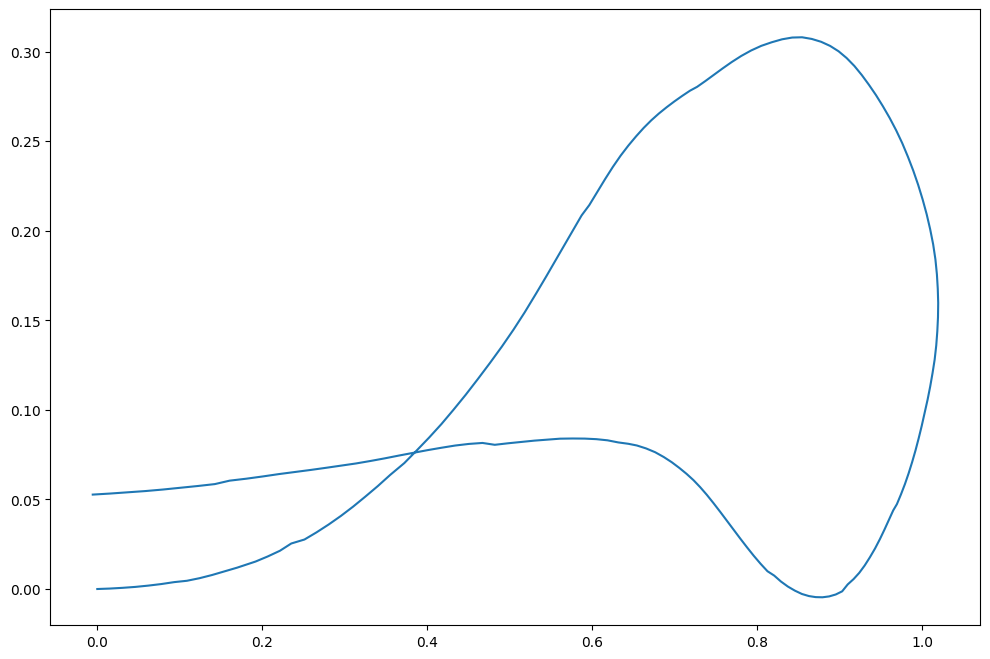

----------------------------------------------------------------------------------------------------
Working on = office_test_sq_test_path1, window size = 50
here
Elapsed time: 8.28 seconds


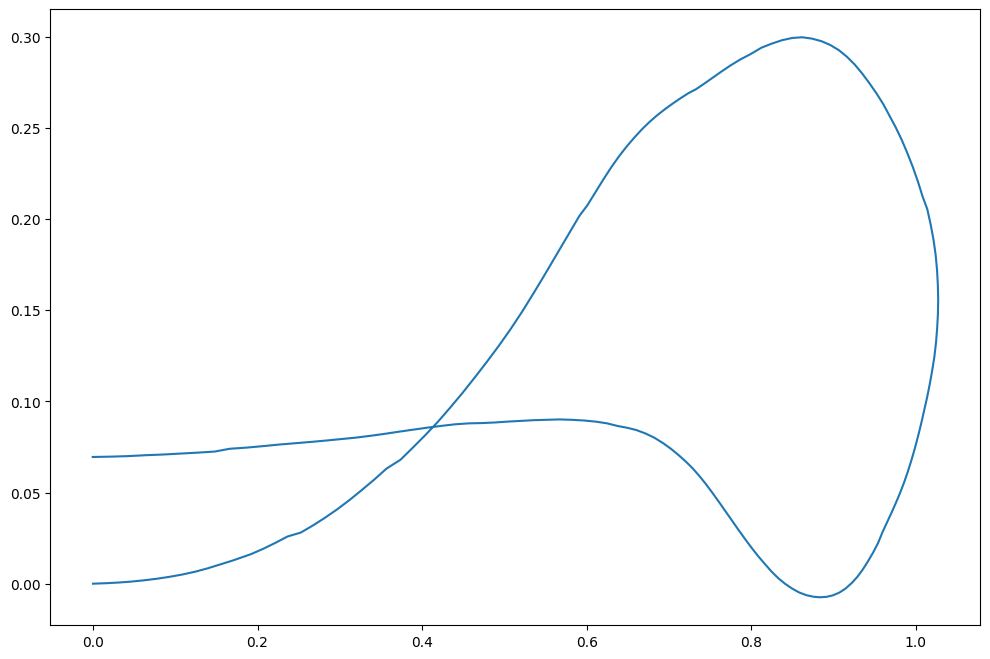

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path4, window size = 10
here
Elapsed time: 10.77 seconds


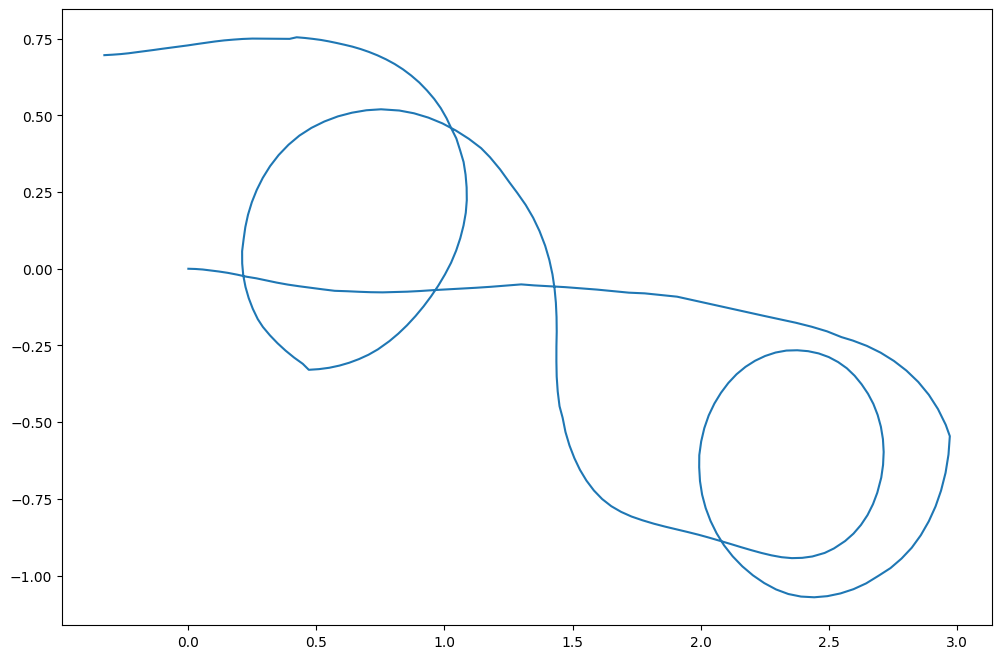

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path4, window size = 20
here
Elapsed time: 8.28 seconds


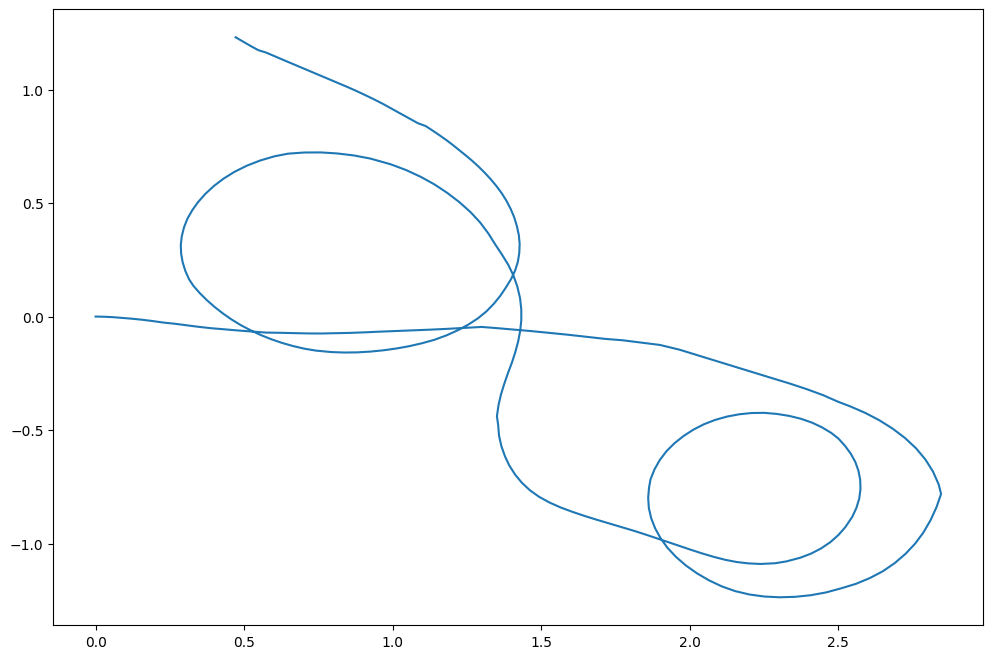

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path4, window size = 30
here
Elapsed time: 8.36 seconds


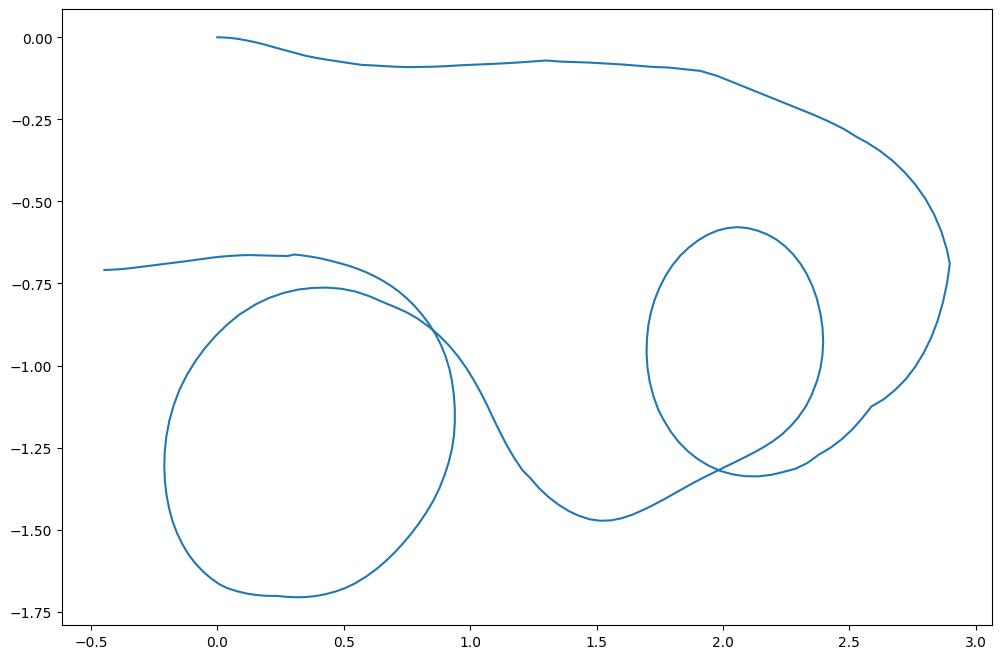

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path4, window size = 40
here
Elapsed time: 8.28 seconds


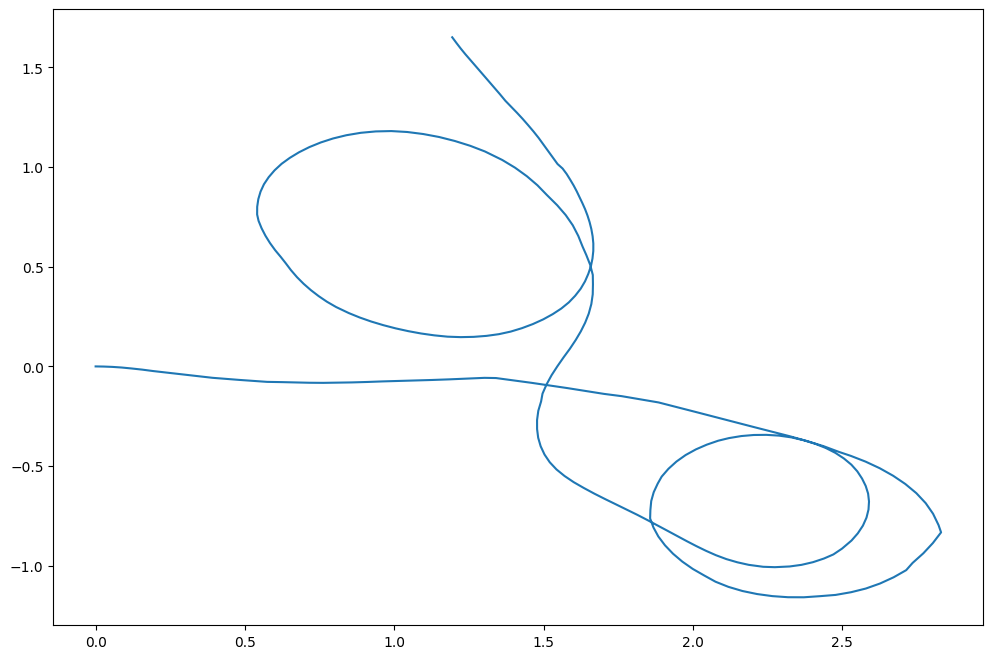

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path4, window size = 50
here
Elapsed time: 8.32 seconds


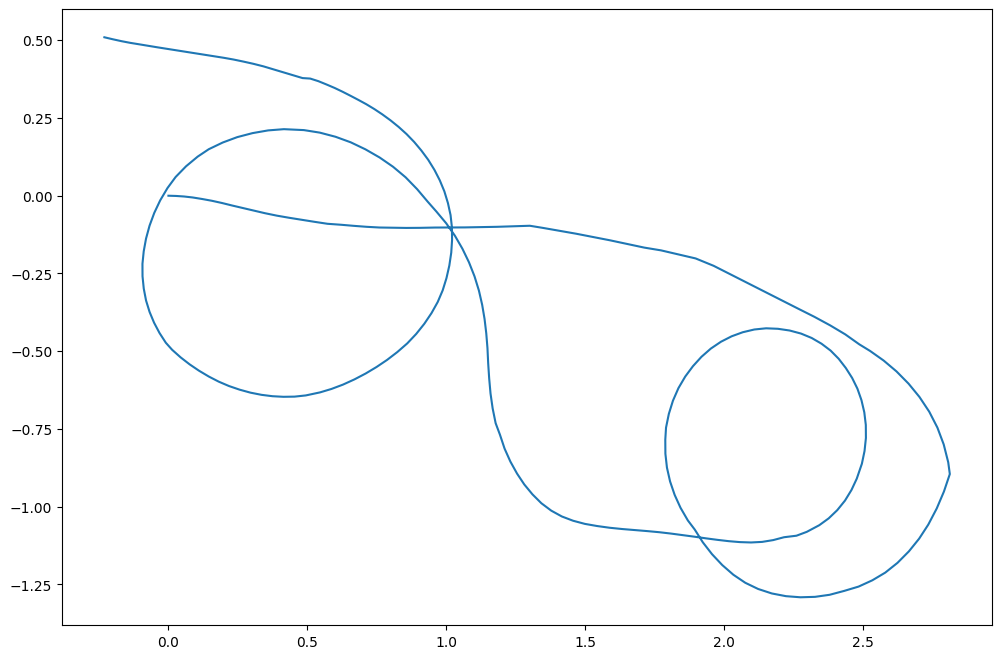

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path1, window size = 10
here
Elapsed time: 8.50 seconds


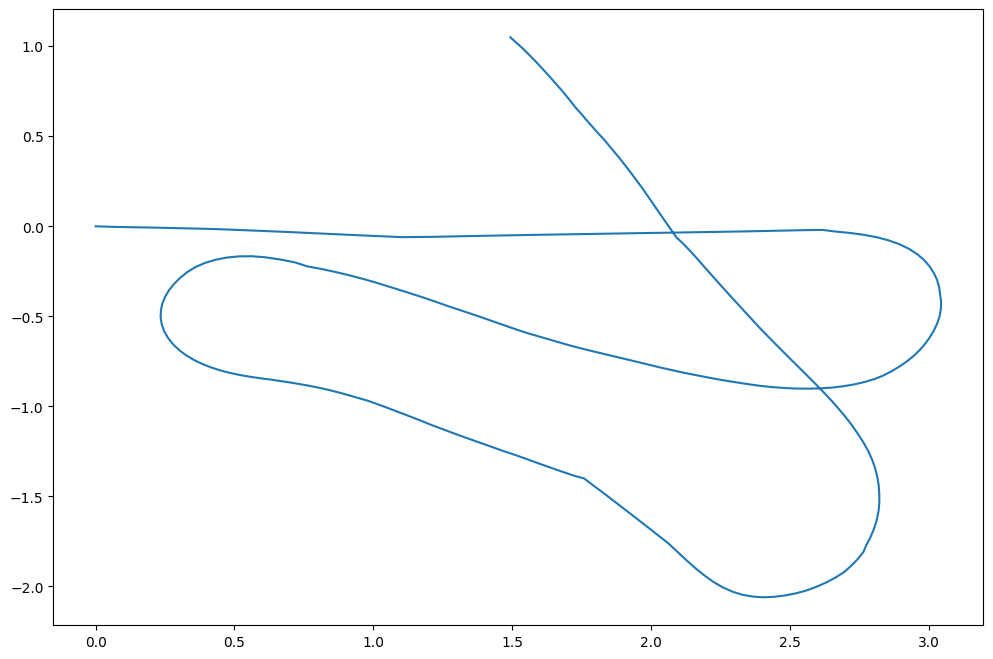

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path1, window size = 20
here
Elapsed time: 8.53 seconds


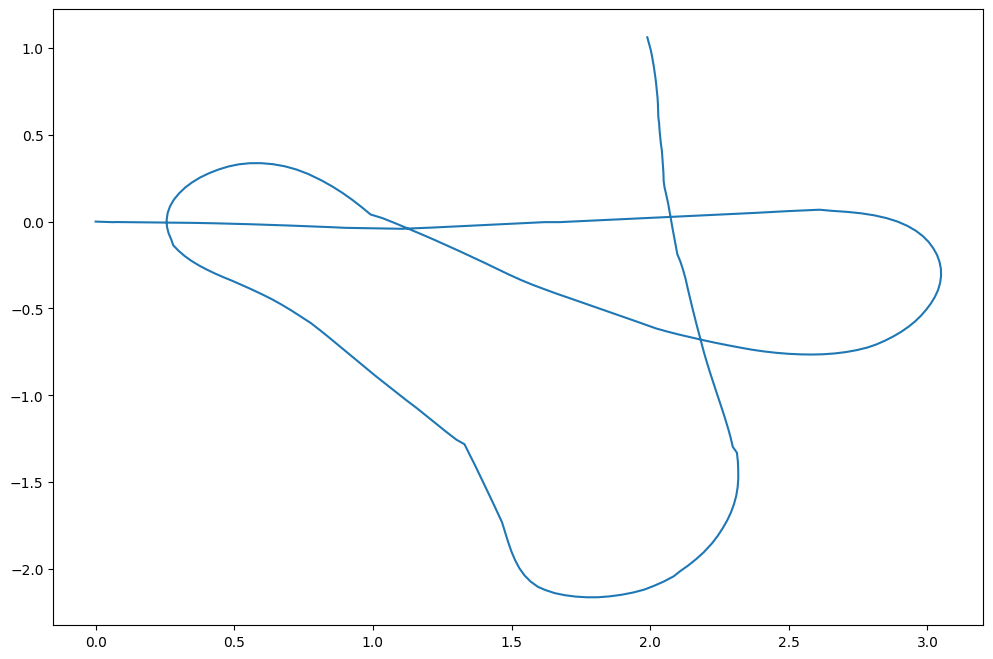

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path1, window size = 30
here
Elapsed time: 8.47 seconds


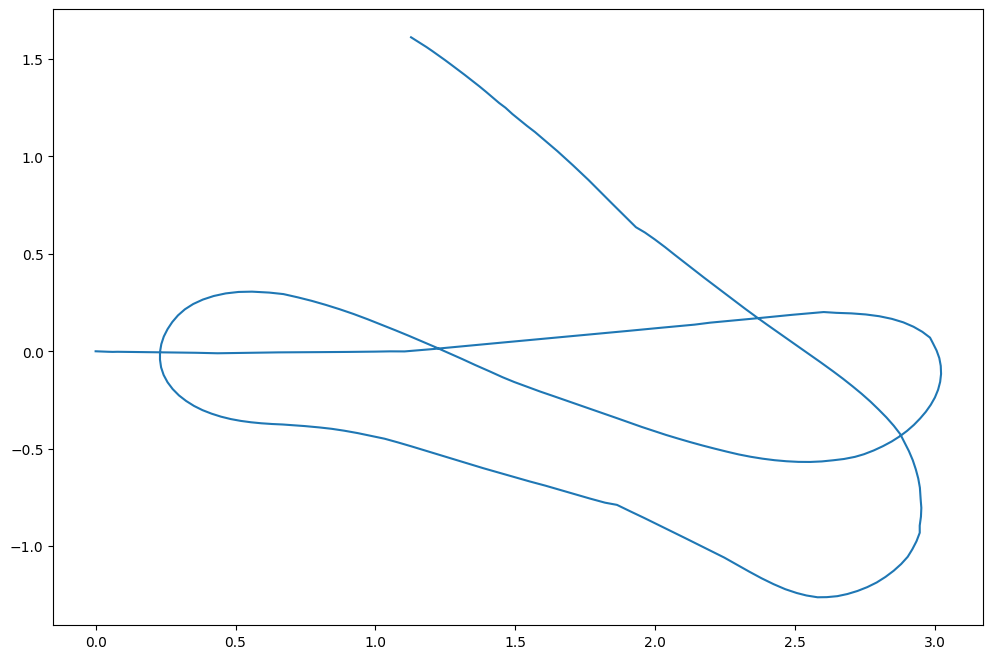

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path1, window size = 40
here
Elapsed time: 8.48 seconds


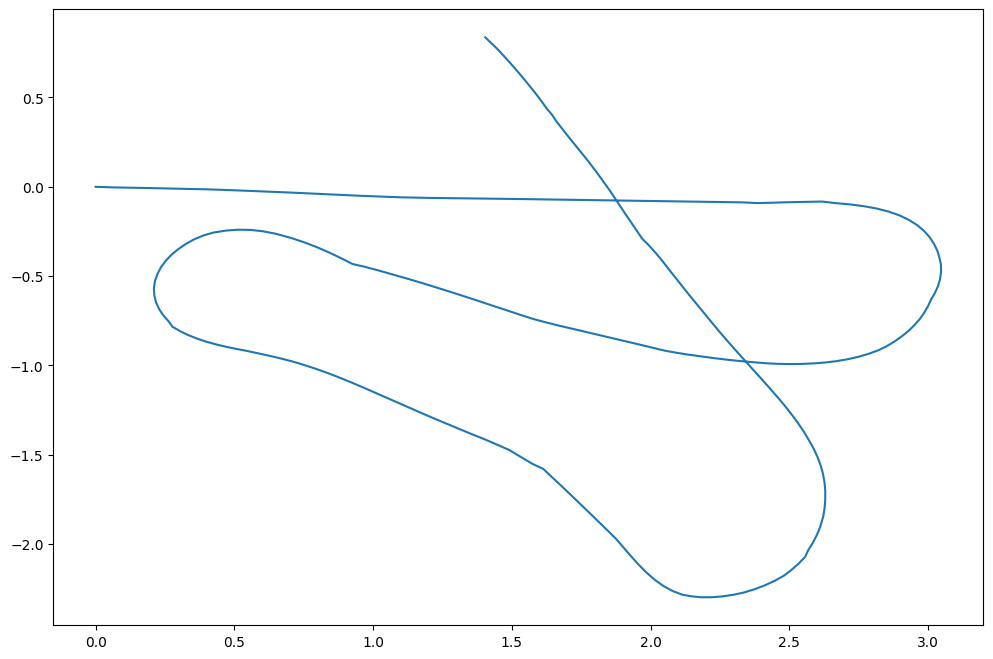

----------------------------------------------------------------------------------------------------
Working on = bathroom_tiles_test_path1, window size = 50
here
Elapsed time: 8.54 seconds


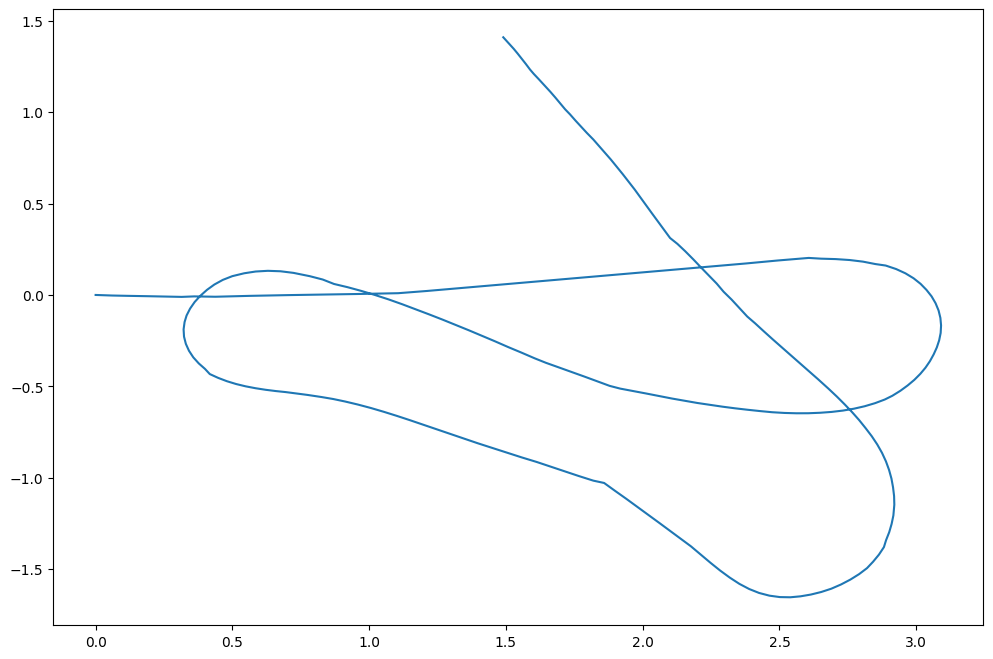

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path2, window size = 10
here
Elapsed time: 7.82 seconds


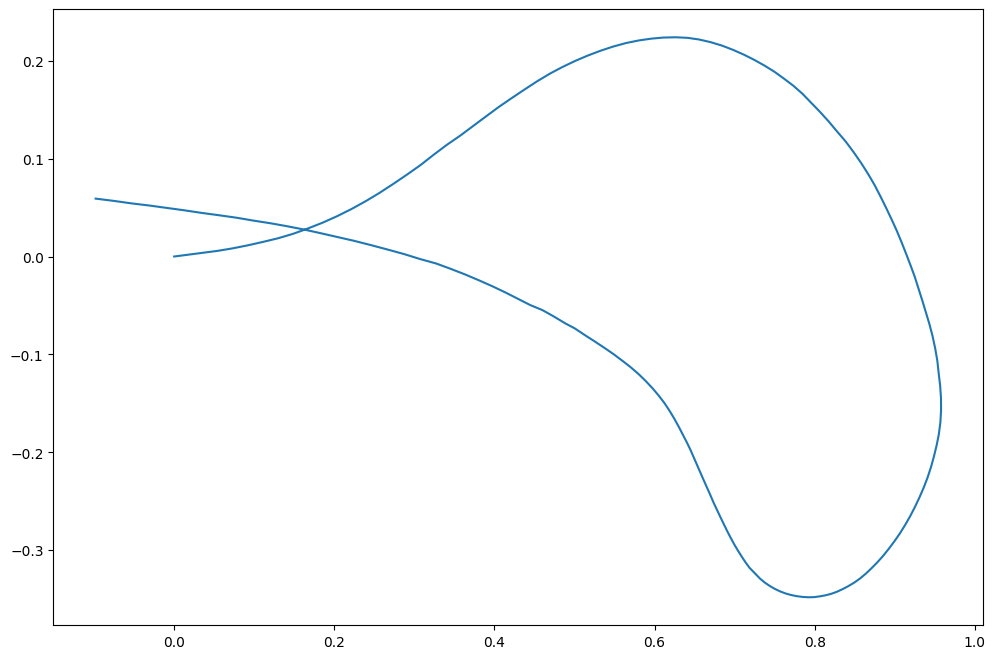

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path2, window size = 20
here
Elapsed time: 5.75 seconds


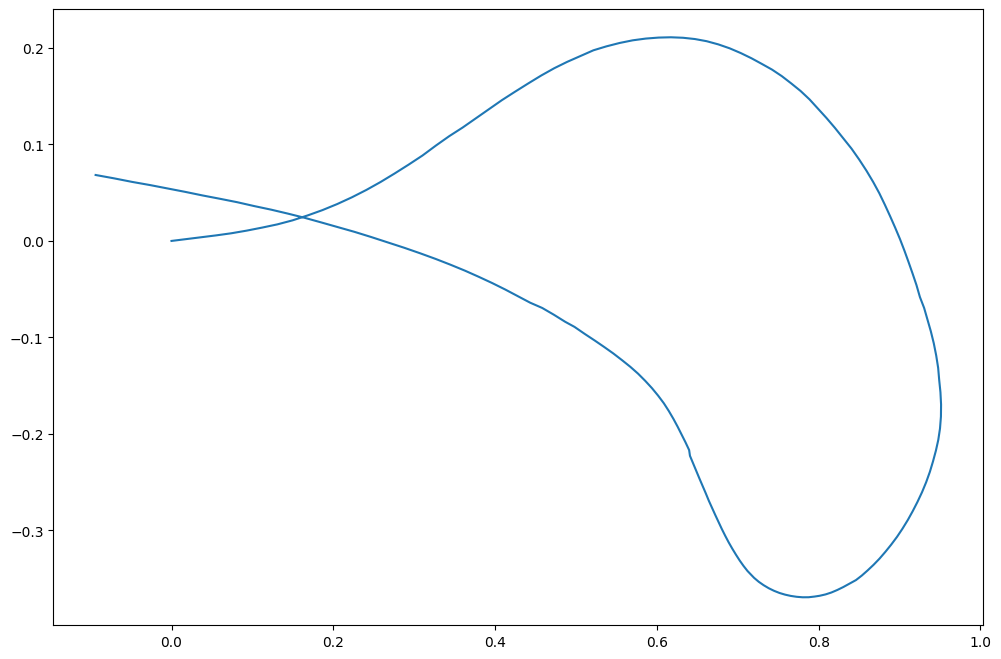

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path2, window size = 30
here
Elapsed time: 5.92 seconds


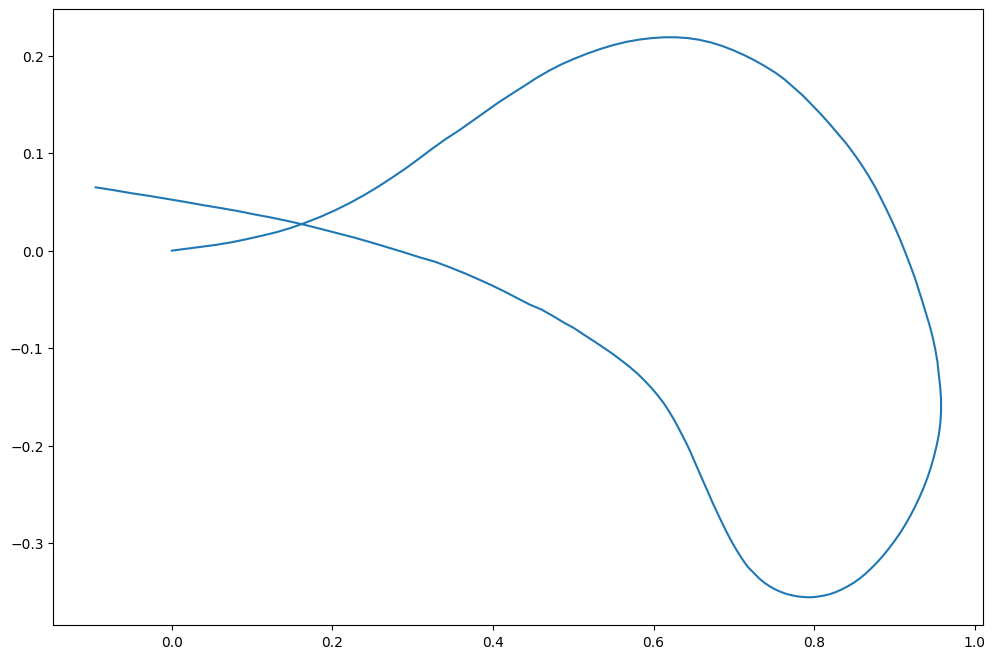

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path2, window size = 40
here
Elapsed time: 5.90 seconds


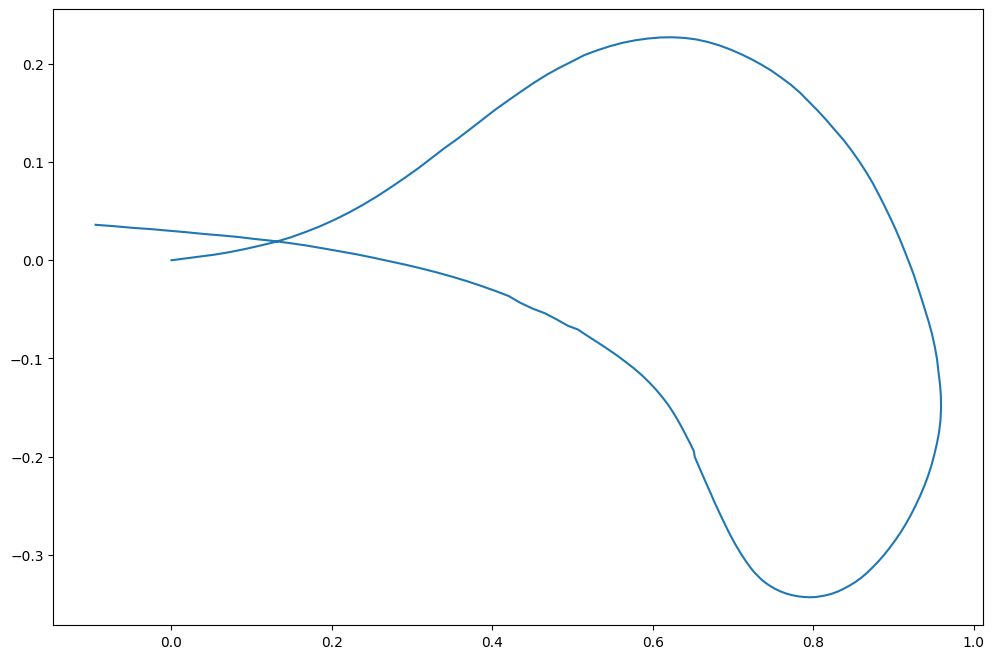

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path2, window size = 50
here
Elapsed time: 5.92 seconds


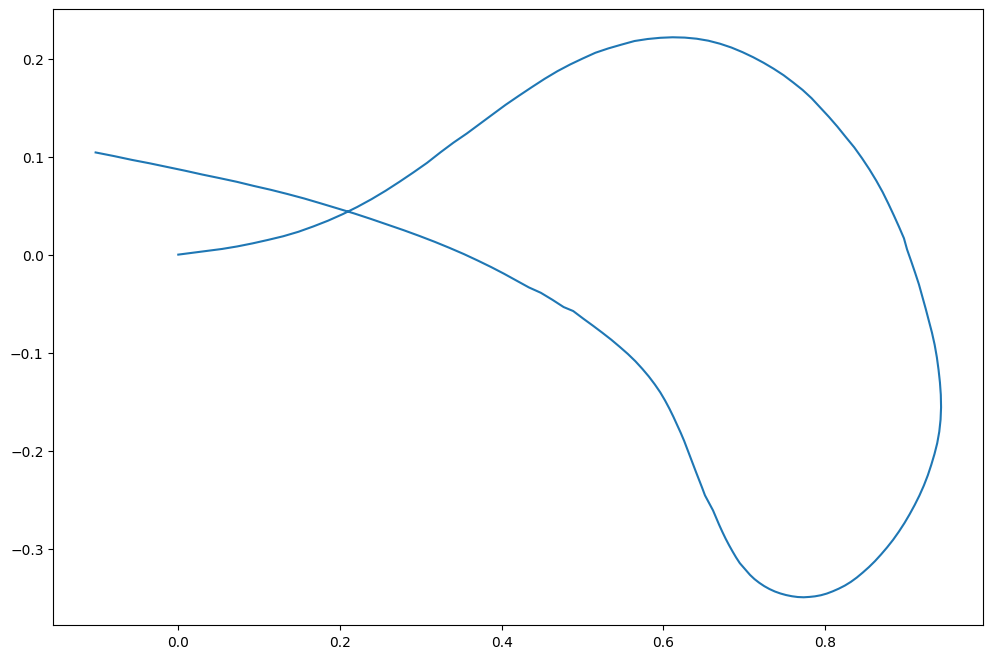

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path1, window size = 10
here
Elapsed time: 9.17 seconds


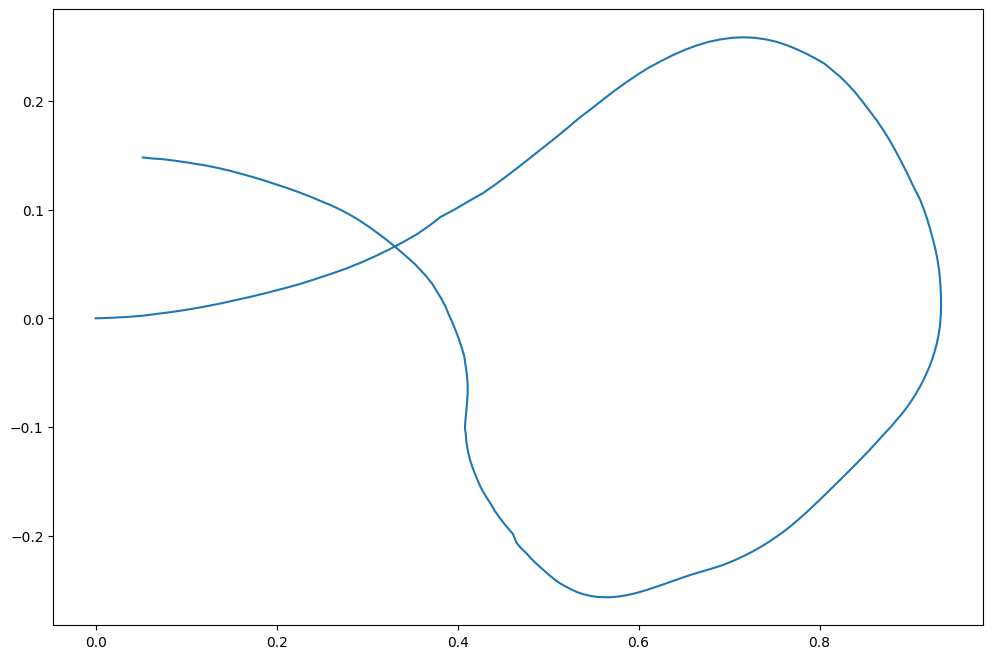

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path1, window size = 20
here
Elapsed time: 7.39 seconds


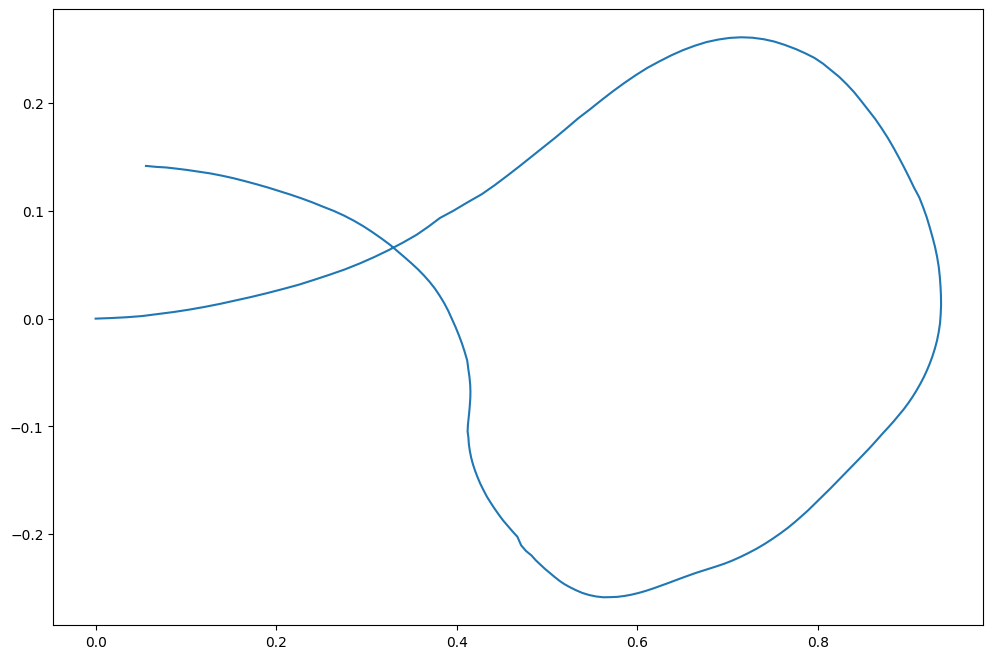

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path1, window size = 30
here
Elapsed time: 7.45 seconds


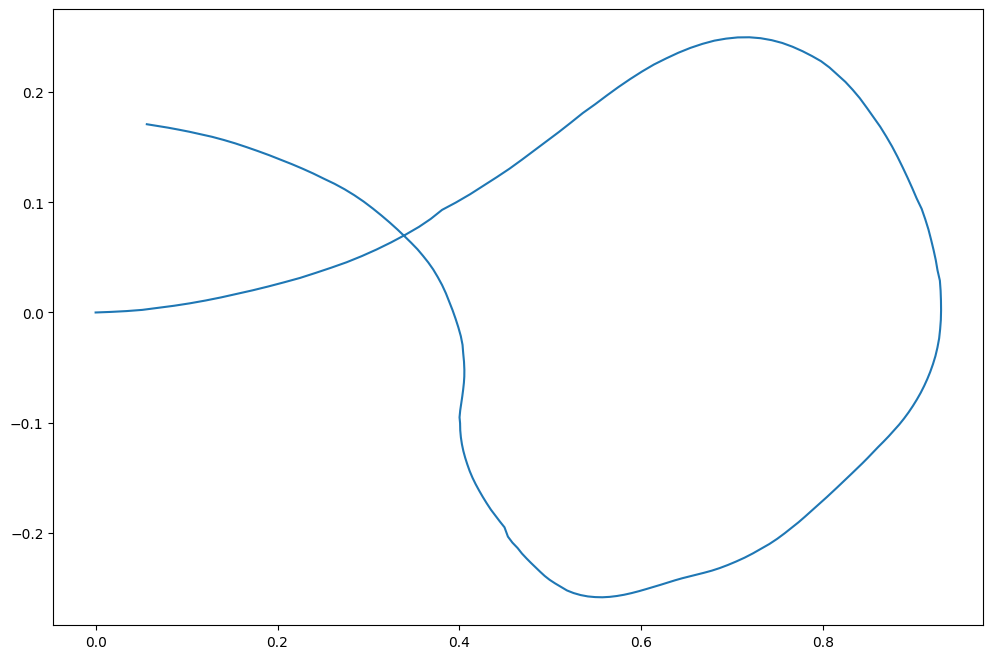

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path1, window size = 40
here
Elapsed time: 7.45 seconds


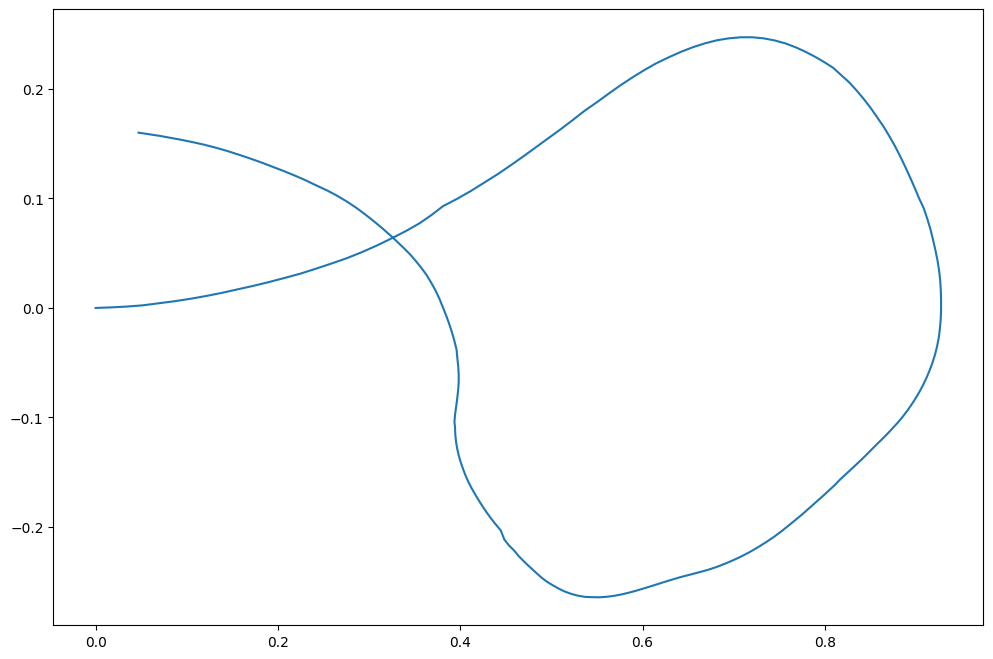

----------------------------------------------------------------------------------------------------
Working on = parking_place_test_sq_test_path1, window size = 50
here
Elapsed time: 7.42 seconds


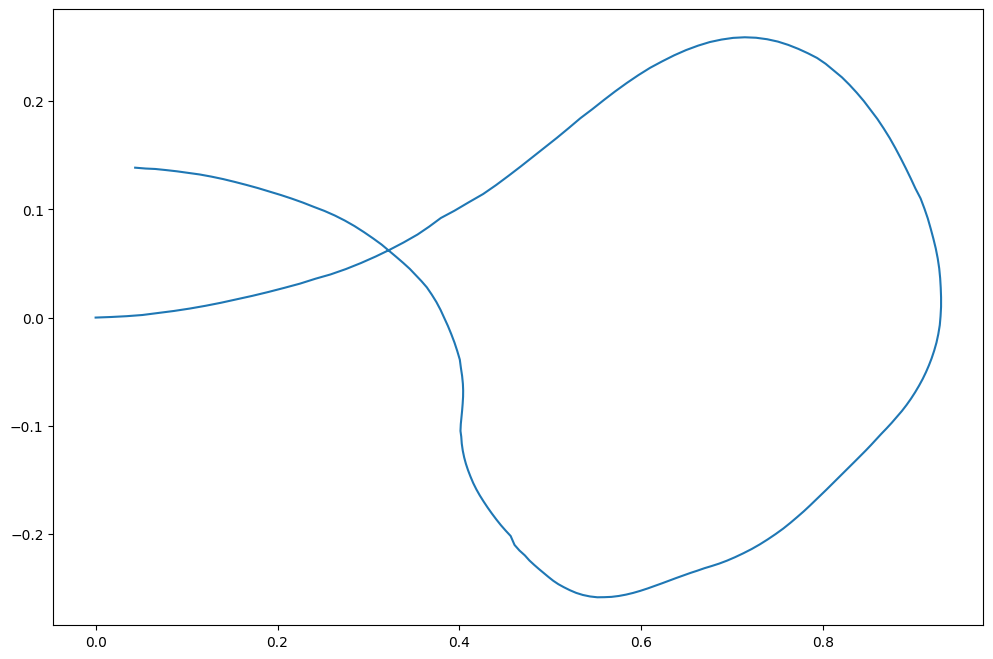

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path2, window size = 10
here
Elapsed time: 5.99 seconds


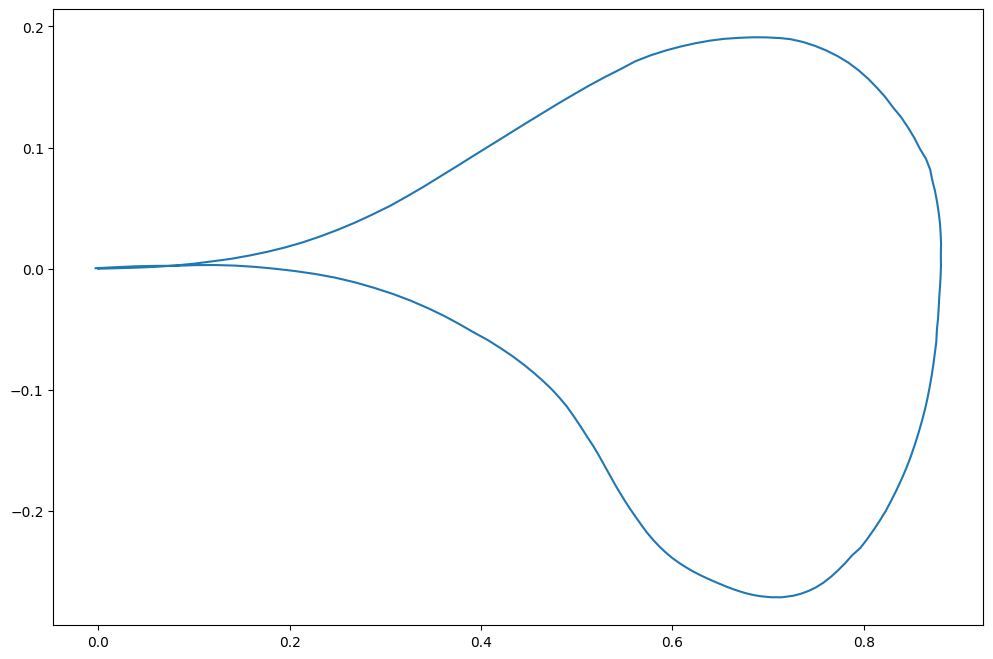

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path2, window size = 20
here
Elapsed time: 5.97 seconds


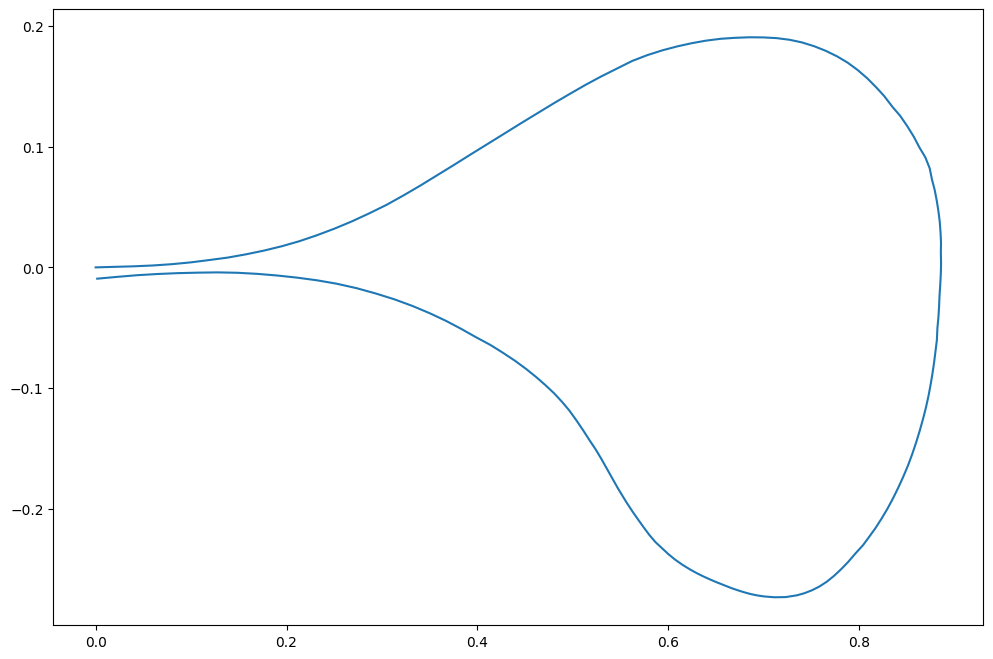

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path2, window size = 30
here
Elapsed time: 5.99 seconds


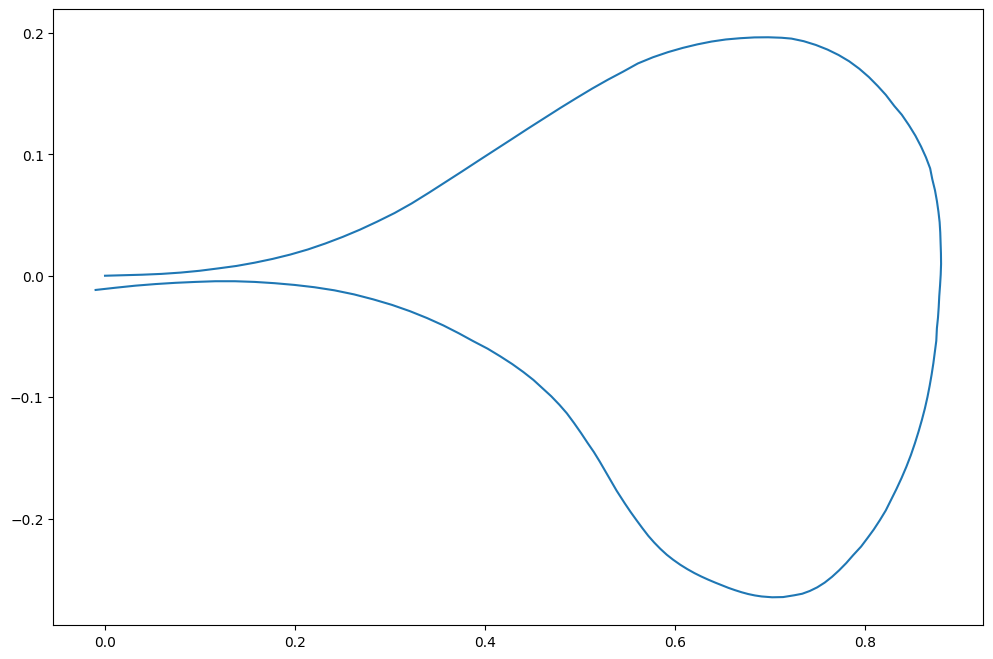

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path2, window size = 40
here
Elapsed time: 5.99 seconds


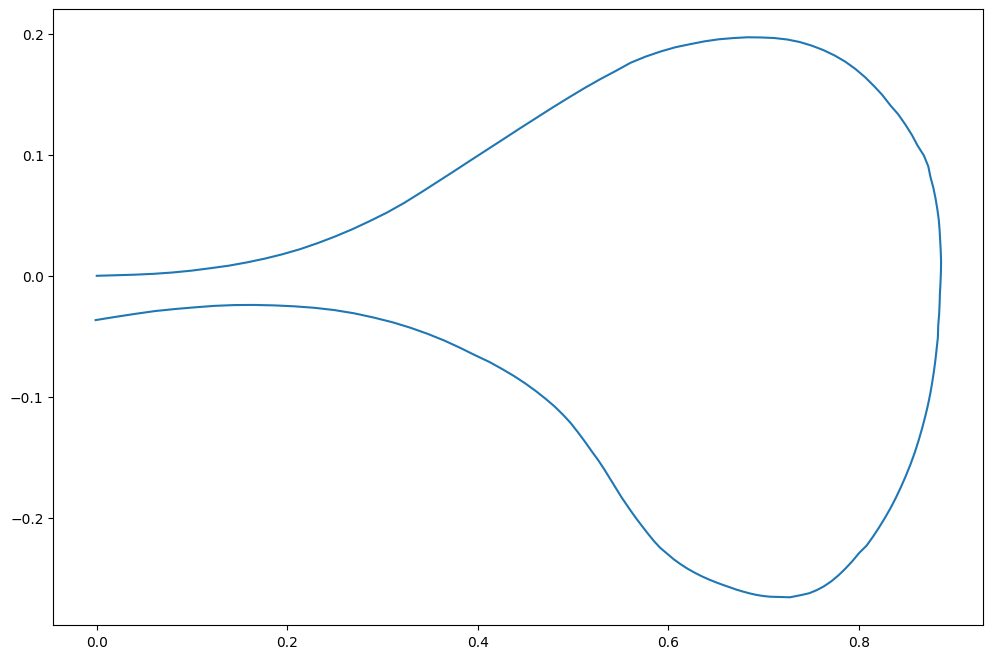

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path2, window size = 50
here
Elapsed time: 5.99 seconds


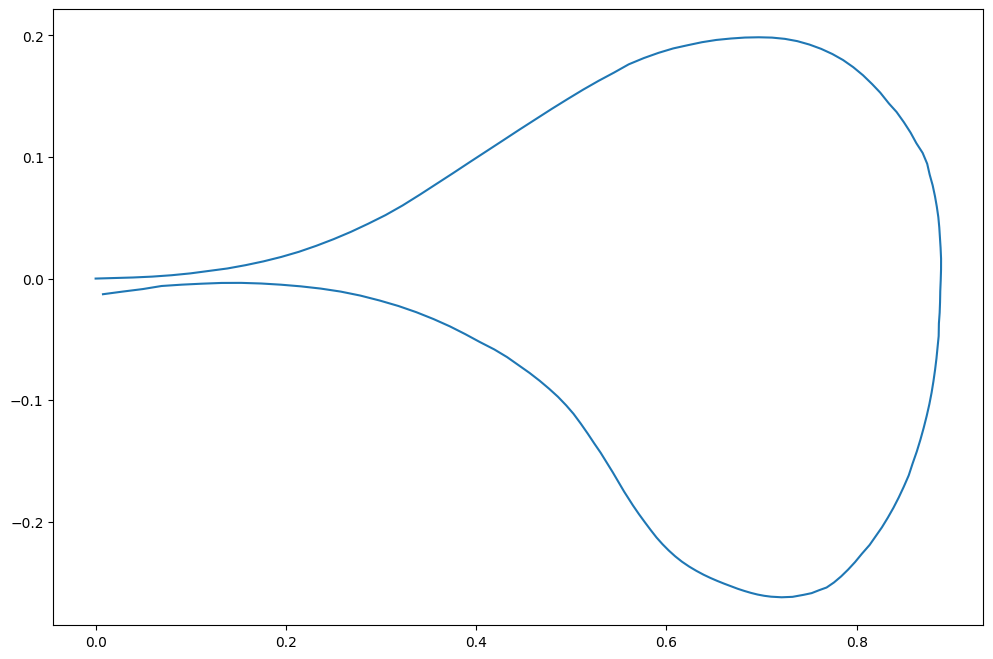

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path1, window size = 10
here
Elapsed time: 6.72 seconds


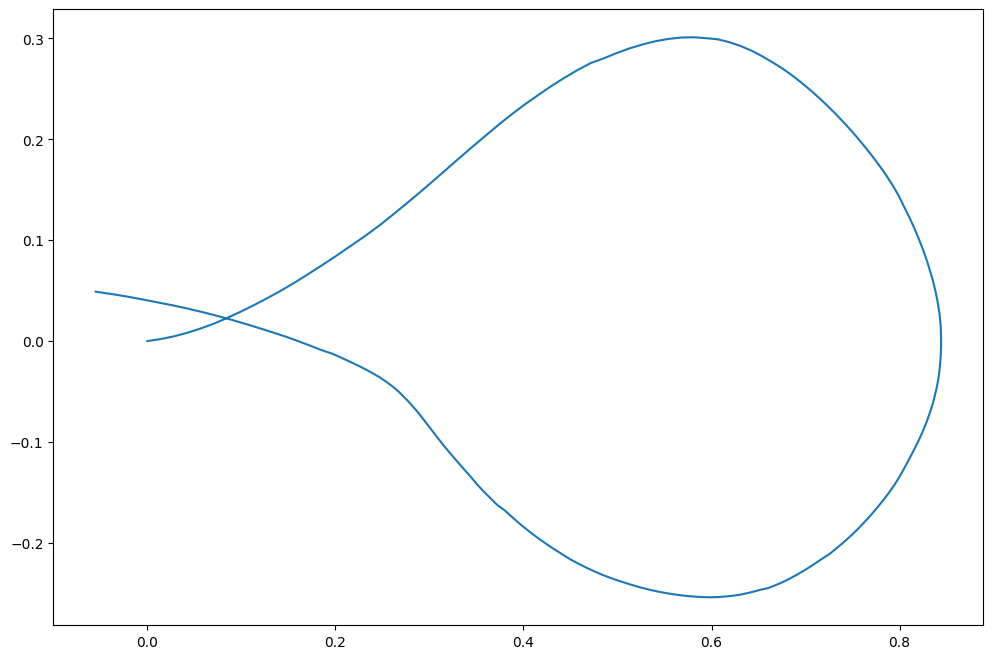

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path1, window size = 20
here
Elapsed time: 6.72 seconds


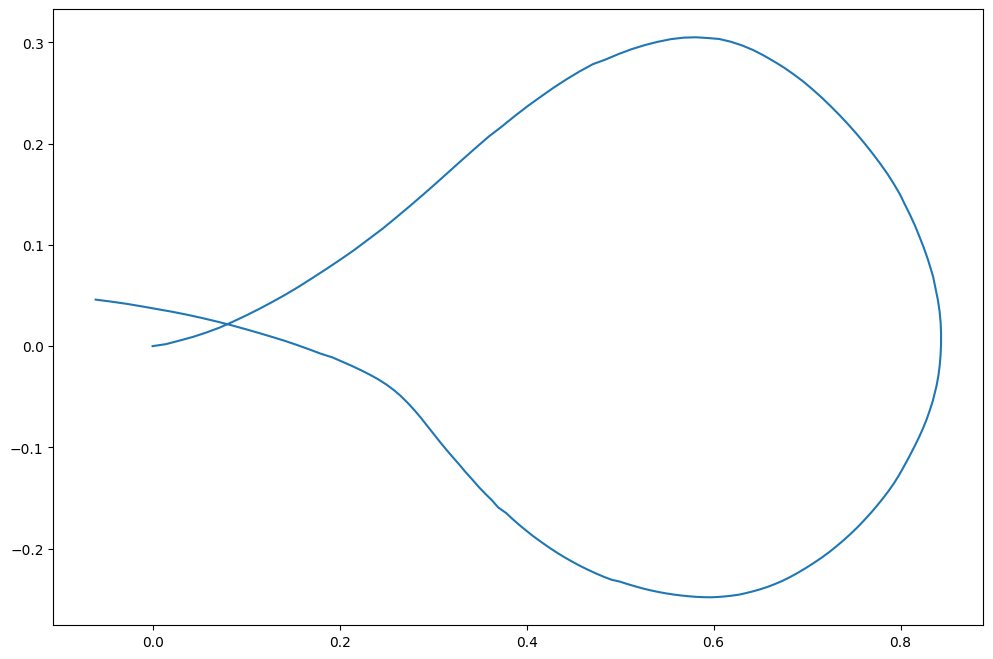

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path1, window size = 30
here
Elapsed time: 6.75 seconds


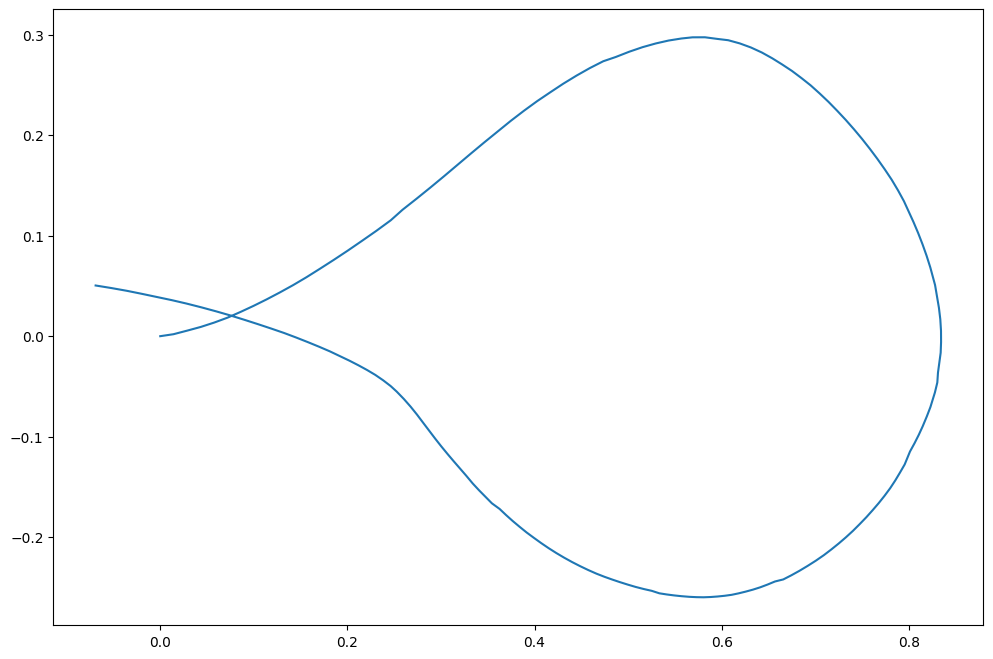

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path1, window size = 40
here
Elapsed time: 6.73 seconds


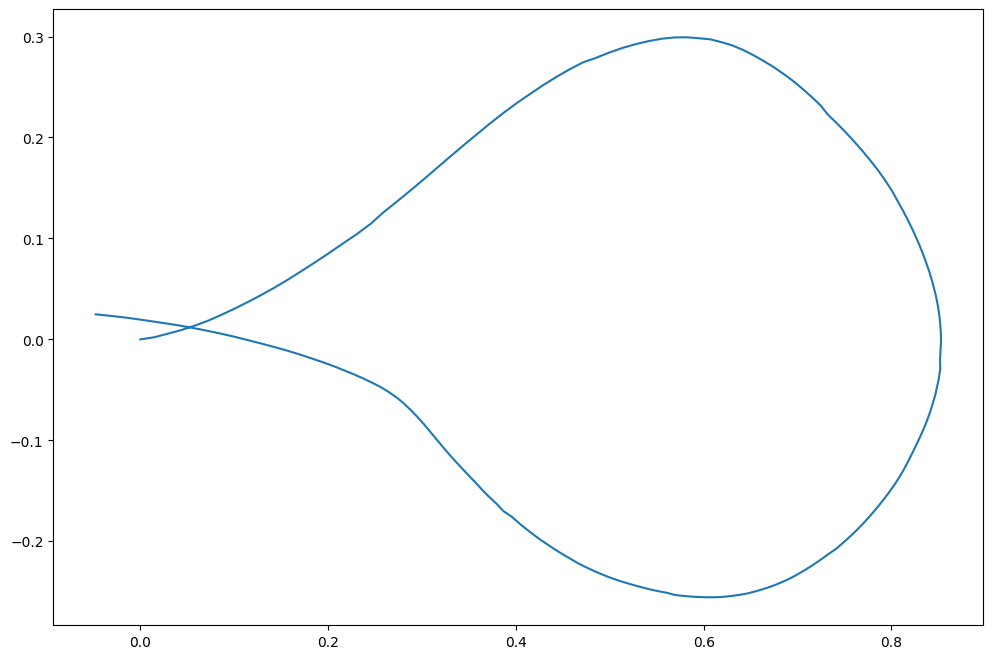

----------------------------------------------------------------------------------------------------
Working on = footpath_test_sq_test_path1, window size = 50
here
Elapsed time: 6.73 seconds


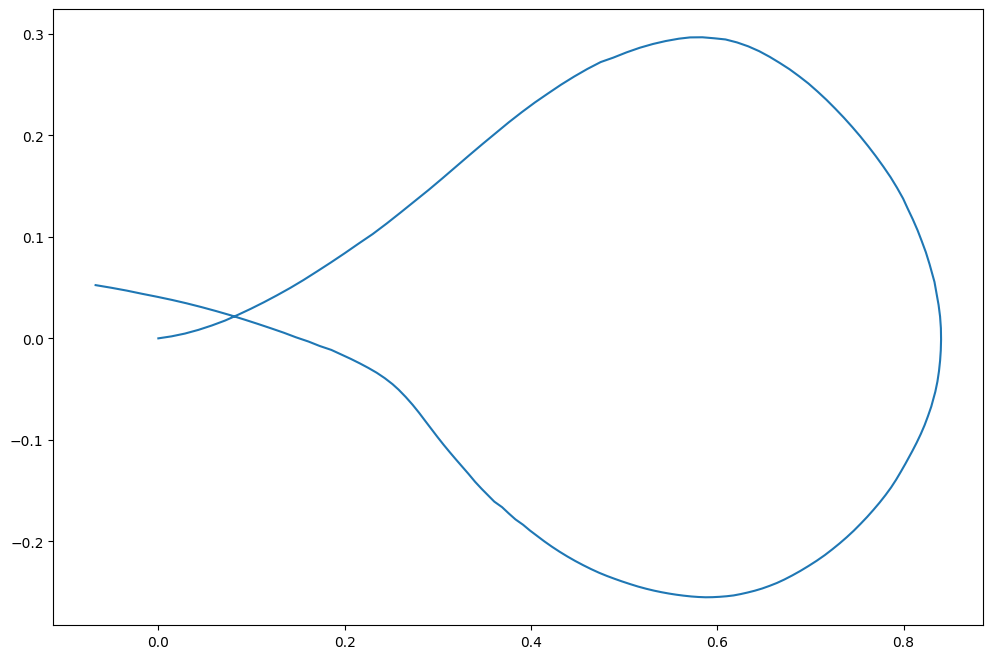

----------------------------------------------------------------------------------------------------
Working on = doormat_test_path1, window size = 10
here
Elapsed time: 7.68 seconds


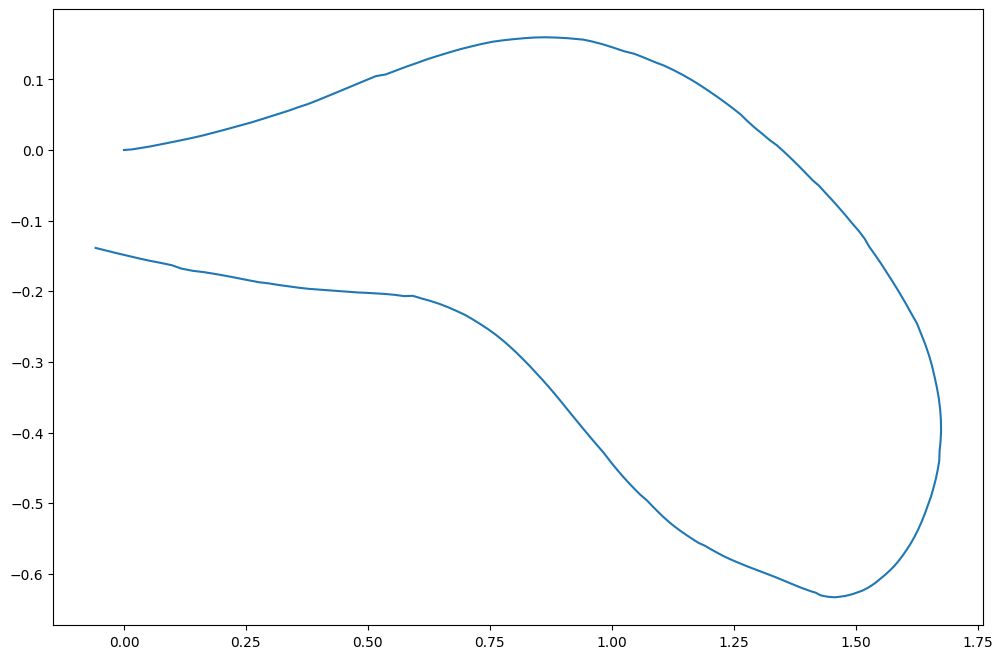

----------------------------------------------------------------------------------------------------
Working on = doormat_test_path1, window size = 20
here
Elapsed time: 7.64 seconds


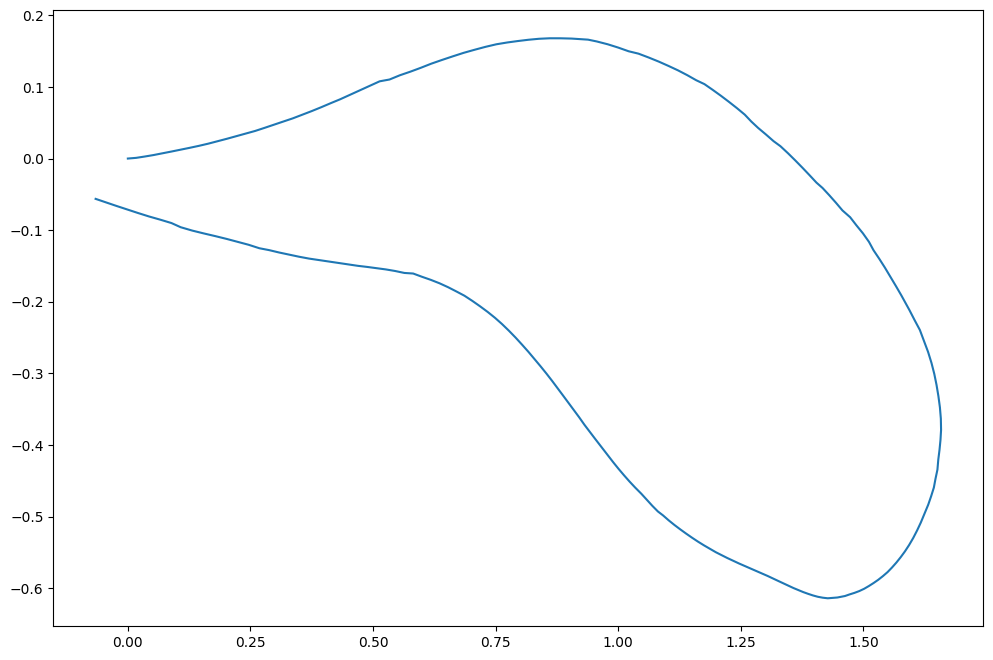

----------------------------------------------------------------------------------------------------
Working on = doormat_test_path1, window size = 30
here
Elapsed time: 7.68 seconds


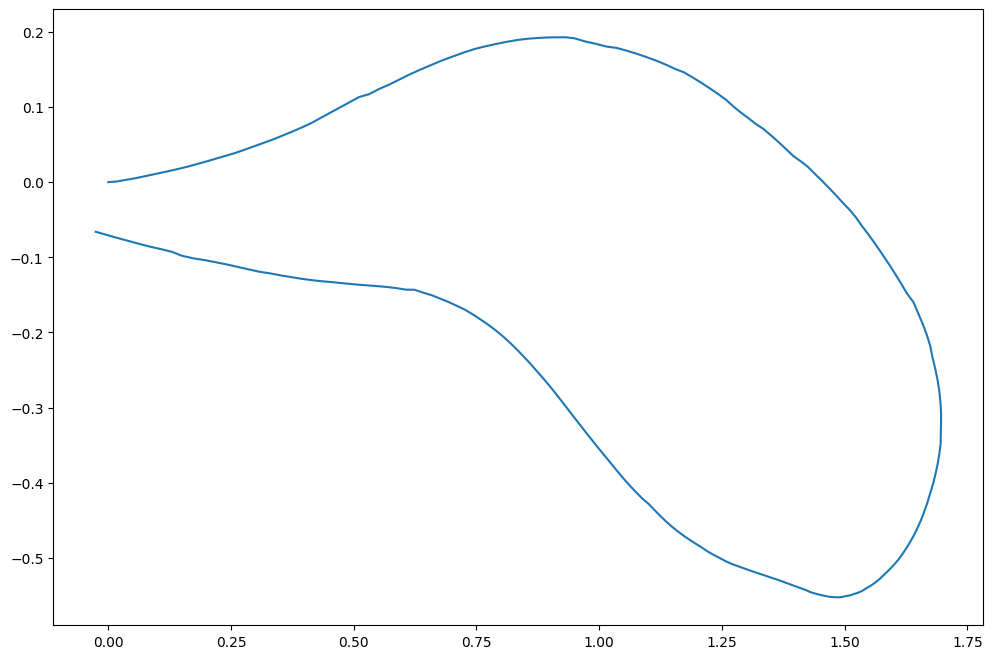

----------------------------------------------------------------------------------------------------
Working on = doormat_test_path1, window size = 40
here
Elapsed time: 7.62 seconds


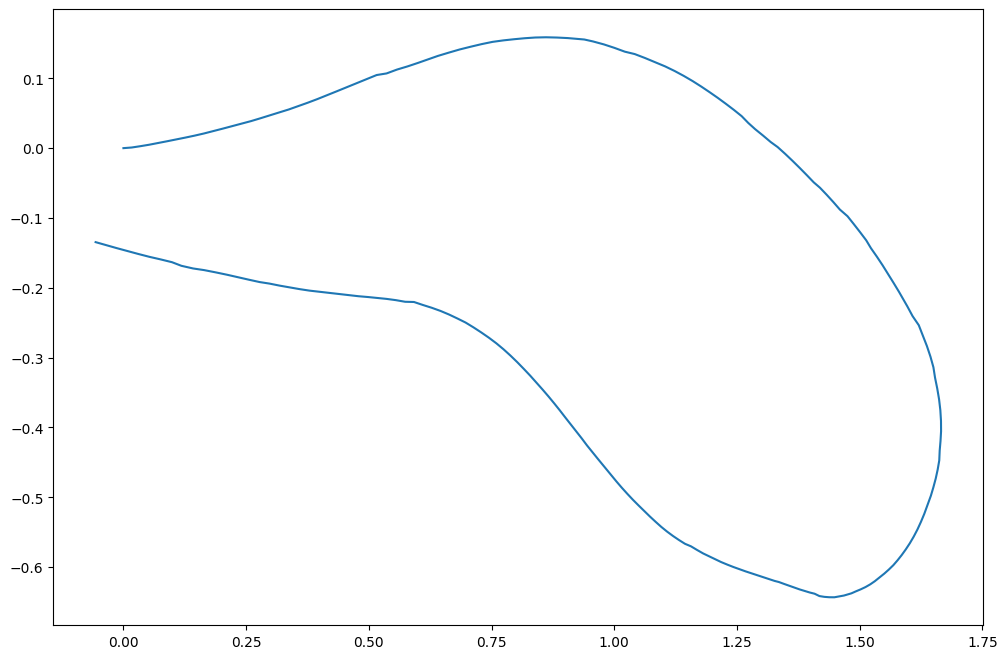

----------------------------------------------------------------------------------------------------
Working on = doormat_test_path1, window size = 50
here
Elapsed time: 7.70 seconds


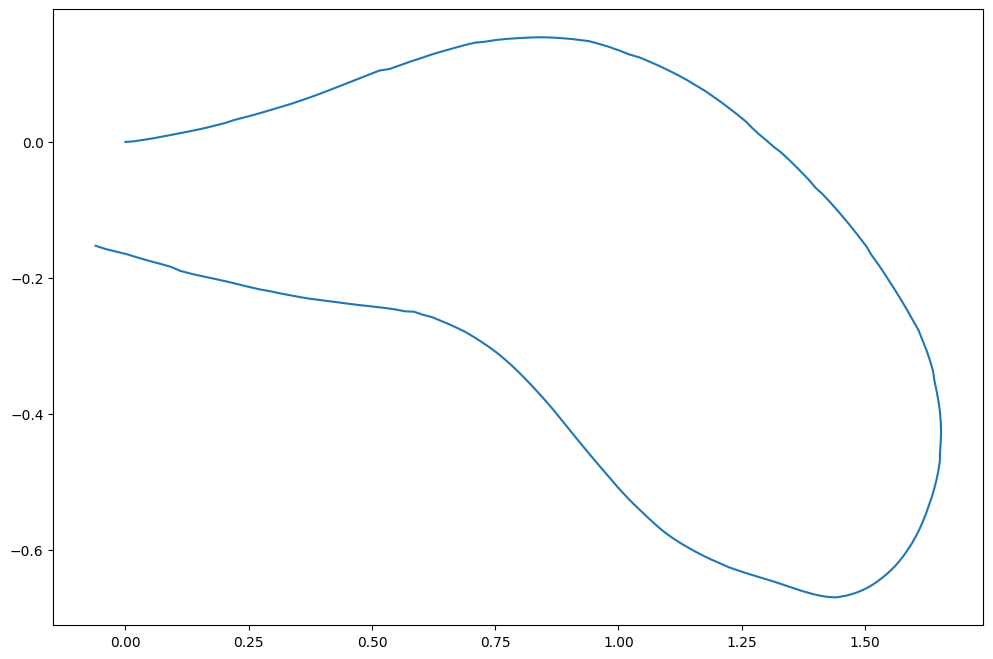

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path2, window size = 10
here
Elapsed time: 4.27 seconds


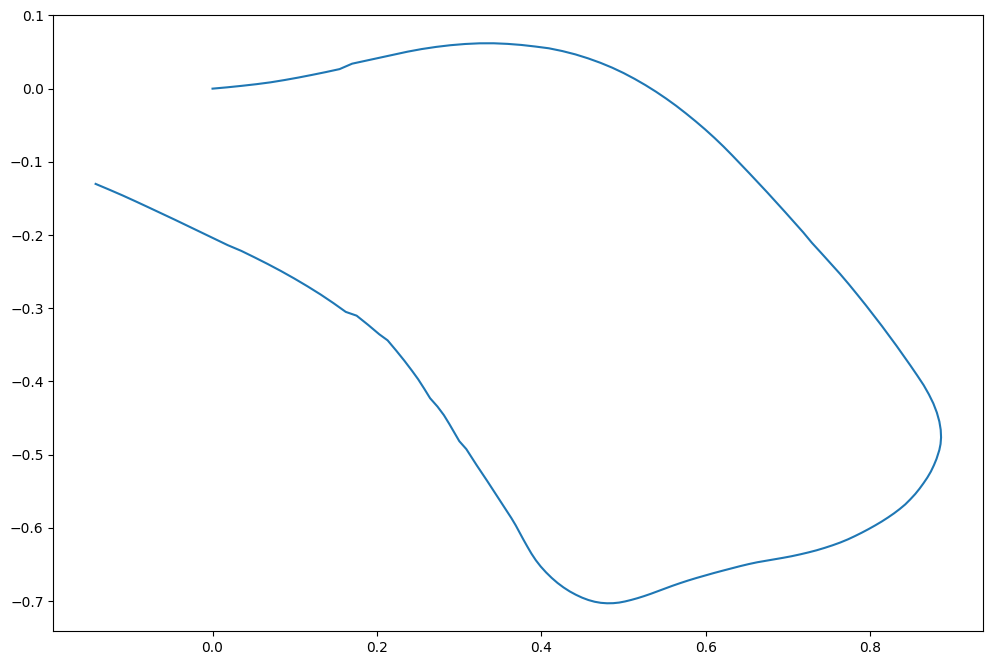

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path2, window size = 20
here
Elapsed time: 4.22 seconds


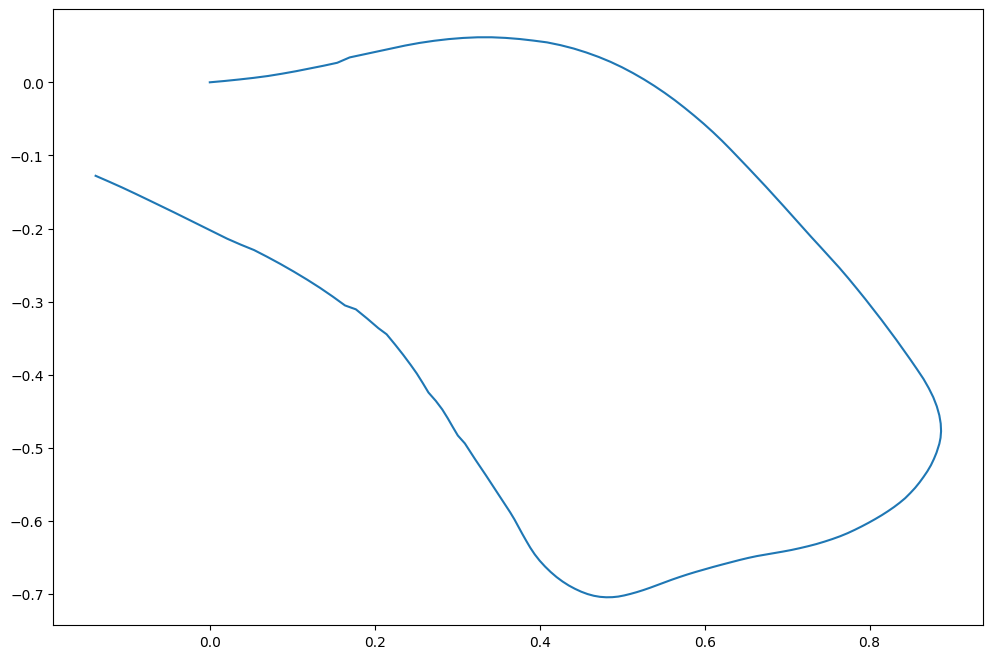

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path2, window size = 30
here
Elapsed time: 4.20 seconds


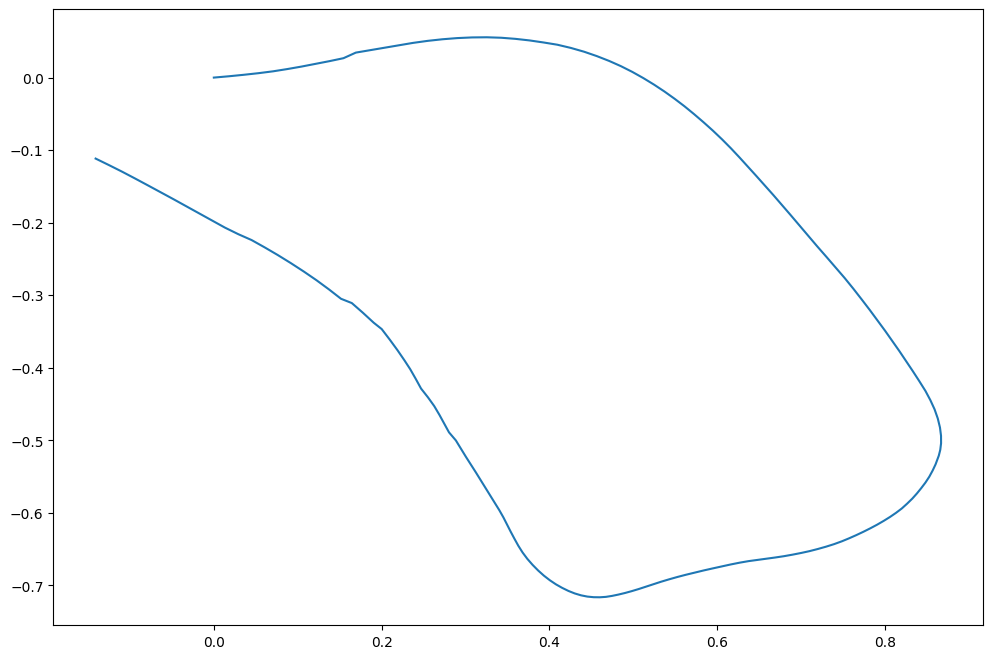

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path2, window size = 40
here
Elapsed time: 4.22 seconds


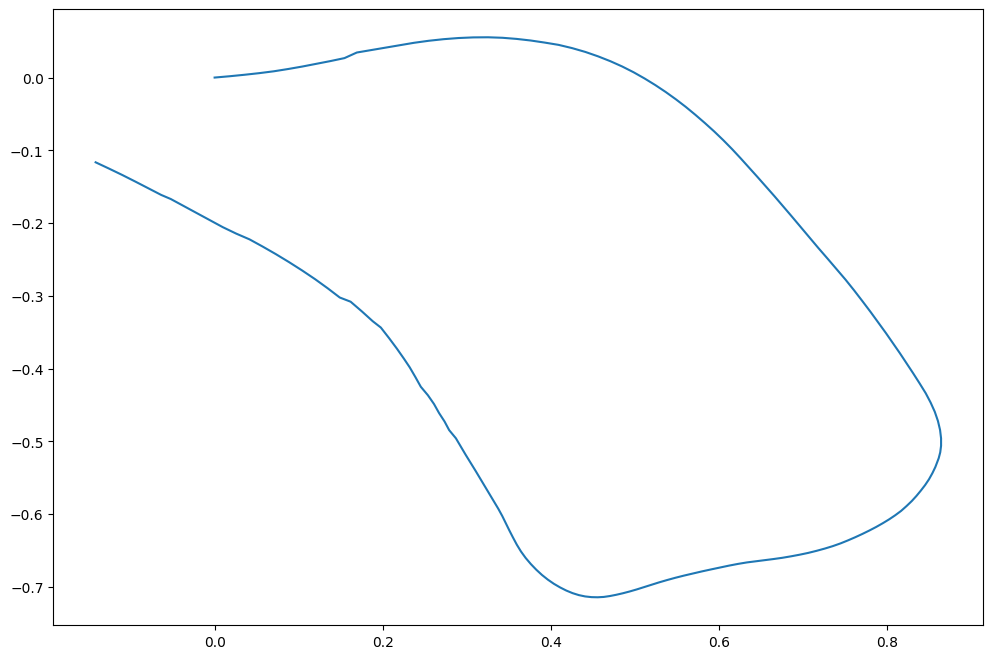

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path2, window size = 50
here
Elapsed time: 4.21 seconds


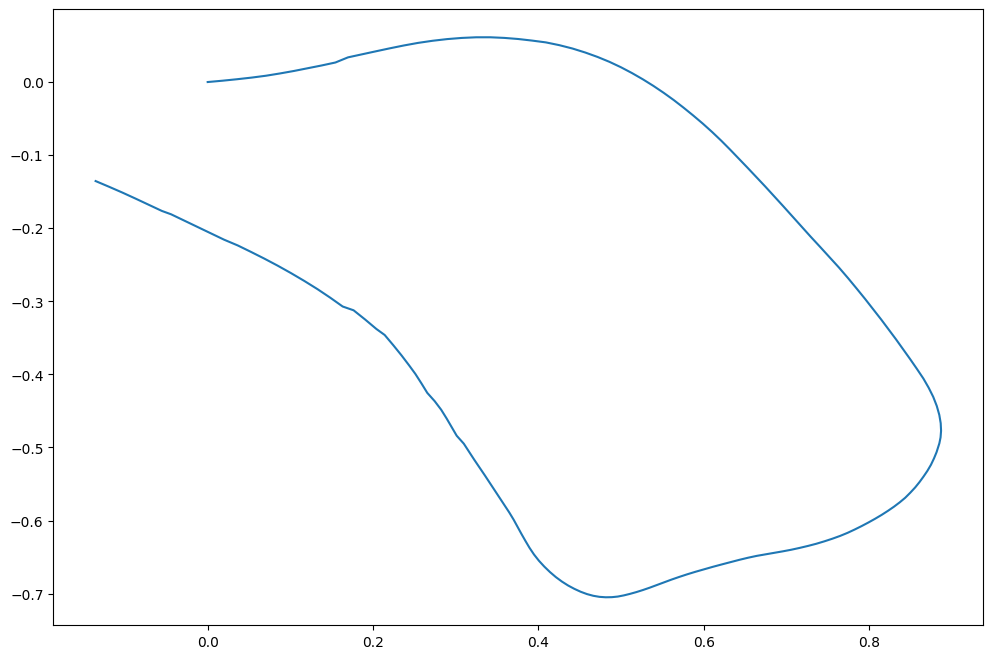

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path1, window size = 10
here
Elapsed time: 4.51 seconds


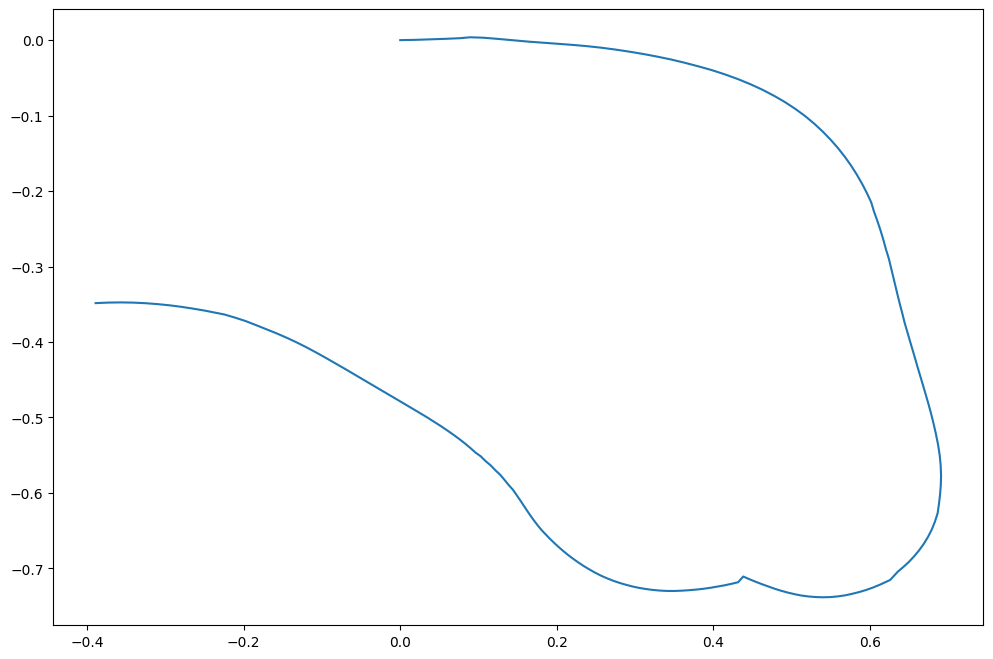

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path1, window size = 20
here
Elapsed time: 4.49 seconds


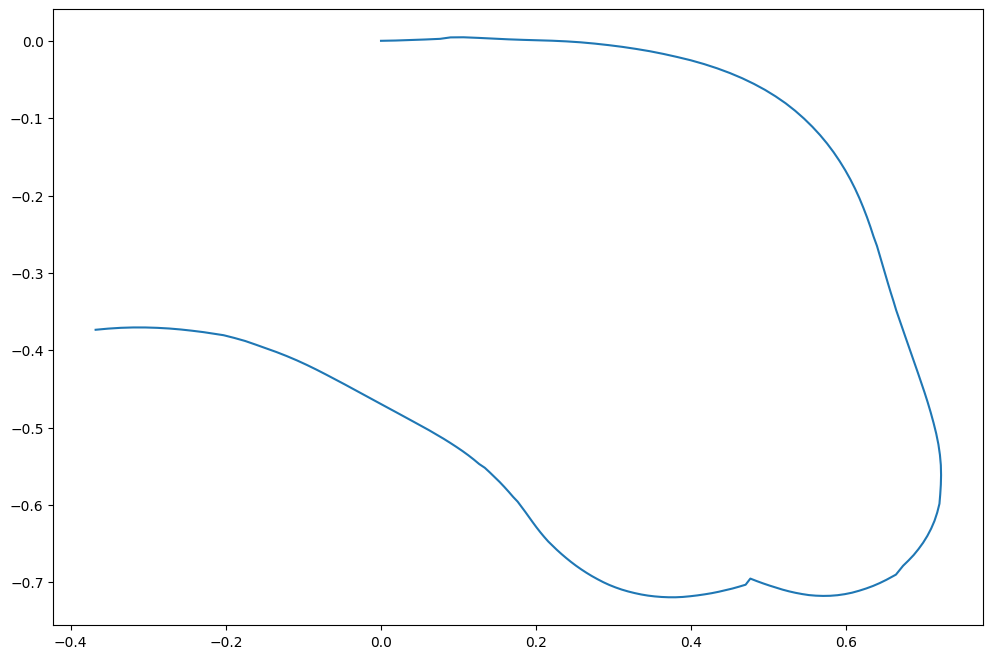

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path1, window size = 30
here
Elapsed time: 4.47 seconds


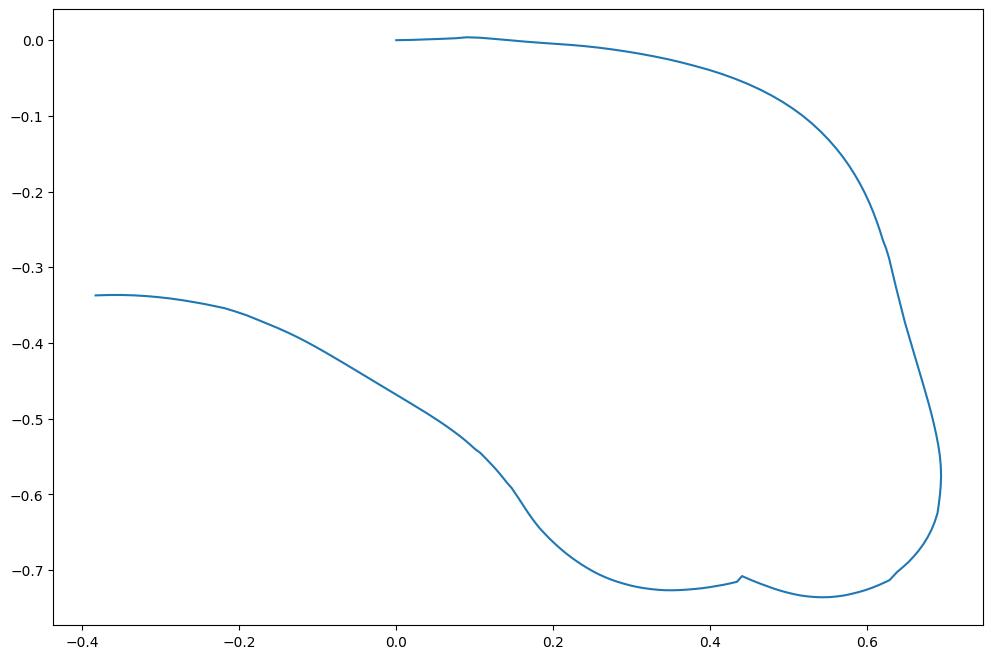

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path1, window size = 40
here
Elapsed time: 4.49 seconds


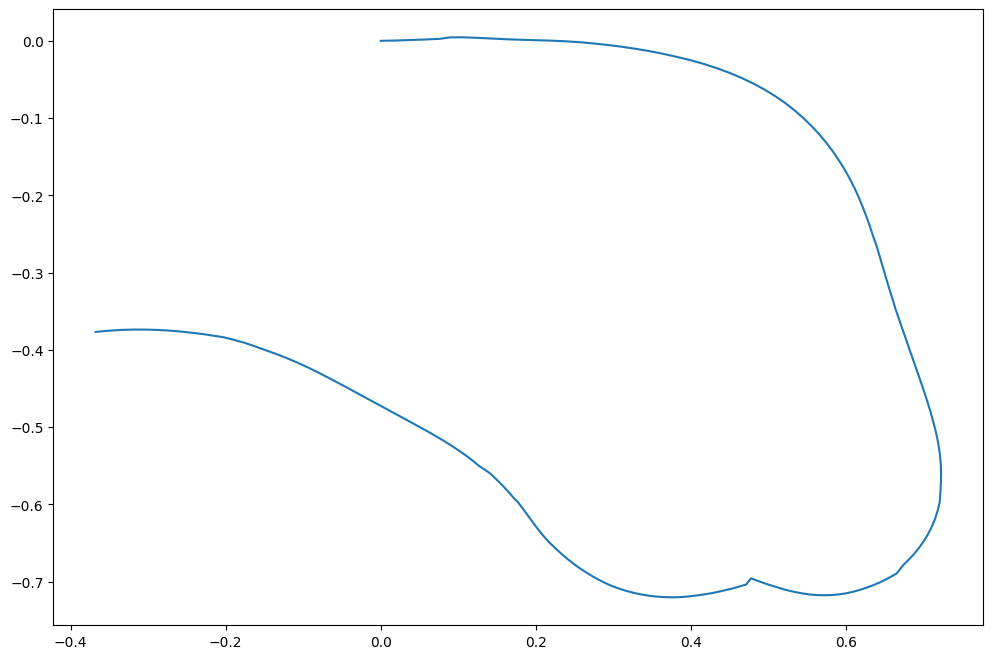

----------------------------------------------------------------------------------------------------
Working on = kitchen_test_sq_test_path1, window size = 50
here
Elapsed time: 4.48 seconds


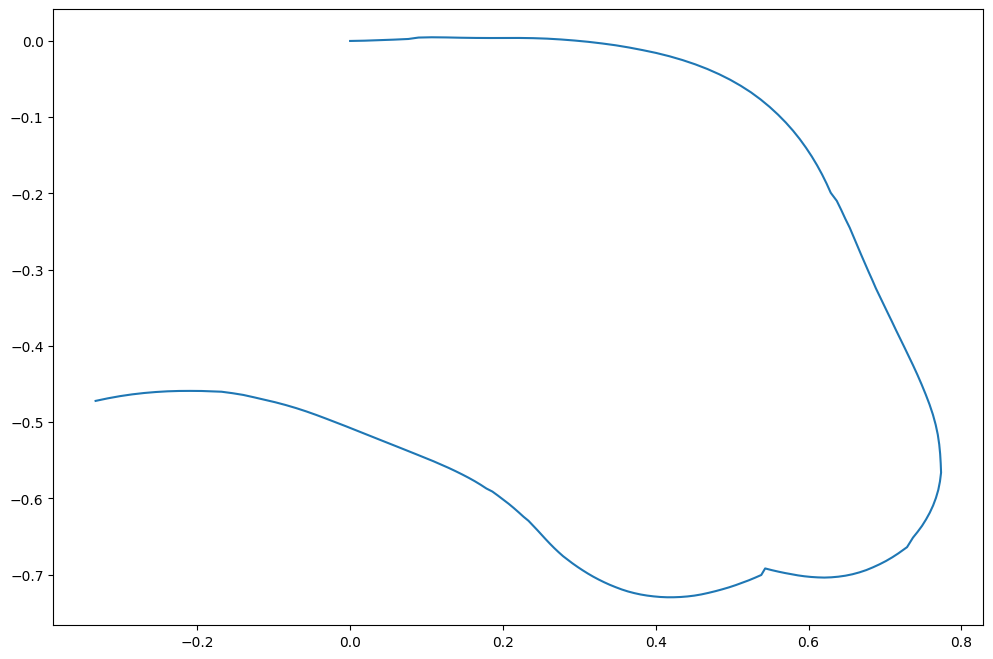

In [8]:
for data_name in dataset:
    for i in range(5):
        
        start_time = time.time()

        print("-" * 100)
        windowSize = (i+1) * 10  
        dataPath = dataset[data_name]
        npFile = f'results/{data_name}_window{windowSize}.npy'
        
        print(f"Working on = {data_name}, window size = {windowSize}")
        results = run_algo(dataPath,windowSize)    
        np.save(npFile,results)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        
        plt.plot(results[:,0],results[:,1])
        plt.show()

### Run for custom dataset

In [8]:
# EXTRACT IMAGES FROM VIDEO

# Set video file path and output directory
video_path = 'IMG_8164.MOV'  # Replace with your video file path
output_dir = 'dataset_classroom_1_images'    # Directory to save the images

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Frame count to use for naming the saved images
frame_count = 0

while True:
    # Read the next frame from the video
    ret, frame = cap.read()

    # If frame is read correctly, ret is True
    if not ret:
        break

    # Construct image filename
    image_filename = os.path.join(output_dir, f'frame_{frame_count:04d}.jpg')

    # Save the frame as an image
    cv2.imwrite(image_filename, frame)
    
    # Print the frame being saved
    print(f'Saving {image_filename}')

    # Increment frame counter
    frame_count += 1

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

print(f'All frames saved to {output_dir}')


Saving dataset_classroom_1_images/frame_0000.jpg
Saving dataset_classroom_1_images/frame_0001.jpg
Saving dataset_classroom_1_images/frame_0002.jpg
Saving dataset_classroom_1_images/frame_0003.jpg
Saving dataset_classroom_1_images/frame_0004.jpg
Saving dataset_classroom_1_images/frame_0005.jpg
Saving dataset_classroom_1_images/frame_0006.jpg
Saving dataset_classroom_1_images/frame_0007.jpg
Saving dataset_classroom_1_images/frame_0008.jpg
Saving dataset_classroom_1_images/frame_0009.jpg
Saving dataset_classroom_1_images/frame_0010.jpg
Saving dataset_classroom_1_images/frame_0011.jpg
Saving dataset_classroom_1_images/frame_0012.jpg
Saving dataset_classroom_1_images/frame_0013.jpg
Saving dataset_classroom_1_images/frame_0014.jpg
Saving dataset_classroom_1_images/frame_0015.jpg
Saving dataset_classroom_1_images/frame_0016.jpg
Saving dataset_classroom_1_images/frame_0017.jpg
Saving dataset_classroom_1_images/frame_0018.jpg
Saving dataset_classroom_1_images/frame_0019.jpg
Saving dataset_class

Running the algo for data dataset_classroom_1_images/ with window size 5
here


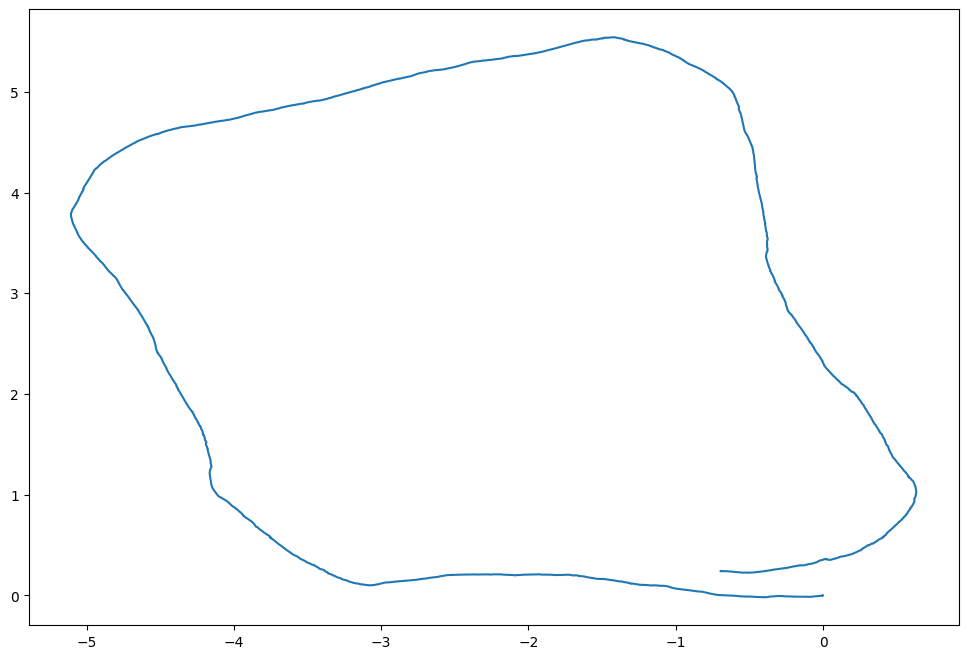

In [9]:
dataPath = 'dataset_classroom_1_images/'
for i in range(10):
    windowSize = (i+1) * 5
    print(f"Running the algo for data {dataPath} with window size {windowSize}")
    results = run_algo(dataPath,windowSize)
    npFile = f'results/{dataName}_window{windowSize}.npy'
    # np.save(npFile,results)
    
    plt.plot(results[:,0],results[:,1])
    plt.show()
    break

In [5]:
# EXTRACT IMAGES FROM VIDEO
def extractImages(vid,out):
    # Set video file path and output directory
    video_path = vid #'IMG_8164.MOV'  # Replace with your video file path
    output_dir = out #'dataset_classroom_1_images'    # Directory to save the images
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()
    
    # Frame count to use for naming the saved images
    frame_count = 0
    
    while True:
        # Read the next frame from the video
        ret, frame = cap.read()
    
        # If frame is read correctly, ret is True
        if not ret:
            break
    
        # Construct image filename
        image_filename = os.path.join(output_dir, f'frame_{frame_count:04d}.jpg')
    
        # Save the frame as an image
        cv2.imwrite(image_filename, frame)
        
        # Print the frame being saved
        # print(f'Saving {image_filename}')
    
        # Increment frame counter
        frame_count += 1
    
    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()
    
    print(f'All frames saved to {output_dir}')

In [6]:
vid_paths = os.listdir('data/')
for i in vid_paths:
    extractImages('data/' + i,i[:-4])

All frames saved to Path4
All frames saved to Path3
All frames saved to Path5
All frames saved to Path2
All frames saved to Path1


In [16]:
vid_paths[0][:-4]

'Path4'

In [ ]:
dataPath = 'dataset_classroom_1_images/'
for i in range(10):
    windowSize = (i+1) * 5
    print(f"Running the algo for data {dataPath} with window size {windowSize}")
    results = run_algo(dataPath,windowSize)
    npFile = f'results/{dataName}_window{windowSize}.npy'
    # np.save(npFidataPath = 'dataset_classroom_1_images/'
for i in range(10):
    windowSize = (i+1) * 5
    print(f"Running the algo for data {dataPath} with window size {windowSize}")
    results = run_algo(dataPath,windowSize)
    npFile = f'results/{dataName}_window{windowSize}.npy'
    # np.save(npFile,results)
    
    plt.plot(results[:,0],results[:,1])
    plt.show()
    breakle,results)
    
    plt.plot(results[:,0],results[:,1])
    plt.show()
    break

In [10]:
for dataPath in vid_paths:
    windowSize = (i+1) * 5
    print(f"Running the algo for data {dataPath} with window size {windowSize}")
    results = run_algo(dataPath,windowSize)
    npFile = f'results/{dataName}_window{windowSize}.npy'
    # np.save(npFile,results)
    
    plt.plot(results[:,0],results[:,1])
    plt.show()

(6355, 3)

In [6]:
prefixed = [filename for filename in os.listdir('.') if filename.startswith("Path")]
prefixed.sort()
prefixed

['Path1', 'Path2', 'Path3', 'Path4', 'Path5']

Running the algo for data Path2/ with window size 25
here


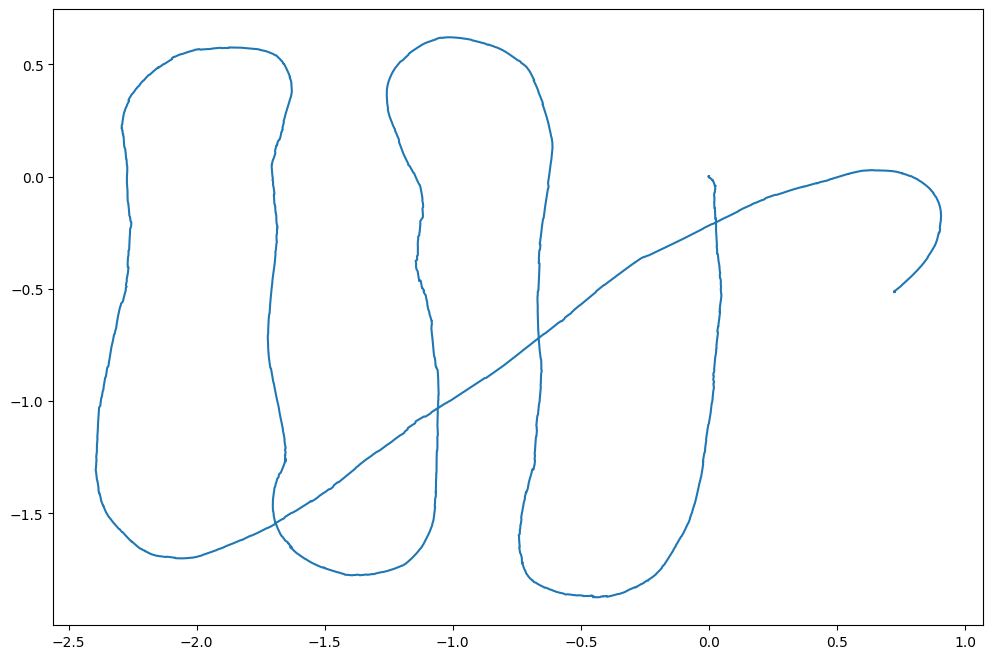

In [9]:
for i in prefixed[1:2]:
    dataPath = i + '/'
    windowSize = 25
    print(f"Running the algo for data {dataPath} with window size {windowSize}")
    results = run_algo(dataPath,windowSize)
    dataName = dataPath.replace('/','_')
    npFile = f'results/{dataName}window{windowSize}.npy'
    np.save(npFile,results)
    
    plt.plot(results[:,0],results[:,1])
    plt.show()

Running the algo for data Path4/ with window size 85
here


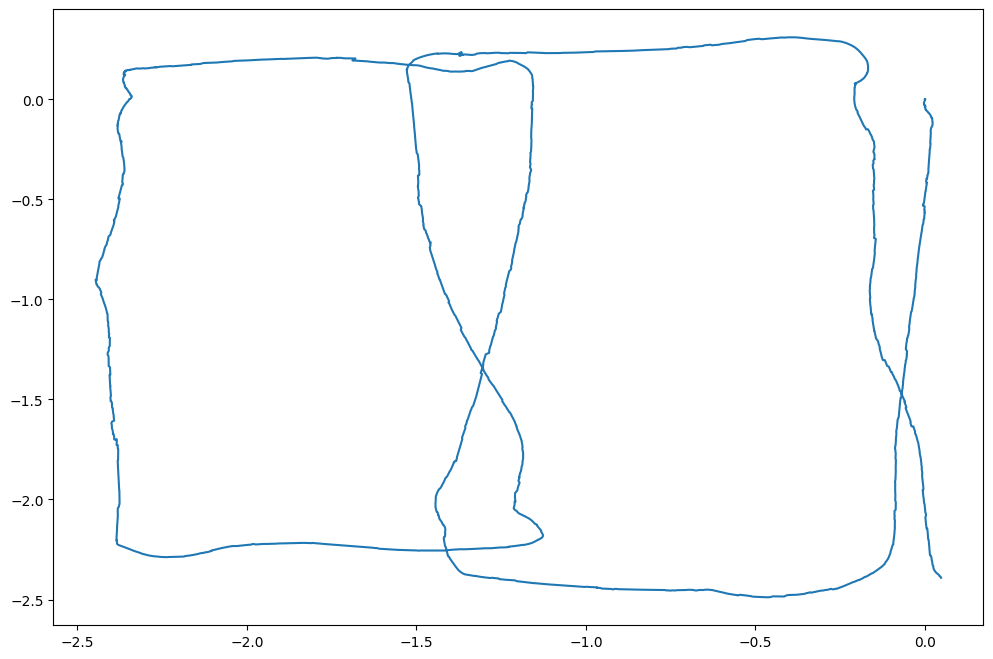

Running the algo for data Path5/ with window size 85
here


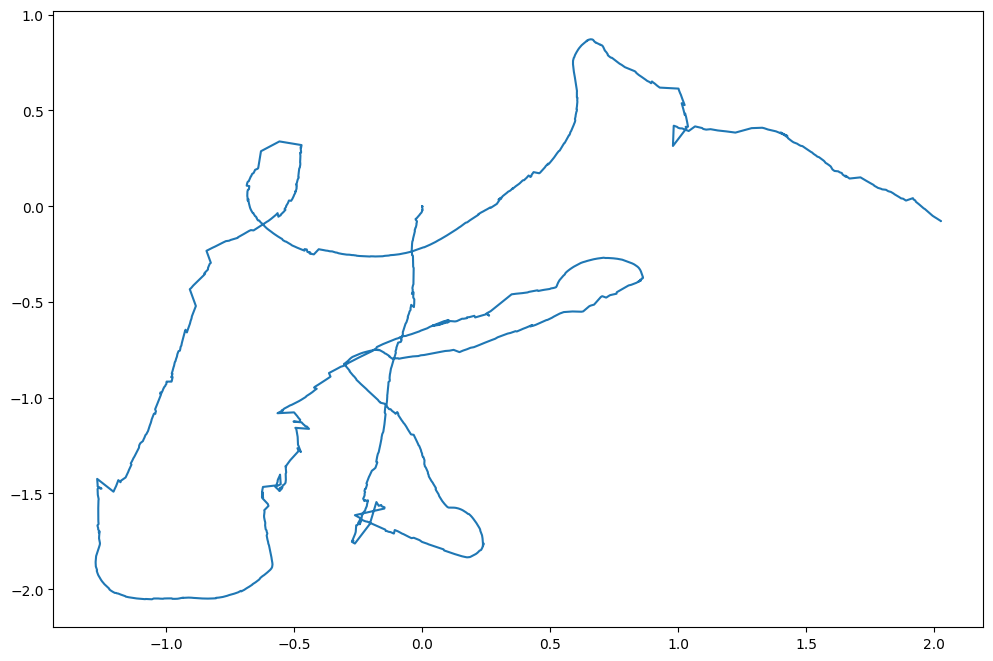

In [42]:
for i in prefixed[3:]:
    dataPath = i + '/'
    windowSize = 85
    print(f"Running the algo for data {dataPath} with window size {windowSize}")
    results = run_algo(dataPath,windowSize)
    dataName = dataPath.replace('/','_')
    npFile = f'results/{dataName}_window{windowSize}.npy'
    np.save(npFile,results)
    
    plt.plot(results[:,0],results[:,1])
    plt.show()
    # break

Running the algo for data Path5/ with window size 10
here


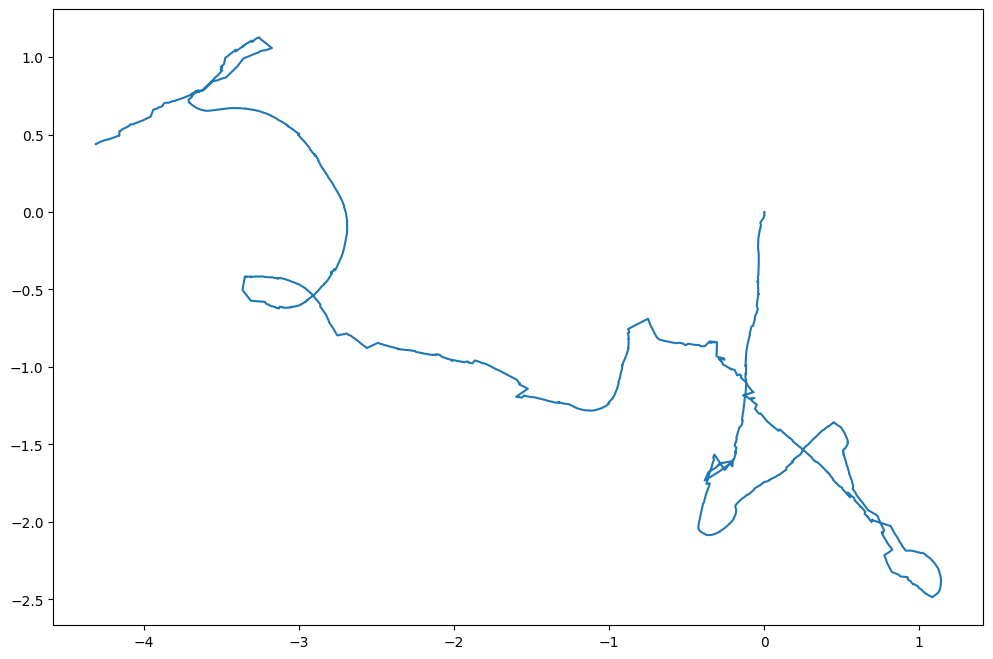

In [43]:
for i in prefixed[4:]:
    dataPath = i + '/'
    windowSize = 10
    print(f"Running the algo for data {dataPath} with window size {windowSize}")
    results = run_algo(dataPath,windowSize)
    dataName = dataPath.replace('/','_')
    npFile = f'results/{dataName}_window{windowSize}.npy'
    np.save(npFile,results)
    
    plt.plot(results[:,0],results[:,1])
    plt.show()
    # break

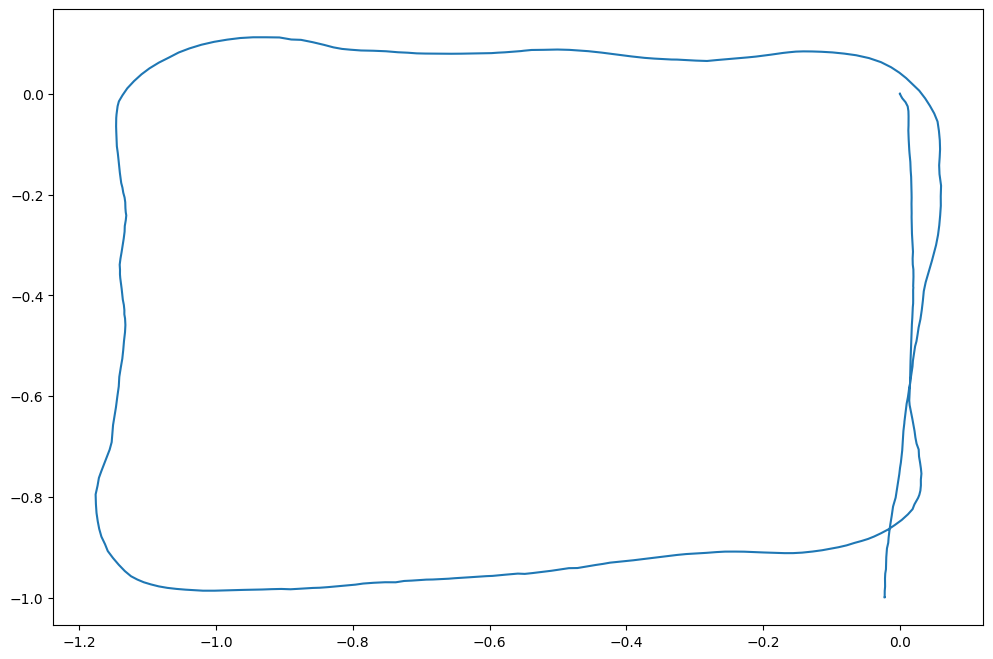

In [15]:
dataName = dataPath.replace('/','_')
npFile = f'results/{dataName}_window{windowSize}.npy'
np.save(npFile,results)

plt.plot(results[:,0],results[:,1])
plt.show()

In [33]:
extractImages('data/path_tunnel.MOV','path_tunnel')

All frames saved to path_tunnel


Running the algo for data path_tunnel/ with window size 1
here


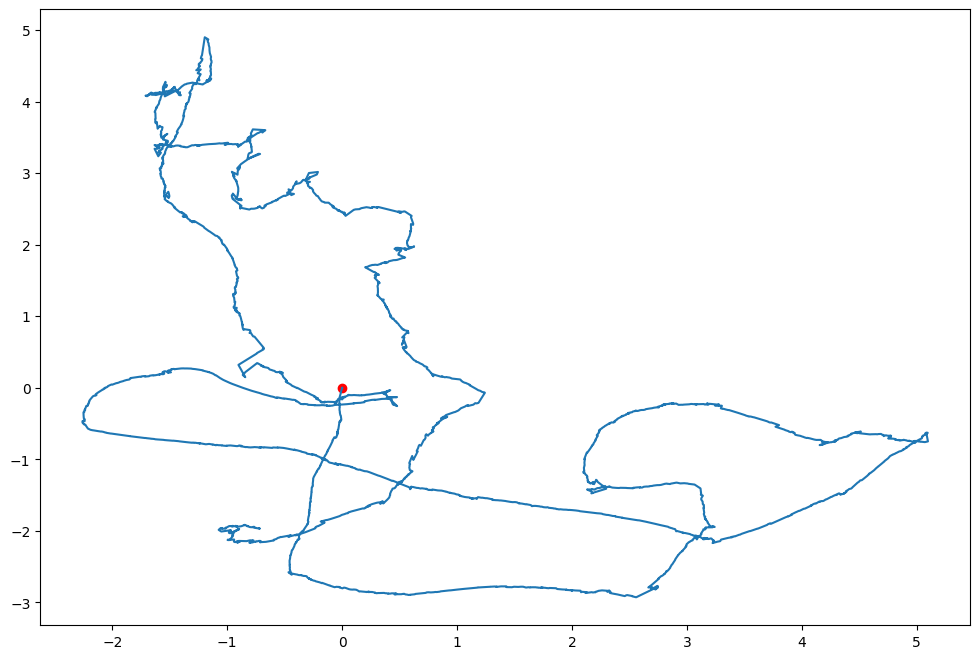

In [41]:
dataPath = 'path_tunnel/'
windowSize = 1
print(f"Running the algo for data {dataPath} with window size {windowSize}")
results = run_algo(dataPath,windowSize)
dataName = dataPath.replace('/','_')
npFile = f'results/{dataName}_window{windowSize}.npy'
np.save(npFile,results)

plt.plot(results[:,0],results[:,1])
plt.scatter(results[0,0],results[0,1],c="red")
plt.show()

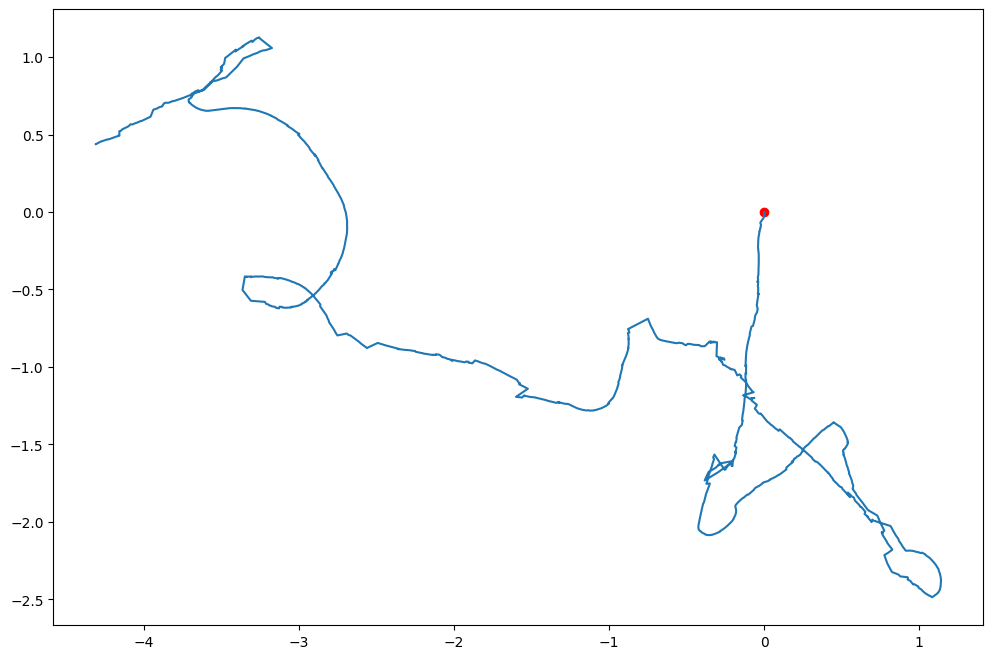

In [44]:
plt.plot(results[:,0],results[:,1])
plt.scatter(results[0,0],results[0,1],c="red")
plt.show()